In [1]:
# For boba

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2"

import torch
print(torch.cuda.device_count())

2


In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# model_name = "meta-llama/Llama-2-7b-chat-hf"
model_name = "HuggingFaceTB/SmolLM-1.7B-Instruct"

model = AutoModelForCausalLM.from_pretrained(model_name,torch_dtype=torch.float16, attn_implementation='sdpa', device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')

/home/vijay/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/vijay/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
import transformers
print(transformers.__version__)

4.37.2


In [4]:
padding_window = 32
query_window = 16
max_tokens = 256

In [5]:
from typing import Optional, Tuple
from transformers.cache_utils import Cache
from transformers.models.llama.modeling_llama import apply_rotary_pos_emb, repeat_kv
import math
from torch import nn
import torch.nn.functional as F

def sdpa_forward(
    self,
    hidden_states: torch.Tensor,
    attention_mask: Optional[torch.Tensor] = None,
    position_ids: Optional[torch.LongTensor] = None,
    past_key_value: Optional[Cache] = None,
    output_attentions: bool = False,
    use_cache: bool = False,
) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
    # print("Running custom forward function")
    bsz, q_len, _ = hidden_states.size()

    query_states = self.q_proj(hidden_states)
    key_states = self.k_proj(hidden_states)
    value_states = self.v_proj(hidden_states)

    query_states = query_states.view(bsz, q_len, self.num_heads, self.head_dim).transpose(1, 2)
    key_states = key_states.view(bsz, q_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)
    value_states = value_states.view(bsz, q_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)

    kv_seq_len = key_states.shape[-2]
    if past_key_value is not None:
        kv_seq_len += past_key_value.get_usable_length(kv_seq_len, self.layer_idx)
    cos, sin = self.rotary_emb(value_states, seq_len=kv_seq_len)

    query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin, position_ids)

    if past_key_value is not None:
        cache_kwargs = {"sin": sin, "cos": cos}  # Specific to RoPE models
        key_states, value_states = past_key_value.update(key_states, value_states, self.layer_idx, cache_kwargs)

    key_states = repeat_kv(key_states, self.num_key_value_groups)
    value_states = repeat_kv(value_states, self.num_key_value_groups)

    if attention_mask is not None:
        if attention_mask.size() != (bsz, 1, q_len, kv_seq_len):
            raise ValueError(
                f"Attention mask should be of size {(bsz, 1, q_len, kv_seq_len)}, but is {attention_mask.size()}"
            )

    # SDPA with memory-efficient backend is currently (torch==2.1.2) bugged with non-contiguous inputs with custom attn_mask,
    # Reference: https://github.com/pytorch/pytorch/issues/112577.
    if query_states.device.type == "cuda" and attention_mask is not None:
        query_states = query_states.contiguous()
        key_states = key_states.contiguous()
        value_states = value_states.contiguous()

    # multiply q by k and and return it back to the user.
    attn_weights = torch.matmul(query_states[..., -query_window:, :], key_states.transpose(2, 3)) / math.sqrt(self.head_dim)
    mask = torch.full((query_window, query_window), torch.finfo(attn_weights.dtype).min, device=attn_weights.device)
    mask_cond = torch.arange(mask.size(-1), device=attn_weights.device)
    mask.masked_fill_(mask_cond < (mask_cond + 1).view(mask.size(-1), 1), 0)
    mask = mask.to(attn_weights.device)
    weights_attention_mask = mask[None, None, :, :]
    attn_weights[:, :, -query_window:, -query_window:] += weights_attention_mask

    attn_weights = nn.functional.softmax(attn_weights, dim=-1, dtype=torch.float32).to(query_states.dtype)
    attn_weights_sum = attn_weights[:, :, -query_window:, : -query_window].sum(dim = -2)
    attn_cache = F.avg_pool1d(attn_weights_sum, kernel_size = 7, padding=7//2, stride=1)

    attn_output = torch.nn.functional.scaled_dot_product_attention(
        query_states,
        key_states,
        value_states,
        attn_mask=attention_mask,
        dropout_p=self.attention_dropout if self.training else 0.0,
        # The q_len > 1 is necessary to match with AttentionMaskConverter.to_causal_4d that does not create a causal mask in case q_len == 1.
        is_causal=self.is_causal and attention_mask is None and q_len > 1,
    )

    attn_output = attn_output.transpose(1, 2).contiguous()
    attn_output = attn_output.reshape(bsz, q_len, self.hidden_size)

    attn_output = self.o_proj(attn_output)

    return attn_output, attn_cache, past_key_value

for i in range(len(model.model.layers)):
    model.model.layers[i].self_attn.forward = sdpa_forward.__get__(model.model.layers[i].self_attn, type(model.model.layers[i].self_attn))

In [6]:
sample_text = open("snapkv_full.txt", "r", encoding="utf-8").read()
encoded_tokens = tokenizer(sample_text, return_tensors="pt")
for key in encoded_tokens:
    encoded_tokens[key] = encoded_tokens[key].cuda()
encoded_tokens = encoded_tokens.input_ids[0]
print(encoded_tokens.shape)

Token indices sequence length is longer than the specified maximum sequence length for this model (17256 > 2048). Running this sequence through the model will result in indexing errors


torch.Size([17256])


Query tokens:  scale language modeling.

What is the GitHub repository for SnapKV?
Unpadded chunks start:  [35, 2, 2, 2, 1, 1, 2, 3, 2, 1, 0, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 3, 2, 2, 2, 2, 1, 2, 2, 0, 0, 0, 1, 2, 1, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 1, 2, 2, 1, 2, 3, 2, 2, 2, 2, 2, 0, 2, 2, 2, 3, 2, 2, 2, 2, 2]
First length:  24
Second length:  130
Third length:  torch.Size([32, 279])
Shape:  torch.Size([24, 130, 32, 279])
Shape:  torch.Size([130, 32, 279])
Shape:  torch.Size([130, 32, 279])
Score:  4756.0
<|im_start|>user
, which are more intricate than synthetic long-context tasks like Needle-in-a-Haystack and closer to real use cases compared to tasks like NarrativeQA. RAG tasks require selecting pertinent documents from an indexed corpus based on the given prompt. An expanded context window enables 

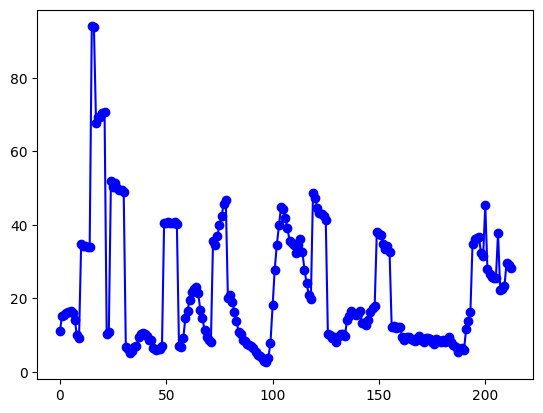

Score:  4510.0
<|im_start|>user
018blockwise, leviathan2023fast, chen2023accelerating, miao2023specinfer, zhang2024recurrent}. Parallel decoding leverages a lightweight model or an adaptor to draft initial tokens, which are subsequently verified by larger LLMs. This strategy effectively reduces memory overhead, a critical concern given the autoregressive nature of LLMs that renders them more memory-intensive than computationally demanding. Specifically, in LLMs, each decoding step involves generating a single token, with the transfer of weights between High Bandwidth Memory (HBM) and cache contributing to significant overhead~\cite{dao2022flashattention,dao2023flashattention}.

Our investigation incorporates \kv with \texttt{Medusa}~\cite{cai2024medusa}\footnote{\url{https://github.com/FasterDecoding/Medusa}}, a cutting-edge parallel decoding framework that utilizes multiple classifiers and tree attention mechanisms for drafting tokens, subsequently verified by LLMs. One of the challen

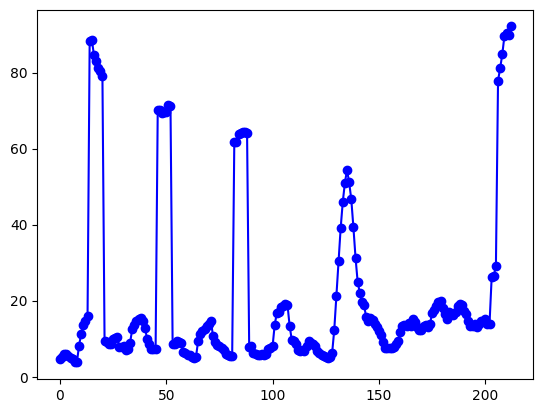

Score:  4396.0
<|im_start|>user
v0.1} with 32k context length as our baselines. For each model, we test \kv with various settings: compressing KV caches in the prompt to 1024, 2048, and 4096 tokens. We use max pooling with kernel size 7 and observation window size 32. Table \ref{tab:longbench} illustrates a negligible performance drop from models with \kv compared with original implementations for 16 different datasets, even with prompt-KV with 1024 tokens. Some models even outperform the baseline. Our results substantiate that \kv can grasp the key information in the long context and give comprehensive summaries with details. Moreover, our results also indicate the effectiveness of \kv in compressing the prompt KV cache. For \texttt{LongChat-7b-v1.5-32k}, the average input token length is 12521; for \texttt{LWM-Text-Chat-1M}, 13422; for Mistral, 13160. Thus, using 1024, \kv achieves an average compression rate of 92\%, and using 4096, it reaches 68scale language modeling.

What is the

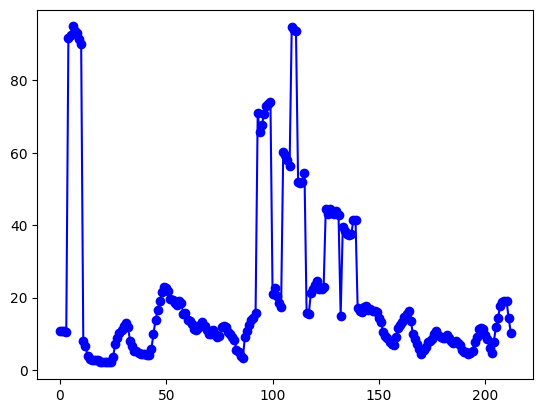

Score:  4384.0
<|im_start|>user
Instruct-v0.2_nopool.pdf}
    \includegraphics[width=0.9\textwidth]{figures/Mistral-7B-Instruct-v0.2_maxpool.pdf}
    \caption{Ablation study of pooling on LongEval-Lines. The evaluation includes inputs, each comprised of lines formatted as "\texttt{line makeshift-penguin: REGISTER\_CONTENT is <10536>}", where the key is an adjective-noun pair and the value is a random 5-digit number. The model needs to retrieve the value based on a given key. 
    The x-axis denotes the length of the input; the y-axis indicates the position of the groundtruth, from 5K to 30K tokens. With the pooling, the model can retrieve correct values before 16k and performs significantly better than the one without pooling.
    }
    \label{fig: ablation}
\end{figure}
We perform an ablation study to assess the impact of our pooling technique, a straightforward but efficient method for consolidating information through clustering. Our evaluation utilizes the modified LongEval-Lines b

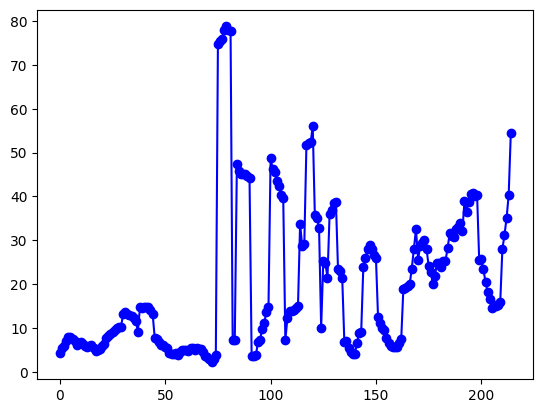

Score:  4350.0
<|im_start|>user
 performance comparison on single A100-80GB GPU, native HuggingFace implementation with only a few lines of code changed. The x-axis denotes the length of the document (the “haystack”); the y-axis indicates the position that the “needle” (a short sentence) is located within the document, from 1K to 380K tokens. For example, 50\% indicates that the needle is placed in the middle of the document. Here LWMChat with \kv is able to retrieve the needle correctly before 160k and with only a little accuracy drop after. Meanwhile, the original implementation encounters OOM error with 33k input tokens.
    }
    \label{fig: needle}
\end{figure}
\begin{figure}[ht]
    \centering
    \includegraphics[width=0.8\textwidth]{figures/benchmark.pdf}
    \caption{Deconding speed comparison of baseline implementation and \kv optimized solutions on various batch sizes. The x-axis denotes the input sequence length; the y-axis indicates decoding speed (ms/token). All experimen

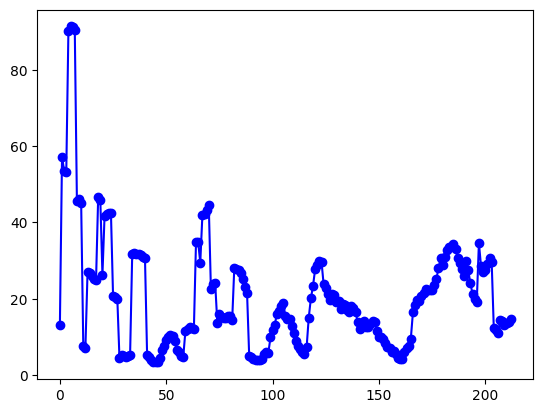

Score:  4284.0
<|im_start|>user
, \kv can process up to 380K context tokens on a single A100-80GB GPU using HuggingFace implementation with minor changes, exhibiting only a negligible accuracy drop in the Needle-in-a-Haystack test. Further comprehensive studies suggest \kv's potential for practical applications. Our code is available at ~\url{https://github.com/FasterDecoding/SnapKV}.
\end{abstract}
\section{Introduction}

\subsubsection{Needle-in-a-Haystack} 
The Needle-in-a-Haystack test \cite{kamradt2023needle} challenges the model to accurately retrieve information from a specific sentence("needle") hidden within a lengthy document (the "haystack"), with the sentence placed at a random location. To rigorously evaluate \kv's capabilities, we extended the document length to 380k tokens which is the longest content that can be processed by a single A100-80GB GPU. We configured the prompt KV cache size to 1024, enabling \kv to select the most crucial 1024 attention features from the pr

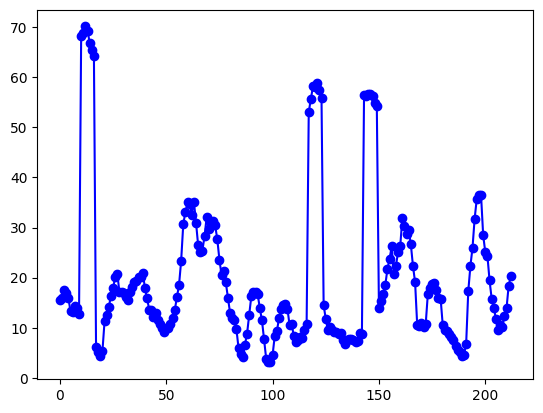

Score:  4268.0
<|im_start|>user
 Conversations})

\item \textbf{Invariance to question positions in summarization tasks:} In the context of long summarization and question-answering tasks, the positioning of questions within the prompt (either at the beginning or the end) does not significantly alter the consistency of attention patterns observed. This suggests a level of robustness in how we can obtain the attention of relevant features trivially, regardless of the position of questions. (Sec.~\ref{sec: Do Question Positions Matter?})

\item \textbf{Contextual dependency of patterns:} The observed attention patterns are highly context-sensitive, indicating a strong association with the specific instructions posed by the user (Sec.~\ref{sec: Do Different Questions Matter for One Document?}). Thus, a context-aware KV compression approach can potentially lead to better performance.

\end{enumerate}


To structure our experimental analysis coherently, we introduce the following terminolog

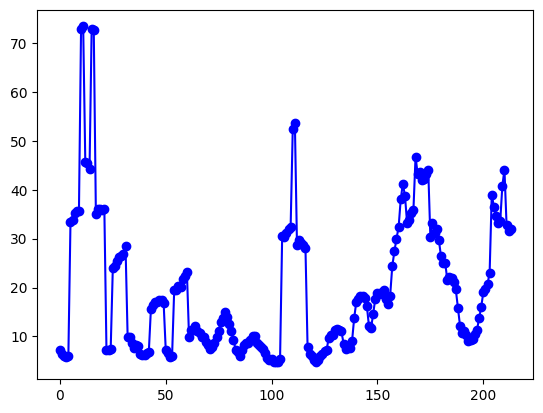

Score:  4264.0
<|im_start|>user
28K, Claude-3~\cite{anthropic2024claude3} with 200K, and Gemini-Pro-1.5 with 1M~\cite{reid2024gemini}. Despite their impressive capabilities, LLMs still face significant challenges when dealing with long context inputs. Specifically, the KV caches in attention calculation become an obstacle in efficiently processing long context. During inference time, as input length increases, the decoding speed per step grows linearly due to the computation for attention across past KVs. Moreover, the large KV cache created during prompting requires significant on-chip and off-chip memory, increasing hardware demands and limiting model scalability.

There are many perspectives to mitigate these problems, including KV cache eviction during token generation~\cite{xiao2023efficient, zhang2024h2o, liu2024scissorhands, ge2023model}. However, most of these methods lack a detailed evaluation of the generated context in a long-context setting. Moreover, they mainly focus on o

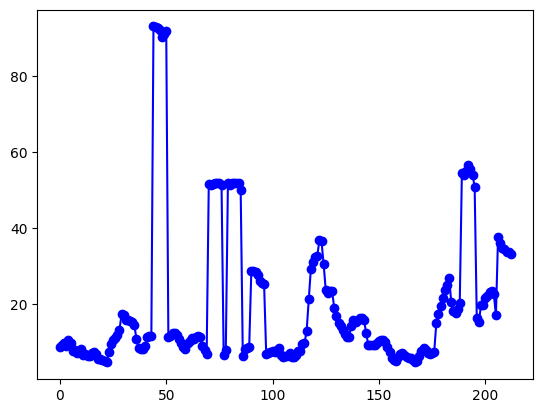

Score:  4264.0
<|im_start|>user
 \item We evaluate \kv for accuracy and efficiency across diverse LLMs and long-sequence datasets, affirming its improvement over previous work and comparability to conventional KV caching. Furthermore, we conduct the Needle-in-a-Haystack test to demonstrate its memory efficiency and illustrate decoding speed enhancements through varied batch sizes and input lengths. In addition, \kv's integration with a leading RAG model showcases its extended performance capabilities. We also show that \kv can be combined orthogonally with other acceleration strategies such as parallel decoding.

    
\end{itemize}
\section{Related Works}

Many previous works address the KV cache compression by evicting the KV cache using different algorithms. For example, StreamLLM \cite{xiao2023efficient} maintains the first few tokens and the local tokens to effectively reduce the KV cache size. However, it faces the challenge of losing important information since it continuously ev

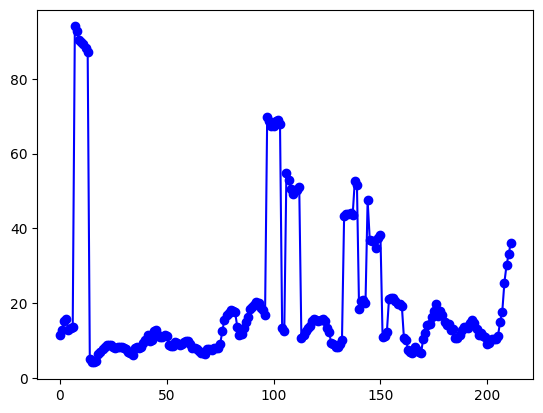

Score:  4236.0
<|im_start|>user
}{TGI trained \texttt{Medusa} heads}} undergoing a maximum of 128 generation steps unless preemptively halted. The experiments utilized a subset of the QASPER~\cite{dasigi2021dataset}, with a fixed prompt instructing the LLM to summarize the paper. The truncation strategy adopted aligns with LongBench~\cite{bai2023longbench} standards, by removing the context in the middle to achieve the desired sequence length for benchmarking.

The findings indicate a slowdown in \texttt{Medusa}'s performance as sequence lengths extend, a challenge effectively mitigated by \kv's intervention, which achieved a 1.3x speedup for sequences with 10k length compared to \texttt{Medusa} and a 2.2x speedup compared to the native decoding. This improvement underscores the potential of combining KV cache compression with parallel decoding frameworks to enhance LLM efficiency, particularly in long-context scenarios.
\section{Discussions}
\kv emerges as a potent yet straightforward

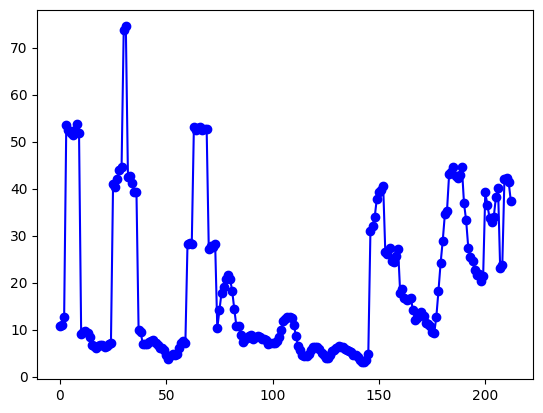

Score:  4224.0
<|im_start|>user
 overhead~\cite{dao2022flashattention,dao2023flashattention}.

Our investigation incorporates \kv with \texttt{Medusa}~\cite{cai2024medusa}\footnote{\url{https://github.com/FasterDecoding/Medusa}}, a cutting-edge parallel decoding framework that utilizes multiple classifiers and tree attention mechanisms for drafting tokens, subsequently verified by LLMs. One of the challenges identified is the issue of speculative decoding in processing long sequences since generating multiple tokens per decoding step introduces computational bottlenecks during long sequence processing, such as query-key matrix multiplication tiling~\cite{dao2023flash}. By maintaining a constant size for the KV cache associated with prompts during generation, \kv enhances generation efficiency.

Empirical results shown in Figure~\ref{fig: medusa} highlight the performance across various prompt lengths, with \texttt{Mistral-7B-Instruct-v0.2}\footnote{\href{https://huggingface.co/text-gen

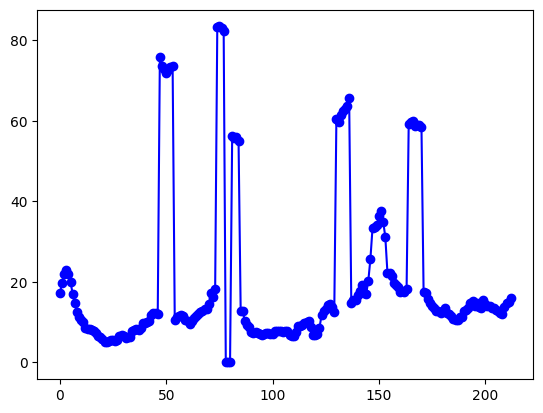

Score:  4200.0
<|im_start|>user
, with a maximum pooling kernel size of 5 and a observation window size of 16. The compelling outcomes in Fig. \ref{fig: needle} from the Needle-in-a-Haystack test underscore \kv's potential to precisely manage small details on extremely long input contexts with a 380x compression ratio. 
\begin{figure}[ht]
    \centering
        \includegraphics[width=0.9\textwidth]{figures/LWM-Text-Chat-1M_compress.pdf}
    \caption{Needle-in-a-Haystack test performance comparison on single A100-80GB GPU, native HuggingFace implementation with only a few lines of code changed. The x-axis denotes the length of the document (the “haystack”); the y-axis indicates the position that the “needle” (a short sentence) is located within the document, from 1K to 380K tokens. For example, 50\% indicates that the needle is placed in the middle of the document. Here LWMChat with \kv is able to retrieve the needle correctly before 160k and with only a little accuracy drop after. Mean

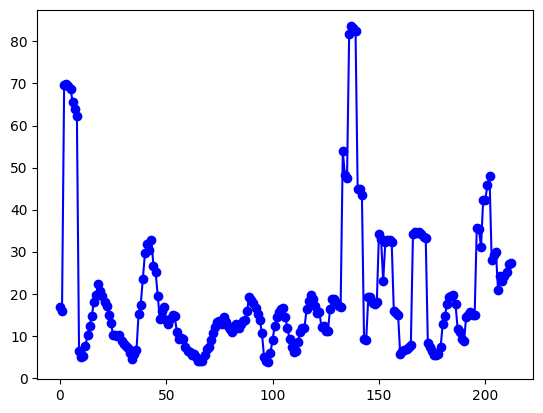

Score:  4200.0
<|im_start|>user
 processing and multi-round chats, where prompts are exceptionally long yet require accurate information retrieval. In common use cases, the generated outputs, like summaries, code pieces, or retrieved data, are significantly shorter compared to the extensive input sequences from novels, entire code bases, or annual financial reports. Although these techniques may effectively reduce the KV cache size during the generation phase, they do not tackle the primary overhead and challenges arising from a lack of comprehension of complex input contexts, thus leaving the critical issues unresolved.
\section{Observations}\label{sec: obs}

In this section, we present our observations regarding the patterns in the Query-Key matrix during token generation. We discuss how these patterns can be potentially exploited for KV cache compression. Our findings are based on the analysis of various generation contexts and the behavior of attention mechanisms in LLMs and are co

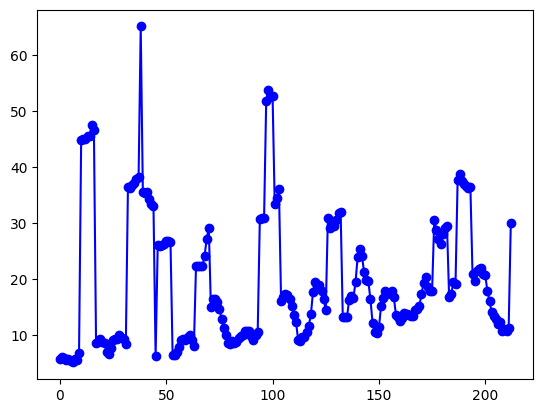

Score:  4172.0
<|im_start|>user
{Voting for Important Previous Features}
    By the voting process defined previously (Eq.~\ref{eq: length}), we select the important features based on the observation window—defined as the last segment of the prompt. Sec.~\ref{sec: Multi-Turn Conversations} highlights the consistency of these attention features throughout the sequence, suggesting that these features are vital for subsequent generation. Besides, we implement clustering to retain the features surrounding the selected features (See Sec.\ref{sec: clustering}). 
    
    \item \textbf{Update and Store Truncated Key and Value}
    We concatenate these selected features with the window features, which encompass all features containing prompt information. We store back the concatenated KV caches for later use in generation and save the memory usage.

\end{itemize}
\begin{lstlisting}[language=Python, escapechar=|, caption=Implementation of \kv in pseudo PyTorch style.]
def snap_kv(query_states, 

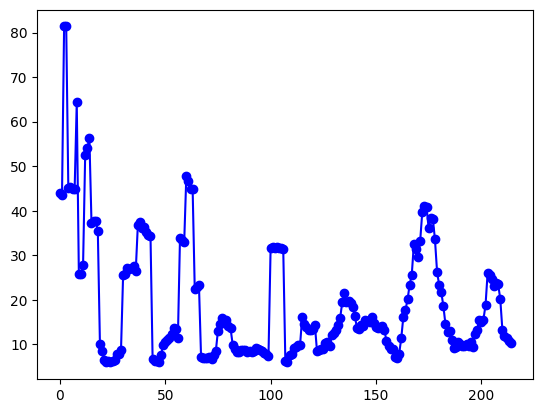

Score:  4172.0
<|im_start|>user

In the attention mechanism, keys and values are tensors containing information from the previous context. The linear growth in prompts will lead to exponential time complexity for generation due to the Query-Key matrix multiplication. \kv addresses this by keeping prompt KV cache counts constant during generation, significantly reducing serving times for long-context LLMs.

The fundamental approach of \kv involves identifying and selecting the most crucial attention features per head to create the new KV cache. \kv operates through two stages as shown in Fig.~\ref{fig: algo}:
\begin{itemize}[leftmargin=*]
    \item \textbf{Voting for Important Previous Features}
    By the voting process defined previously (Eq.~\ref{eq: length}), we select the important features based on the observation window—defined as the last segment of the prompt. Sec.~\ref{sec: Multi-Turn Conversations} highlights the consistency of these attention features throughout the sequence

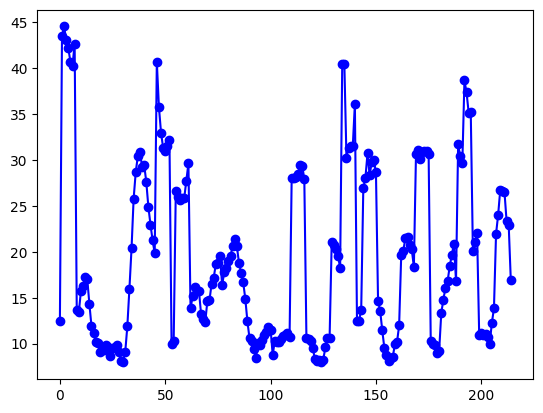

Score:  4148.0
<|im_start|>user
 this finding, we also design a thorough set of experiments across diverse inputs in terms of length, format, and content. Based on our observations, we derive an innovative and intuitive method, \kv, which can effectively compress the KV cache for long sequence inputs without compromising the model's accuracy. Our contributions are as follows:
\begin{itemize}
    \item We design experiments to explore the patterns of attention features in output generation, focusing on three key questions: 
    \begin{enumerate}
        \item Is there a consistent pattern in the attention allocated to prompt tokens?
        \item How does the context and instruction positioning influence this attention allocation pattern?
        \item Does the nature of the user's instructions play a role in shaping these attention patterns?
    \end{enumerate}
    Our finding suggests that most of the LLMs' attention allocation of input sequence remains unchanged during generation. Th

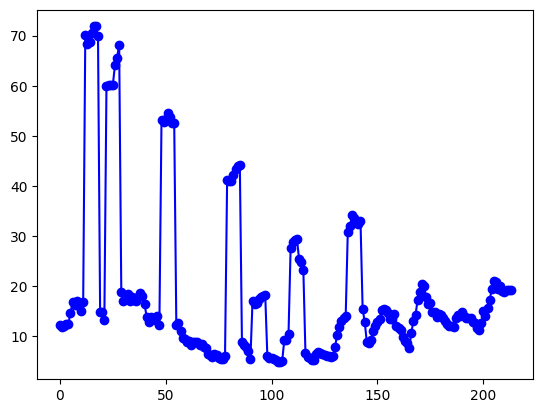

Score:  4148.0
<|im_start|>user
 is typically the bottleneck in memory efficiency. In practical applications such as chatbots and agents, where inputs can be multi-turn conversations, extensive articles or codebases~\cite{achiam2023gpt, liu2021lifelong, bairi2023codeplan}, input sizes are often much larger than the sizes of generated responses, resulting in significant overhead. Additional challenge lies in compressing such vast inputs without losing crucial information for accurate generation, especially in scenarios with various noisy contexts.

In our paper, we identify the patterns of these important prompt attention features during generation. To validate the robustness of this finding, we also design a thorough set of experiments across diverse inputs in terms of length, format, and content. Based on our observations, we derive an innovative and intuitive method, \kv, which can effectively compress the KV cache for long sequence inputs without compromising the model's accuracy. O

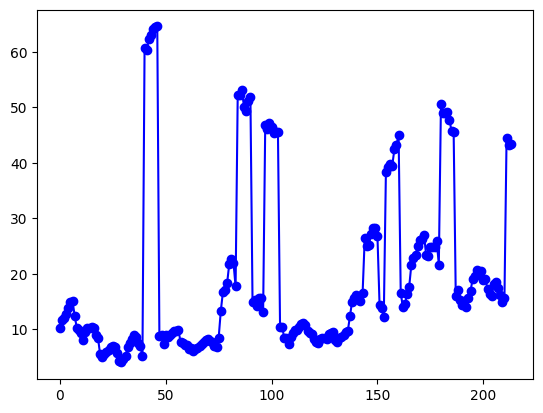

Score:  4108.0
<|im_start|>user
 effectively mitigated by \kv's intervention, which achieved a 1.3x speedup for sequences with 10k length compared to \texttt{Medusa} and a 2.2x speedup compared to the native decoding. This improvement underscores the potential of combining KV cache compression with parallel decoding frameworks to enhance LLM efficiency, particularly in long-context scenarios.
\section{Discussions}
\kv emerges as a potent yet straightforward solution, adeptly compressing the KV caches of models to mitigate the computational and memory burdens associated with processing extensive inputs. Originating from a nuanced observation that specific tokens within prompts garner consistent attention from each head during generation, our methodology not only conserves crucial information but also enhances processing efficiency. 
% limitation
Despite its strengths, \kv's scope is primarily confined to the generative aspect of models, specifically targeting the KV caches during the ge

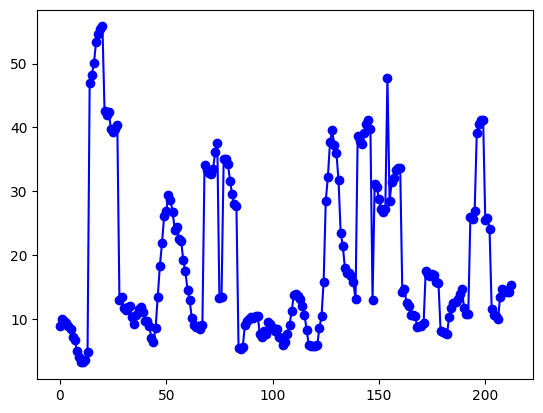

Score:  3968.0
<|im_start|>user
 cache compression by evicting the KV cache using different algorithms. For example, StreamLLM \cite{xiao2023efficient} maintains the first few tokens and the local tokens to effectively reduce the KV cache size. However, it faces the challenge of losing important information since it continuously evicts the KV cache.\footnote{\url{https://github.com/mit-han-lab/streaming-llm?tab=readme-ov-file\#faq}} 
Another perspective is to compress the KV cache for generation steps. Heavy-Hitter Oracle \cite{zhang2024h2o} introduces a KV cache eviction policy that greedily selects tokens during generation steps based on a scoring function derived from cumulative attention. While this approach effectively compresses the KV cache for generated tokens, it overlooks compression of the input sequence KV cache, which is crucial for reducing memory and computational overhead.
Building on a similar concept, Adaptive KV Compression (FastGen) \cite{ge2023model} implements a d

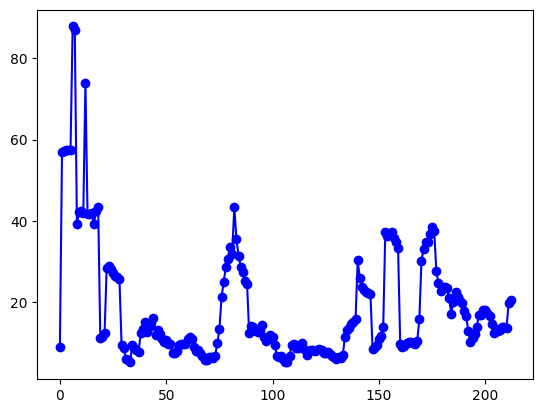

Score:  3956.0
<|im_start|>user
 & -0.9\% \\
                     &                      & Avg & -0.6\% \\ \midrule
\multirow{4}{*}{200} & \multirow{4}{*}{24k} & 0  & +4.9\% \\
                     &                      & 14 & +4.9\% \\
                     &                      & 30 & +6.4\% \\
                     &                      & Avg & +5.4\% \\ \bottomrule
\end{tabular}
\smallskip
\small
\textit{Note:} For each number of sampled documents, we report the approximate context length and the difference from the baseline at each ground-truth position.
\end{table}
As Table \ref{table:commandr_generation} shows, \kv is robust in terms of generation quality and does not suffer from the well-known lost-in-the-middle pathology. Moreover, \kv improves performance over the baseline model when the context contains close to 200 documents. One potential explanation to this is that by adequately compressing the KV cache, we can effectively reduce the noise from negative documents and pus

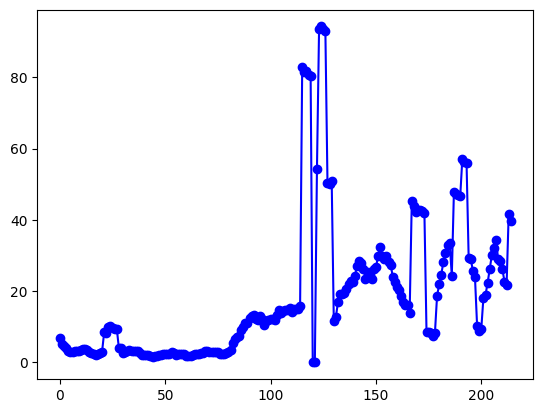

Score:  3946.0
<|im_start|>user
Key matrix during token generation. We discuss how these patterns can be potentially exploited for KV cache compression. Our findings are based on the analysis of various generation contexts and the behavior of attention mechanisms in LLMs and are concluded into three key observations as follows: 

\begin{enumerate}
\item \textbf{Pattern consistency across contexts:} Irrespective of the generation context length, we observed that specific keys within the prompt consistently exhibit higher attention weights. Such ``active'' keys tend to follow stable patterns that appear to be intrinsically related to the structure and content of the prompt. (Sec.~\ref{sec: Multi-Turn Conversations})

\item \textbf{Invariance to question positions in summarization tasks:} In the context of long summarization and question-answering tasks, the positioning of questions within the prompt (either at the beginning or the end) does not significantly alter the consistency of atte

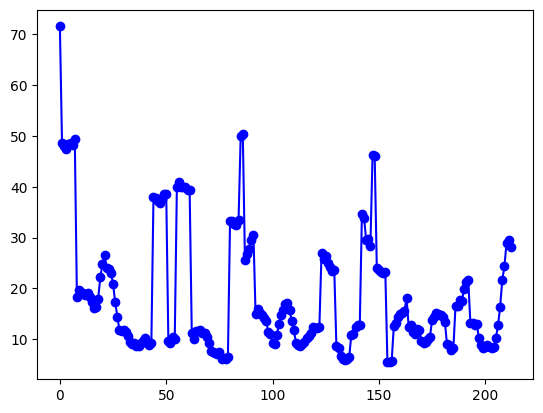

Score:  3912.0
<|im_start|>user
zhong2021qmsum}, a query-based multi-domain meeting summarization; Openreview \cite{an2023eval}, a collection of papers from \texttt{openreview.net}; SPACE \cite{angelidis2021extractive}, an extractive opinion summarization in quantized transformer spaces.


\subsubsection{Effectiveness of Instruction Positions}
\label{sec: Do Question Positions Matter?}
Our investigation also extends to the significance of instruction positioning on the interpretability of LLMs and their selection of important features. We calculate the average hit rate for the responses using the same observation window size of 32 as in the previous experiment. Our results shown in Fig. \ref{fig: question_pos} indicate that across all three datasets, the hit rates are consistently high regardless of whether instructions are positioned before or after extensive supplementary contexts. This consistency suggests that the patterns identified by observation windows are independent of the qu

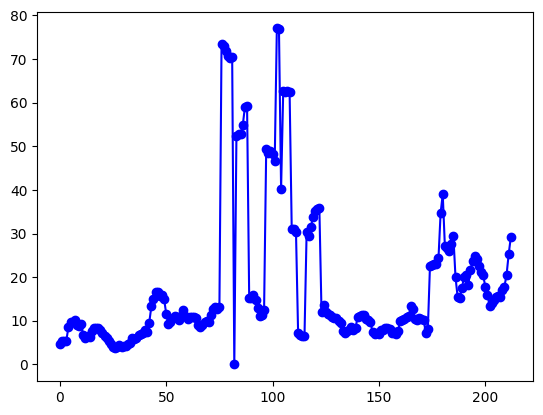

Score:  3888.0
<|im_start|>user
k_past_compress, k_obs], dim=2)
        value_states = torch.cat([v_past_compress, v_obs], dim=2)
        return key_states, value_states
\end{lstlisting}


\subsection{Efficient Clustering via Pooling}
\label{sec: clustering}
In LLMs, information retrieval and generation rely on features with high attention weight and are supplemented by copying the rest in context using induction heads~\cite{olsson2022context}. Hence, naively selecting the top features results in retaining only portions of details and then losing the completeness of the information. For example, such compression might cause the LLMs to retrieve only the country code of a phone number and hallucinate the rest. Our experiment also revealed that only selecting the features with the highest weights is insufficient (Sec.~\ref{sec:ablation}).  Such sparse selection risks compromising the contextual integrity encapsulated in between features, thereby reducing accuracy. Based on the insights, 

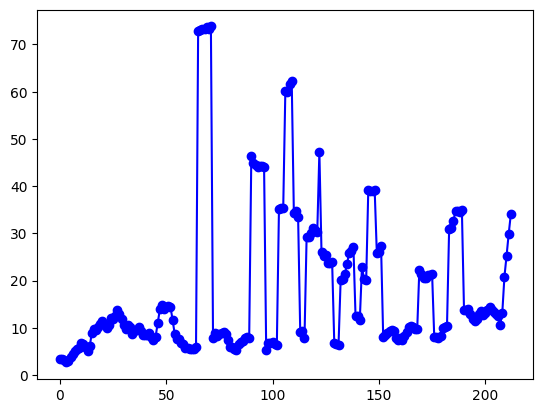

Score:  3874.0
<|im_start|>user
 and a modified version of the Needle-in-a-Haystack where it achieves promising results. To evaluate \kv's impact on RAG, we ran tests on bioasq \cite{bioasq}, multi-hop question answering with HotpotQA \cite{yang2018hotpotqa}, and an internal benchmark on tool use, which further demonstrated its effectiveness. Throughout all experiments, we limit the KV cache to a maximum of 4096 tokens, while the pooling kernel size and window size are set to 13 and 64, respectively. For our evaluations, these hyper-parameters give a KV cache compression ratio between 2x to 32x depending on the sequence length.

\subsubsection{Needle-in-a-Haystack}
In previous experiments \cite{anthropic2023needlesprompt}, it was noted that Needle-in-a-Haystack \cite{kamradt2023needle} evaluation was heavily influenced by the specific context used. To address this issue, we modify the evaluation by permuting context compositions for each length and depth combination. This approach, whi

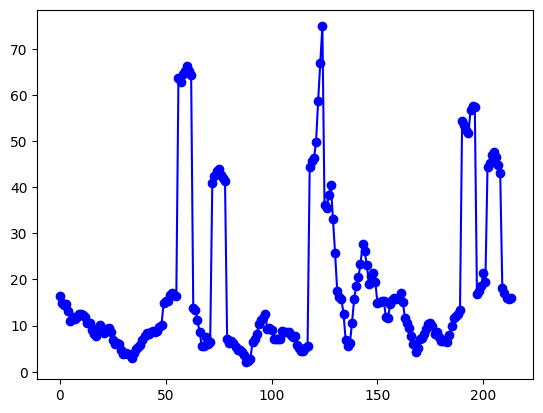

Score:  3828.0
<|im_start|>user
 processing, such as query-key matrix multiplication tiling~\cite{dao2023flash}. By maintaining a constant size for the KV cache associated with prompts during generation, \kv enhances generation efficiency.

Empirical results shown in Figure~\ref{fig: medusa} highlight the performance across various prompt lengths, with \texttt{Mistral-7B-Instruct-v0.2}\footnote{\href{https://huggingface.co/text-generation-inference/Mistral-7B-Instruct-v0.2-medusa/tree/main}{TGI trained \texttt{Medusa} heads}} undergoing a maximum of 128 generation steps unless preemptively halted. The experiments utilized a subset of the QASPER~\cite{dasigi2021dataset}, with a fixed prompt instructing the LLM to summarize the paper. The truncation strategy adopted aligns with LongBench~\cite{bai2023longbench} standards, by removing the context in the middle to achieve the desired sequence length for benchmarking.

The findings indicate a slowdown in \texttt{Medusa}'s performance as seq

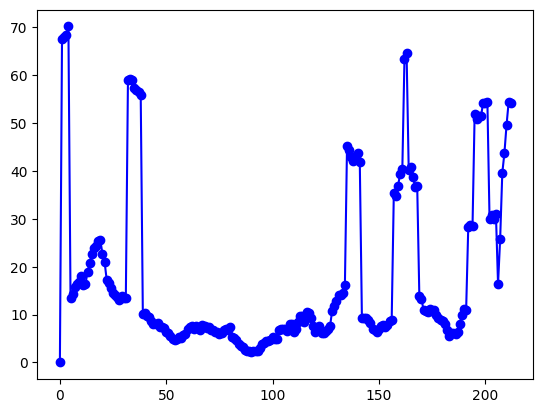

Score:  3782.0
<|im_start|>user
 dotted line denotes the current state-of-the-art open-sourced models' context length.}
    \label{fig: speed}
\end{figure}
\subsubsection{Decoding Speed and Memory Bound}
We further benchmark the speed of \texttt{LWM-Text-Chat-1M} under different batch-size settings using \kv. We set the maximum prompt KV cache size as 2048 for \kv. There are two main takeaways from our experiment on decoding speed and input sequence length on various batch sizes, as shown in Fig. \ref{fig: speed}. First, as the input sequence length increases, the decoding speed of the baseline implementation escalates exponentially. Conversely, the \kv-optimized model maintains a constant decoding speed since the KV cache stays the same and there is no extra update during the inference. For instance, at a sequence length of 16k and a batch size of 2, the decoding time for the baseline model surpasses 0.1 seconds, whereas the \kv-optimized model consistently remains below 0.04 seconds,

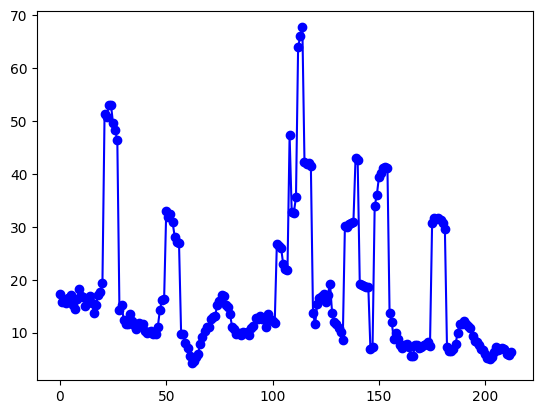

Score:  3760.0
<|im_start|>user
 Difference} \\
\midrule
RAG Citation & F1 score & -1.2\% \\
RAG End-to-end & F1 score & -2.1\% \\
\bottomrule
\end{tabular}
\label{table:commandr_cite}
\end{table}
\paragraph{Generation} \label{Generation_Section}
As the quality of generation is important to a model's RAG capability, we evaluate \texttt{Command-R} on lost-in-the-middle and generation quality. Lost-in-the-middle is aimed to analyze whether the performance of the model varies when altering the position of ground-truth information in the context \cite{lostinthemiddle}. The latter is a relatively simple metric where we define the accuracy of the model to be the proportion of the ground-truth answer phrase appearing in model's response. We conducted 3 experiments with 30, 100 and 200 sampled documents for each ground-truth. We repeat each experiment 3 times and insert the relevant documents at beginning, middle and end of the context to test \kv's robustness.We report the relative difference

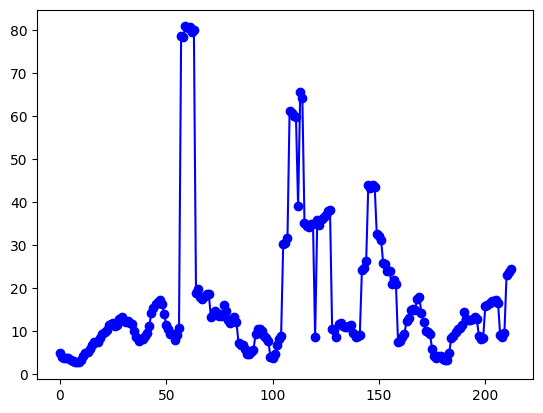

Score:  3758.0
<|im_start|>user
chat~\cite{ding2023enhancing}, a multi-turns, high-quality instruction dataset consisting of 1.4 million dialogues. We further filter the sequences with response length greater than 512 and prompt length greater than 3k. In the experiment, we split the generated tokens into 4 context windows, each spanning 128 tokens, to compute the averaged hit rates of these windows versus the observation window with size 32. According to the findings presented in Fig.\ref{fig: hit_rate}, important keys in prefixes obtained from voting in observation windows exhibit remarkable consistency throughout the generation process, as evidenced by high hit rates. 

\begin{figure}[ht]
    \centering
    \includegraphics[width=0.7\textwidth]{figures/different_answer_pairs.pdf}
    \caption{The layer-wise overlap of important positions utilized by different question-answer pairs in the same dataset.
    }
    \label{fig: qa_pairs}
\end{figure}
\subsection{Observations in Long Docu

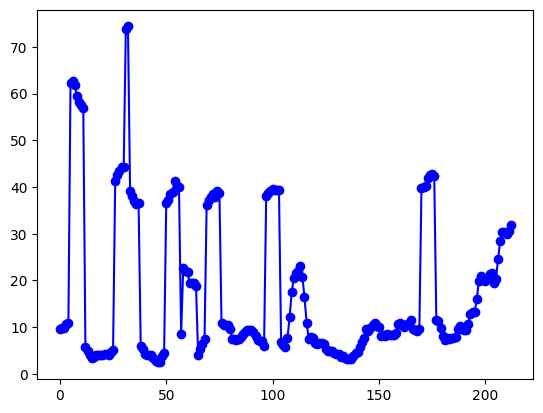

Score:  3748.0
<|im_start|>user
 an interesting aspect of KV cache management in LLMs: the important attention features change with different instructions. This variability challenges the effectiveness of static compression methods that depend on constant weighted importance or fixed policies~\cite{liu2024scissorhands,zhang2024h2o,ge2023model}. Thus, the complex relationship between context and related KV cache emphasizes the need for context-aware compression strategies and highlights the limitations of current methods that ignore this dynamic.
\section{SnapKV}
\label{sec: 4}
\subsection{Basic Method}

In the attention mechanism, keys and values are tensors containing information from the previous context. The linear growth in prompts will lead to exponential time complexity for generation due to the Query-Key matrix multiplication. \kv addresses this by keeping prompt KV cache counts constant during generation, significantly reducing serving times for long-context LLMs.

The fundamen

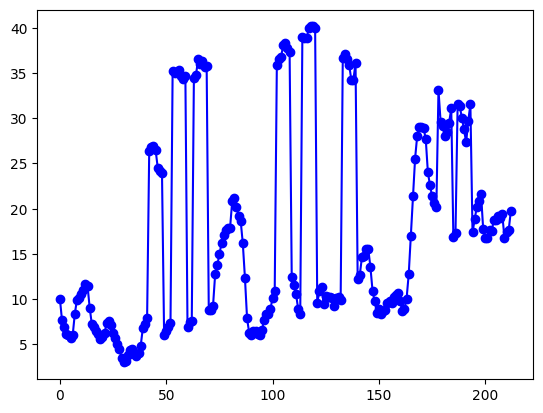

Score:  3738.0
<|im_start|>user
 recognizing and emphasizing important attention features within the context. We can use \(\mathcal{H}(\mathbf{M}_{\text{threshold\_cur}}, \mathbf{M}_{\text{vote\_obs}})\) denote combination of eq.~\ref{eq:stepa} and eq.~\ref{eq:stepb}. We use $p = 0.05$ (top 5\% location per head) and $\theta = 0.05$ (note it is a large value due to the softmax function over a long sequence) for the observation experiments. The model we probe is \texttt{Mistral-7B-Instruct-v0.2}.






\subsection{Observations in Multi-Turn Conversations}
\label{sec: Multi-Turn Conversations}

\begin{figure}[ht]
    \centering
    % \includegraphics[scale = 0.2]{figures/hit_rate_1k.png}
    % \includegraphics[scale = 0.2]{figures/hit_rate_1.5k.png}
    % \includegraphics[scale = 0.2]{figures/scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



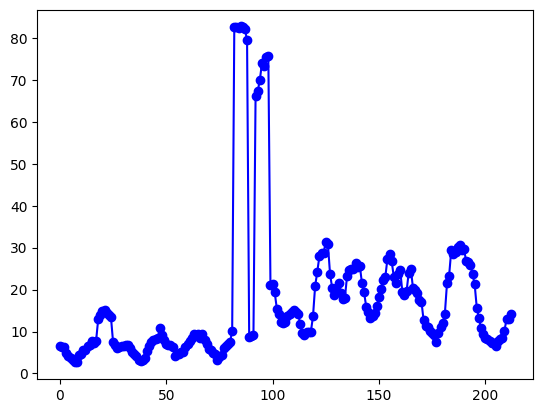

Score:  3738.0
<|im_start|>user
 and then losing the completeness of the information. For example, such compression might cause the LLMs to retrieve only the country code of a phone number and hallucinate the rest. Our experiment also revealed that only selecting the features with the highest weights is insufficient (Sec.~\ref{sec:ablation}).  Such sparse selection risks compromising the contextual integrity encapsulated in between features, thereby reducing accuracy. Based on the insights, We propose a fine-grained clustering algorithm utilizing a pooling layer shown in Line \ref{line:pooling}.
\section{Experiments}
In our experimental setup, we explore the performance of \kv across models that can handle extended sequence contexts. First, we deliver a pressure test and benchmark the speed of \texttt{LWM-Text-Chat-1M}~\cite{liu2024world}, which is state-of-the-art regarding its context length.
We then conduct an ablation study on \texttt{Mistral-7B-Instruct-v0.2} to understand the inf

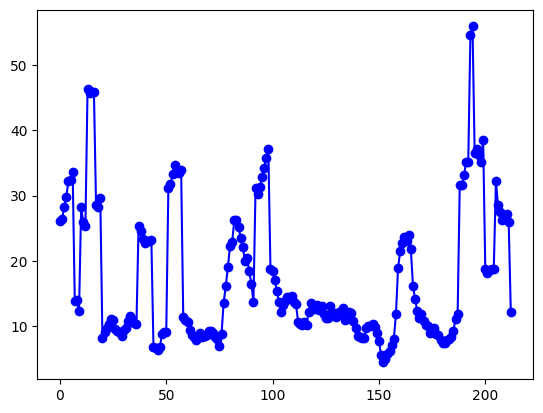

Score:  3736.0
<|im_start|>user
96, it reaches 68\%, all with negligible drops in accuracy.
We compare \kv and H2O on the LongBench dataset to further demonstrate the performance of \kv. To fairly evaluate the accuracy, we set the prompt capacity for H2O to 4096. As table \ref{tab:longbench} shows, \kv delivers significantly better performance than H2O. Even with 1024 prompt KV caches, \kv on \texttt{Mistral-7B-Instruct-v0.2} achieves better performance than H2O with 4096 caches on 11 out of 16 benchmarks. 
\subsection{Experiments on Command-R}
To further assess the performance of \kv, we conduct experiments using Cohere's \texttt{Command-R} model \cite{coherecommandr}, an open-source model with 35B parameters and capable of handling sequences of up to 128k token length. \texttt{Command-R} is designed for complex tasks requiring long context, such as retrieval-augmented generation (RAG). We extensively test \texttt{Command-R} on NarrativeQA and a modified version of the Needlescale lan

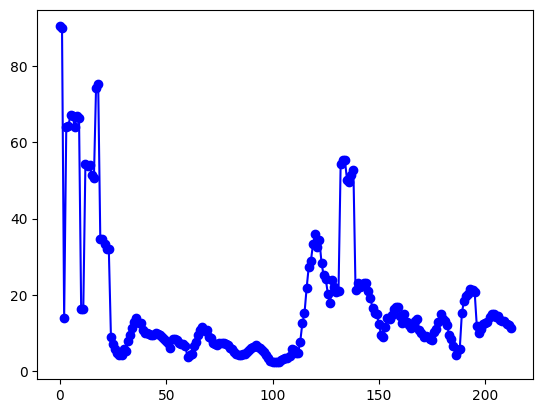

Score:  3724.0
<|im_start|>user
ang2024h2o} introduces a KV cache eviction policy that greedily selects tokens during generation steps based on a scoring function derived from cumulative attention. While this approach effectively compresses the KV cache for generated tokens, it overlooks compression of the input sequence KV cache, which is crucial for reducing memory and computational overhead.
Building on a similar concept, Adaptive KV Compression (FastGen) \cite{ge2023model} implements a dual-phase algorithm that encompasses four KV cache compression policies. Initially, it identifies optimal policies through profiling results obtained from prompt encoding. Subsequently, it dynamically evicts caches during the generation phase based on these policies. Nonetheless, it faces the similar problem with H2O. ScissorHands \cite{liu2024scissorhands} focuses on identifying and retaining pivotal tokens that exhibit a consistent attention weight pattern with previous token windows during genera

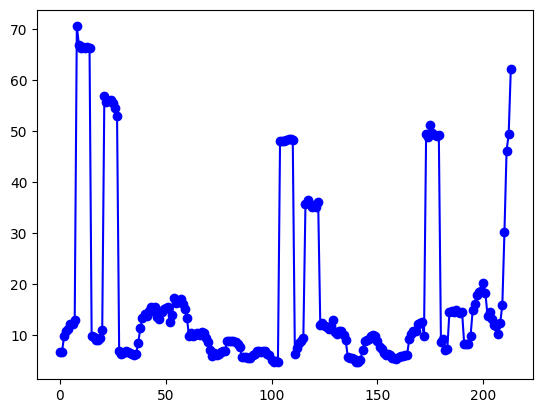

Score:  3724.0
<|im_start|>user
 of extensive length.
Nonetheless, our contributions offer significant insights and tools for the community, paving the way for more refined approaches on managing the challenges of large-\begin{figure}[ht]
    \centering\includegraphics[width=0.65\textwidth]{figures/illustration.pdf}
        \caption{The graph shows the simplified workflow of \kv, where the orange area represents the group of positions per head clustered and selected by \kv. These clustered features are then used to form a new Key-Value pair concatenated with the tokens in the observation window (denoted as `Window'). Together, the selected prefix and observation windows constitute the new KV cache utilized for the generation. 
    }
    \label{fig: algo}
\end{figure}
Many inspiring works have successfully expanded LLMs to handle longer contexts, overcoming the difficulties in context maintenance and attention mechanism scalability, such as GPT-4~\cite{achiam2023gpt} and Command-R~\cite

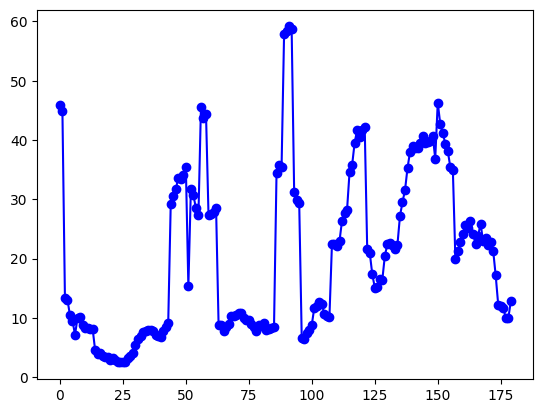

Score:  3674.0
<|im_start|>user
 examine its algorithmic efficiencies through the lens of hardware optimization.

\begin{abstract}
Large Language Models (LLMs) have made remarkable progress in processing extensive contexts, with the Key-Value (KV) cache playing a vital role in enhancing their performance. However, the growth of the KV cache in response to increasing input length poses challenges to memory and time efficiency. To address this problem, this paper introduces \kv, an innovative and fine-tuning-free approach that efficiently minimizes KV cache size while still delivering comparable performance in real-world applications.
We discover that each attention head in the model consistently focuses on specific prompt attention features during generation. Meanwhile, this robust pattern can be obtained from an `observation' window located at the end of the prompts. Drawing on this insight, \kv automatically compresses KV caches by selecting clustered important KV positions for each a

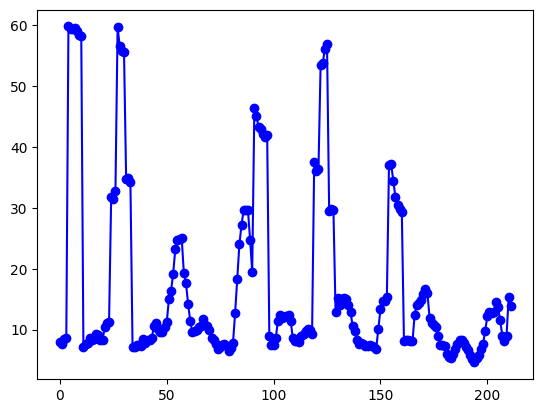

Score:  3638.0
<|im_start|>user
 indicating a strong association with the specific instructions posed by the user (Sec.~\ref{sec: Do Different Questions Matter for One Document?}). Thus, a context-aware KV compression approach can potentially lead to better performance.

\end{enumerate}


To structure our experimental analysis coherently, we introduce the following terminologies:

\textbf{Prompt Length (}\(L_{\text{prompt}}\)\textbf{):} The total length of the user-provided input.
\textbf{Prefix Length (}\(L_{\text{prefix}}\)\textbf{):} The length of the input preceding the observation window. It is part of the prompt and does not include the observation window.
\textbf{Observation Window (}\(L_{\text{obs}}\)\textbf{):} The last segment of the prompt. This window is crucial for analyzing the influence of different contexts on attention patterns.
These definitions are interconnected as follows:
\begin{equation}\label{eq: length}
L_{\text{prompt}} = L_{\text{prefix}} + L_{\text{obs}}
\en

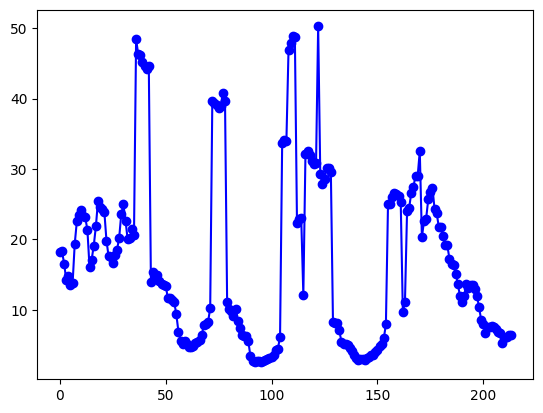

Score:  3618.0
<|im_start|>user
 test \cite{kamradt2023needle} challenges the model to accurately retrieve information from a specific sentence("needle") hidden within a lengthy document (the "haystack"), with the sentence placed at a random location. To rigorously evaluate \kv's capabilities, we extended the document length to 380k tokens which is the longest content that can be processed by a single A100-80GB GPU. We configured the prompt KV cache size to 1024, enabling \kv to select the most crucial 1024 attention features from the prompt using our algorithm for answer generation, with a maximum pooling kernel size of 5 and a observation window size of 16. The compelling outcomes in Fig. \ref{fig: needle} from the Needle-in-a-Haystack test underscore \kv's potential to precisely manage small details on extremely long input contexts with a 380x compression ratio. 
\begin{figure}[ht]
    \centering
        \includegraphics[width=0.9\textwidth]{figures/LWM-Text-Chat-1M_compress.pdf}
  

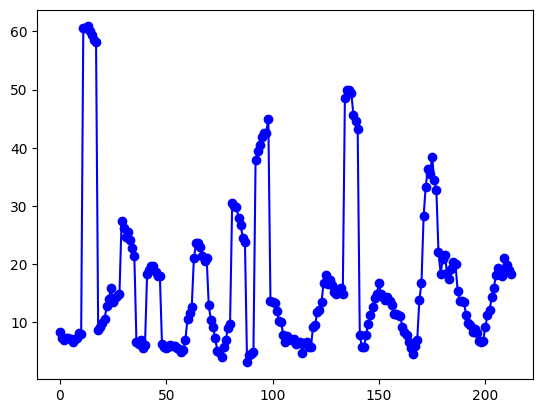

Score:  3608.0
<|im_start|>user
}, incorporating random generated pairs and averaged scores. LongEval-Lines presents a greater challenge compared to Needle-in-a-Haystack because it involves identifying key-value pairs in noisy contexts of the same format, while in Needle-in-a-Haystack, the relevant information is more distinctly separated from other contexts. We apply max pooling with a kernel size of 5 and use the observation window with a size of 16. The findings, illustrated in our results (Fig.~\ref{fig: ablation}), indicate that pooling significantly enhances retrieval accuracy compared to methods not utilizing pooling. We hypothesize that this is due to the ability of strong attention mechanisms to focus on the initial portion of tokens. Without information compression, large language models tend to replicate the subsequent tokens, leading to retrieved partially correct results when the KV cache is compressed as we observed. Note that throughout our experiments, the choice betwee

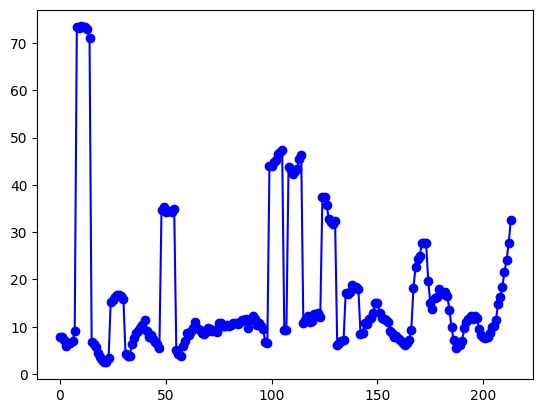

Score:  3604.0
<|im_start|>user
textit{Note:} For each number of sampled documents, we report the approximate context length and the difference from the baseline at each ground-truth position.
\end{table}
As Table \ref{table:commandr_generation} shows, \kv is robust in terms of generation quality and does not suffer from the well-known lost-in-the-middle pathology. Moreover, \kv improves performance over the baseline model when the context contains close to 200 documents. One potential explanation to this is that by adequately compressing the KV cache, we can effectively reduce the noise from negative documents and push the model to construct attention scores more focused on the relevant information.

\paragraph{End-to-End RAG} 
To assess \kv's robustness in a comprehensive manner, we integrated it into a complete RAG pipeline. This evaluation starts by retrieving 200 documents using Cohere's embedding service \cite{cohereembed} in response to a given query. These documents were then r

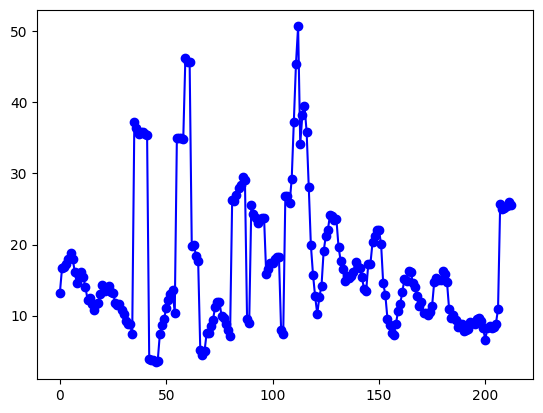

Score:  3572.0
<|im_start|>user
 and prefix keys. The threshold operation filters \(\mathbf{A}_{\text{cur}}\) to retain only values exceeding \(\theta\), indicating significant attention activations. The overlap \(\mathbf{O}\) between these significant activations and the mask \(\mathbf{M}\) quantifies the alignment of the current attention with previously identified significant features. The hit rate \(H\) is then computed as the ratio of the sum of overlap \(\mathbf{O}\) to the sum of significant activations \(\mathbf{A}_{\text{threshold}}\), providing a metric for the efficacy of the attention mechanism in recognizing and emphasizing important attention features within the context. We can use \(\mathcal{H}(\mathbf{M}_{\text{threshold\_cur}}, \mathbf{M}_{\text{vote\_obs}})\) denote combination of eq.~\ref{eq:stepa} and eq.~\ref{eq:stepb}. We use $p = 0.05$ (top 5\% location per head) and $\theta = 0.05$ (note it is a large value due to the softmax function over a long sequence) for t

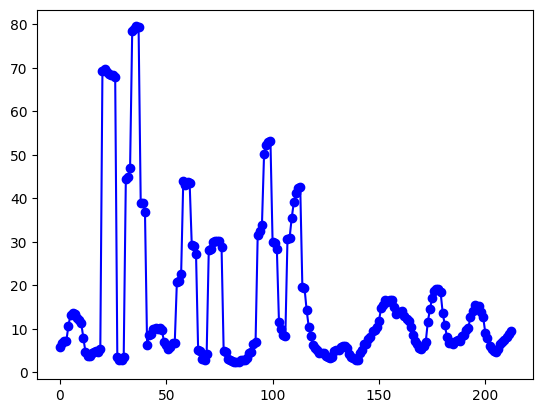

Score:  3562.0
<|im_start|>user
 that \kv can grasp the key information in the long context and give comprehensive summaries with details. Moreover, our results also indicate the effectiveness of \kv in compressing the prompt KV cache. For \texttt{LongChat-7b-v1.5-32k}, the average input token length is 12521; for \texttt{LWM-Text-Chat-1M}, 13422; for Mistral, 13160. Thus, using 1024, \kv achieves an average compression rate of 92\%, and using 4096, it reaches 68\%, all with negligible drops in accuracy.
We compare \kv and H2O on the LongBench dataset to further demonstrate the performance of \kv. To fairly evaluate the accuracy, we set the prompt capacity for H2O to 4096. As table \ref{tab:longbench} shows, \kv delivers significantly better performance than H2O. Even with 1024 prompt KV caches, \kv on \texttt{Mistral-7B-Instruct-v0.2} achieves better performance than H2O with 4096 caches on 11scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



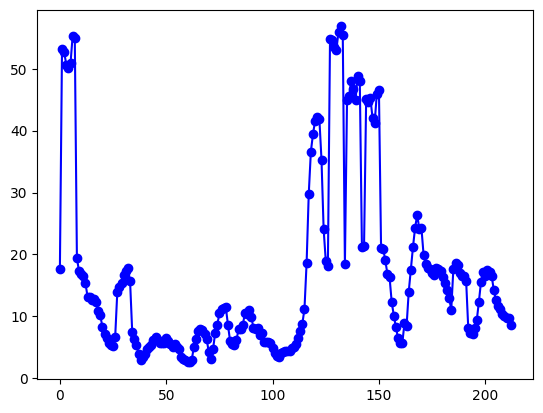

Score:  3550.0
<|im_start|>user
 indices of the top \(k\) values in tensor \(\mathbf{T}\) per head, \(k\) is defined as \(\left\lfloor\textit{p} \times L_{\text{prefix}}\right\rfloor\). The tensor \(\mathbf{W}_{\text{obs}}\in \mathbb{R}^{N \times L_{\text{obs}} \times L_{\text{prefix}}}\) represents the subset of the prompt softmax-normalized attention features over $N$ heads.


\textbf{Hit Rate:} The hit rate, \(H\), quantifies the effectiveness of the voting mechanism by measuring the ratio of attention features identified as significant by the voting process that are also essential in the generation outcome, calculated as:

\begin{align}
\mathbf{M}_{\text{vote\_obs}} &= \text{zeros\_like} (\mathbf{A}_{\text{cur}}) \\
\mathbf{M}_{\text{vote\_obs}}[I] &= 1 \\
\mathbf{M}_{\text{threshold\_cur}} &= \mathbf{1}(\mathbf{A}_{\text{cur}} > \theta) \\
\mathbfscale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



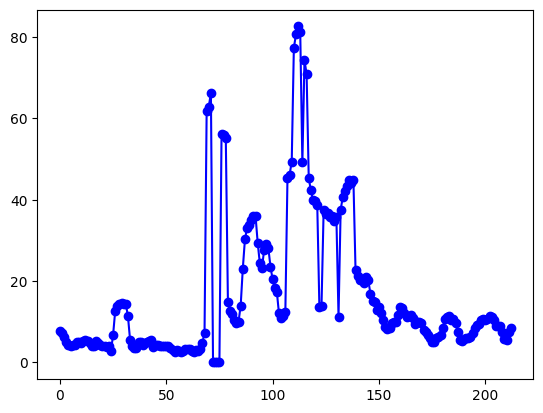

Score:  3544.0
<|im_start|>user
 of the \texttt{Command-R}~\cite{coherecommandr} model, another leading open-source model in the field. Lastly, we show that \kv can be utilized with other acceleration strategies such as parallel decoding.

\subsection{Benchmarks on LWM-Text-Chat-1M}

\texttt{LWM-Text-Chat-1M}~\cite{liu2024world} is a 7B instruction-finetuned model with up to one million context length. In this section, we conduct a pressure test on this model and examine its algorithmic efficiencies through the lens of hardware optimization.

\begin{abstract}
Large Language Models (LLMs) have made remarkable progress in processing extensive contexts, with the Key-Value (KV) cache playing a vital role in enhancing their performance. However, the growth of the KV cache in response to increasing input length poses challenges to memory and time efficiency. To address this problem, this paper introduces \kv, an innovative and fine-tuning-free approach that efficiently minimizes KV cache siz

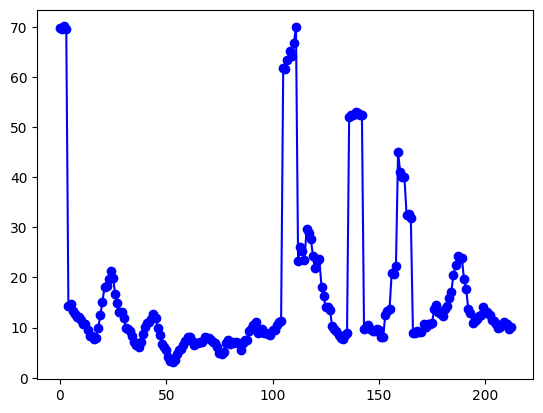

Score:  3490.0
<|im_start|>user
kv. These clustered features are then used to form a new Key-Value pair concatenated with the tokens in the observation window (denoted as `Window'). Together, the selected prefix and observation windows constitute the new KV cache utilized for the generation. 
    }
    \label{fig: algo}
\end{figure}
Many inspiring works have successfully expanded LLMs to handle longer contexts, overcoming the difficulties in context maintenance and attention mechanism scalability, such as GPT-4~\cite{achiam2023gpt} and Command-R~\cite{coherecommandr} with context length 128K, Claude-3~\cite{anthropic2024claude3} with 200K, and Gemini-Pro-1.5 with 1M~\cite{reid2024gemini}. Despite their impressive capabilities, LLMs still face significant challenges when dealing with long context inputs. Specifically, the KV caches in attention calculation become an obstacle in efficiently processing long context. During inference time, as input length increases, the decoding speed per 

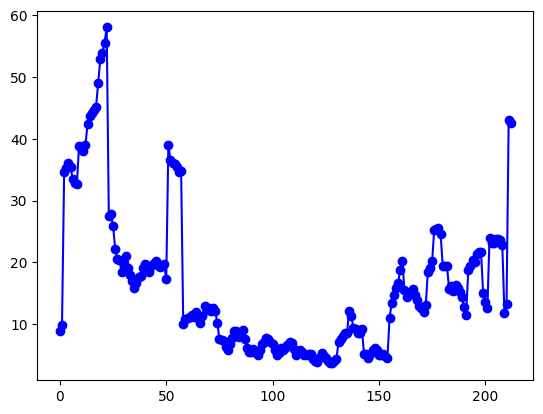

Score:  3484.0
<|im_start|>user
 can handle extended sequence contexts. First, we deliver a pressure test and benchmark the speed of \texttt{LWM-Text-Chat-1M}~\cite{liu2024world}, which is state-of-the-art regarding its context length.
We then conduct an ablation study on \texttt{Mistral-7B-Instruct-v0.2} to understand the influence of pooling on the model's information retrieval performance. We assess model performances using the LongBench~\cite{bai2023longbench} dataset. Further, we dive into a comprehensive examination of the \texttt{Command-R}~\cite{coherecommandr} model, another leading open-source model in the field. Lastly, we show that \kv can be utilized with other acceleration strategies such as parallel decoding.

\subsection{Benchmarks on LWM-Text-Chat-1M}

\texttt{LWM-Text-Chat-1M}~\cite{liu2024world} is a 7B instruction-finetuned model with up to one million context length. In this section, we conduct a pressure test on this model and examine its algorithmic efficiencies 

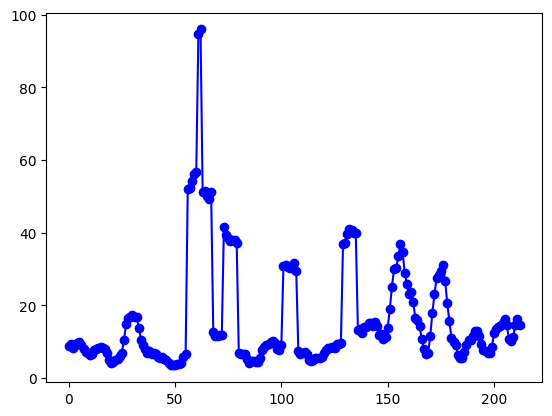

Score:  3458.0
<|im_start|>user
\begin{tabular}{lccc}
\toprule
\text{Model} & \texttt{Command-R} & \texttt{Command-R} + \kv & \text{\% Difference} \\
\midrule
Score & 9.866 & 9.819 & -0.5\% \\
\bottomrule
\end{tabular}
\label{table:commandr_needles}
\end{table}
\subsubsection{Retrieval Augmented Generation (RAG)}
We assess \kv's effectiveness in RAG tasks, which are more intricate than synthetic long-context tasks like Needle-in-a-Haystack and closer to real use cases compared to tasks like NarrativeQA. RAG tasks require selecting pertinent documents from an indexed corpus based on the given prompt. An expanded context window enables the retrieval of additional documents, which can lead to improved model performance. However, this also increases memory requirements and latency, highlighting the delicate balance between retrieval scope and system resources. \kv proves beneficial in these tasks by reducing memory usage while enhancing the performance. We evaluated \kv's impact on RAG tas

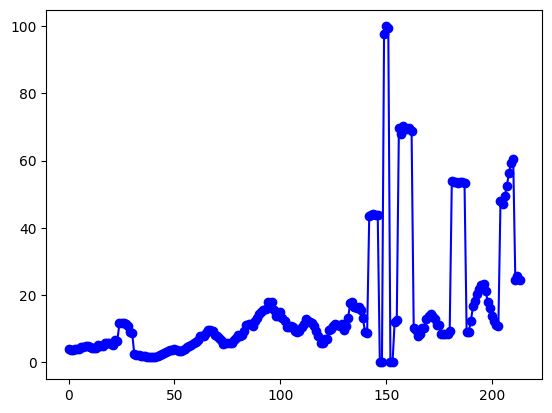

Score:  3428.0
<|im_start|>user
 rate for the responses using the same observation window size of 32 as in the previous experiment. Our results shown in Fig. \ref{fig: question_pos} indicate that across all three datasets, the hit rates are consistently high regardless of whether instructions are positioned before or after extensive supplementary contexts. This consistency suggests that the patterns identified by observation windows are independent of the question's positions.



\subsubsection{Effectiveness of Various Instructions for One Document}
\label{sec: Do Different Questions Matter for One Document?}

Furthermore, we investigate whether instructions will affect the selection of important features even if the provided context is the same. Our experiment utilizes different instructions on the same document and selects the important features based on the observation window that consists of both the instructions and their corresponding responses. Then we calculate the hit rates be

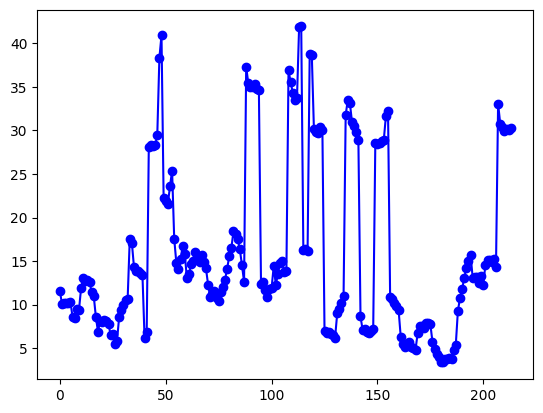

Score:  3340.0
<|im_start|>user
 is aimed to analyze whether the performance of the model varies when altering the position of ground-truth information in the context \cite{lostinthemiddle}. The latter is a relatively simple metric where we define the accuracy of the model to be the proportion of the ground-truth answer phrase appearing in model's response. We conducted 3 experiments with 30, 100 and 200 sampled documents for each ground-truth. We repeat each experiment 3 times and insert the relevant documents at beginning, middle and end of the context to test \kv's robustness.We report the relative difference to the baseline model. The dataset used in this phase is based on the bioasq dataset \cite{bioasq} with RAG-style formulation from Cohere \cite{cohererag}.

\begin{table}[ht]
\centering
\caption{RAG Generation Test Results on bioasq}
\label{table:commandr_generation}
\begin{tabular}{@{}cccc@{}}
\toprule
Number of Documents & Approximate Context Length & Ground Truth Position & 

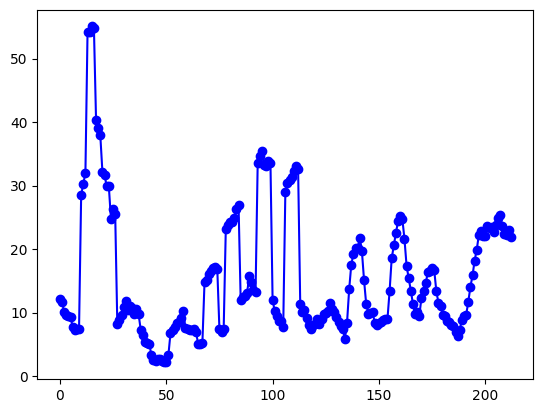

Score:  3332.0
<|im_start|>user
 during generation. Meanwhile, this robust pattern can be obtained from an `observation' window located at the end of the prompts. Drawing on this insight, \kv automatically compresses KV caches by selecting clustered important KV positions for each attention head. Our approach significantly reduces the growing computational overhead and memory footprint when processing long input sequences. Specifically, \kv achieves a consistent decoding speed with a 3.6x increase in generation speed and an 8.2x enhancement in memory efficiency compared to baseline when processing inputs of 16K tokens. At the same time, it maintains comparable performance to baseline models across 16 long sequence datasets. Moreover, \kv can process up to 380K context tokens on a single A100-80GB GPU using HuggingFace implementation with minor changes, exhibiting only a negligible accuracy drop in the Needle-in-a-Haystack test. Further comprehensive studies suggest \kv's potential for 

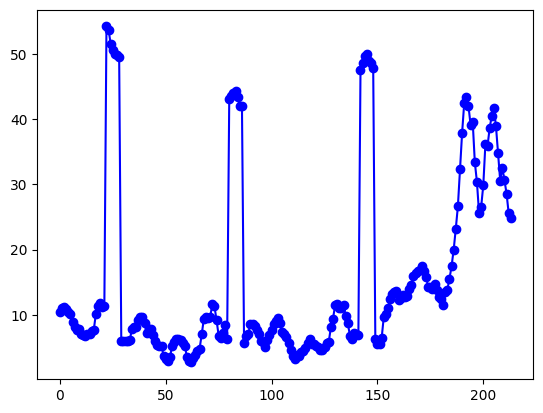

Score:  3308.0
<|im_start|>user
.


\begin{figure}[ht]
    \centering
    \includegraphics[width=0.8\textwidth]{figures/speed_vs_prompt_length.pdf}
    \caption{Comparison of generation speed (ms/token). The baseline is the Huggingface implementation of naive decoding.}
    \label{fig: medusa}
\end{figure}
\subsection{Case Study: Compatibility with Parallel Decoding}

In this section, we provide a novel perspective on employing KV cache compression synergistically with parallel decoding~\cite{stern2018blockwise, leviathan2023fast, chen2023accelerating, miao2023specinfer, zhang2024recurrent}. Parallel decoding leverages a lightweight model or an adaptor to draft initial tokens, which are subsequently verified by larger LLMs. This strategy effectively reduces memory overhead, a critical concern given the autoregressive nature of LLMs that renders them more memory-intensive than computationally demanding. Specifically, in LLMs, each decoding step involves generating a single token, with t

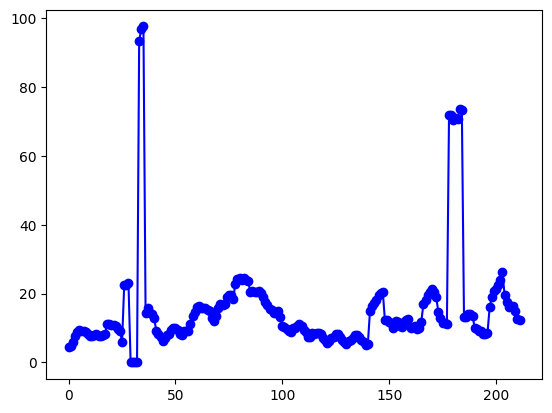

Score:  3302.0
<|im_start|>user
s caches during the generation phase based on these policies. Nonetheless, it faces the similar problem with H2O. ScissorHands \cite{liu2024scissorhands} focuses on identifying and retaining pivotal tokens that exhibit a consistent attention weight pattern with previous token windows during generation steps. However, this method concentrates solely on the window of previous pivotal tokens in generation and neglects the extensive input that contains essential information for generating accurate responses. This oversight could lead to an inability to extract detailed information from prompts.

In summary, existing compression methods merely address the challenges encountered in real-world applications, such as document processing and multi-round chats, where prompts are exceptionally long yet require accurate information retrieval. In common use cases, the generated outputs, like summaries, code pieces, or retrieved data, are significantly shorter compared

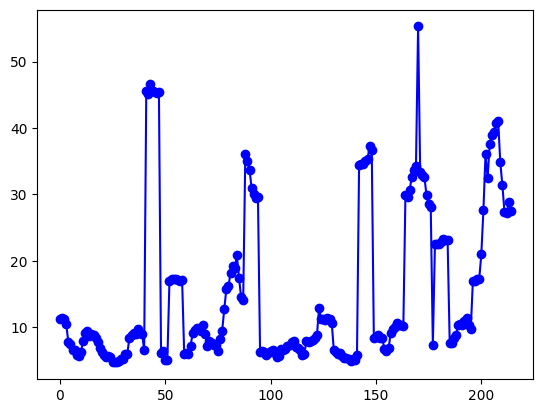

Score:  3288.0
<|im_start|>user


\paragraph{RAG Citation}
We begin by assessing \kv's impact on the model's ability to select relevant documents, a crucial aspect of effective RAG. We evaluate on an internal benchmarks from Cohere. The setup of the benchmark is as follow: for each prompt, we gathered a set of topic-related documents that included ground truth answers along with a sample of negative documents ensuring a total of 100 documents per prompt. We measured the model's performance by calculating the F1-score when the model successfully retrieved the ground truth documents. The dataset employed in this experiment spanned context lengths from 20,000 to 40,000 tokens. Given our KV cache size of 4096, we achieve a compression of 5-10x. As observed in Table \ref{table:commandr_cite}, \kv demonstrates a remarkable ability to retain nearly 98.8\% of \texttt{Command-R}'s performance.
\begin{table}[h]
\centering
\caption{RAG Test Results}
\begin{tabular}{lcc}
\toprule
\text{Evaluation 

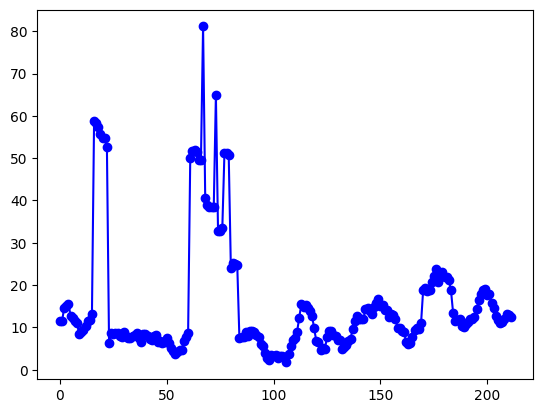

Score:  3280.0
<|im_start|>user
]
    \centering
    \includegraphics[width=0.7\textwidth]{figures/question_front.pdf}
    \includegraphics[width=0.7\textwidth]{figures/question_back.pdf}
    \caption{The layer-wise average hit rate of important positions utilized by prompts with questions at the beginning and the end.}
    \label{fig: question_pos}
\end{figure}

This study examines if the positions of features identified as crucial in the observation window maintain their significance in the subsequent token generation. The analysis utilizes samples from Ultrachat~\cite{ding2023enhancing}, a multi-turns, high-quality instruction dataset consisting of 1.4 million dialogues. We further filter the sequences with response length greater than 512 and prompt length greater than 3k. In the experiment, we split the generated tokens into 4 context windows, each spanning 128 tokens, to compute the averaged hit rates of these windows versus the observation window with size 32. According to the f

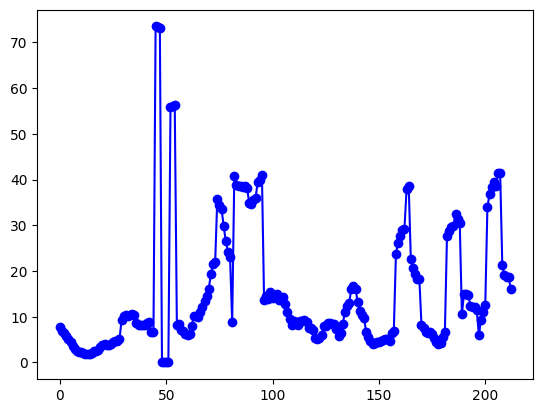

Score:  3272.0
<|im_start|>user
96 caches on 11 out of 16 benchmarks. 
\subsection{Experiments on Command-R}
To further assess the performance of \kv, we conduct experiments using Cohere's \texttt{Command-R} model \cite{coherecommandr}, an open-source model with 35B parameters and capable of handling sequences of up to 128k token length. \texttt{Command-R} is designed for complex tasks requiring long context, such as retrieval-augmented generation (RAG). We extensively test \texttt{Command-R} on NarrativeQA and a modified version of the Needle-in-a-Haystack where it achieves promising results. To evaluate \kv's impact on RAG, we ran tests on bioasq \cite{bioasq}, multi-hop question answering with HotpotQA \cite{yang2018hotpotqa}, and an internal benchmark on tool use, which further demonstrated its effectiveness. Throughout all experiments, we limit the KV cache to a maximum of 4096 tokens, while the pooling kernel size and window size are set to 13 and 64, respectively. For our evalua

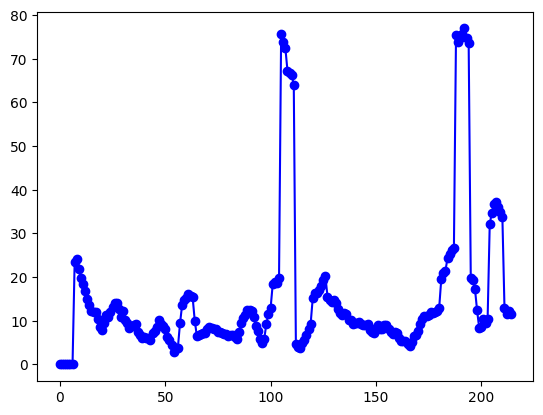

Score:  3182.0
<|im_start|>user
 give a KV cache compression ratio between 2x to 32x depending on the sequence length.

\subsubsection{Needle-in-a-Haystack}
In previous experiments \cite{anthropic2023needlesprompt}, it was noted that Needle-in-a-Haystack \cite{kamradt2023needle} evaluation was heavily influenced by the specific context used. To address this issue, we modify the evaluation by permuting context compositions for each length and depth combination. This approach, which we ran eight times, yielded more robust results. We observe a slight decrease in scores across all models tested under this setting compared to the original setup with no context shuffling. For simplicity, we aggregated the scores across all depths and lengths for the baseline model and the one with \kv. As seen in Table \ref{table:commandr_needles}, applying \kv to \texttt{Command-R} shows no degradation in performance, even with a 128k sequence length resulting in 32x compression of KV cache.

\begin{table}

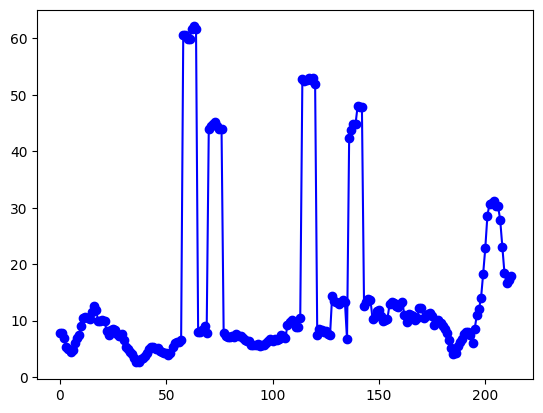

Score:  3178.0
<|im_start|>user
 > \theta) \\
\mathbf{O} &= \mathbf{M}_{\text{threshold\_cur}} \land \mathbf{M}_{\text{vote\_obs}} \label{eq:stepa}\\
H &= \frac{\sum \mathbf{O}}{\sum \mathbf{M}_{\text{threshold\_cur}}} \label{eq:stepb}
\end{align}


\(\mathbf{A}_{\text{cur}}\in \mathbb{R}^{N \times L_{\text{prefix}}}\) represents the attention features between the current generated query and prefix keys. The threshold operation filters \(\mathbf{A}_{\text{cur}}\) to retain only values exceeding \(\theta\), indicating significant attention activations. The overlap \(\mathbf{O}\) between these significant activations and the mask \(\mathbf{M}\) quantifies the alignment of the current attention with previously identified significant features. The hit rate \(H\) is then computed as the ratio of the sum of overlap \(\mathbf{O}\) to the sum of significant activations \(\mathbf{A}_{\text{threshold}}\), providing a metric for the efficacy of the attention mechanism in recognizing and emphasizi

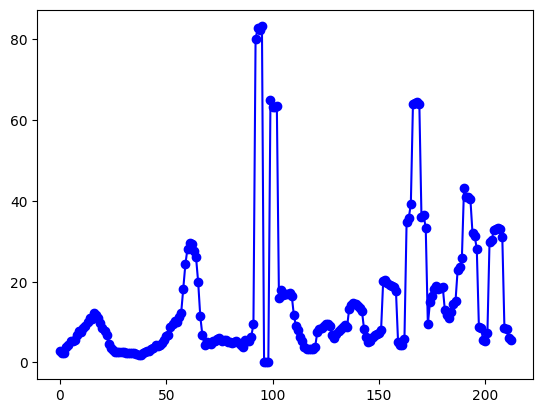

Score:  3140.0
<|im_start|>user
 Meanwhile, the original implementation encounters OOM error with 33k input tokens.
    }
    \label{fig: needle}
\end{figure}
\begin{figure}[ht]
    \centering
    \includegraphics[width=0.8\textwidth]{figures/benchmark.pdf}
    \caption{Deconding speed comparison of baseline implementation and \kv optimized solutions on various batch sizes. The x-axis denotes the input sequence length; the y-axis indicates decoding speed (ms/token). All experiments are conducted on an A100 80GB GPU. The red dotted line denotes the current state-of-the-art open-sourced models' context length.}
    \label{fig: speed}
\end{figure}
\subsubsection{Decoding Speed and Memory Bound}
We further benchmark the speed of \texttt{LWM-Text-Chat-1M} under different batch-size settings using \kv. We set the maximum prompt KV cache size as 2048 for \kv. There are two main takeaways from our experiment on decoding speed and input sequence length on various batch sizes, as shown in Fig. \

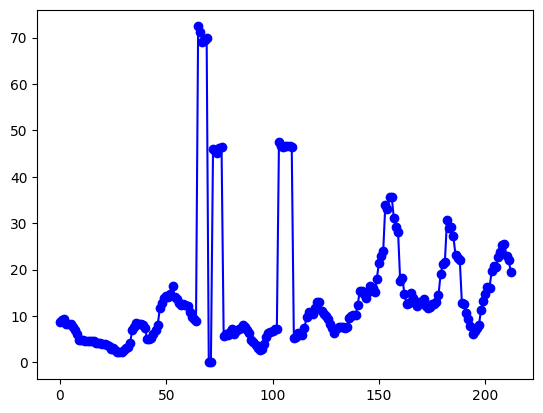

Score:  3128.0
<|im_start|>user
, as the input sequence length increases, the decoding speed of the baseline implementation escalates exponentially. Conversely, the \kv-optimized model maintains a constant decoding speed since the KV cache stays the same and there is no extra update during the inference. For instance, at a sequence length of 16k and a batch size of 2, the decoding time for the baseline model surpasses 0.1 seconds, whereas the \kv-optimized model consistently remains below 0.04 seconds, achieving approximately a 3.6x speedup. Second, with the same batch size, the model optimized with \kv can decode significantly longer sequences. For example, at a batch size of 2, the baseline model encounters an OOM issue beyond 16k input tokens, whereas the \kv-enhanced model extends this limit to 131k input tokens, indicating an approximately 8.2x improvement. This demonstrates \kv's effectiveness in minimizing memory consumption.
\subsection{Ablation Study of Effectiveness of Poolin

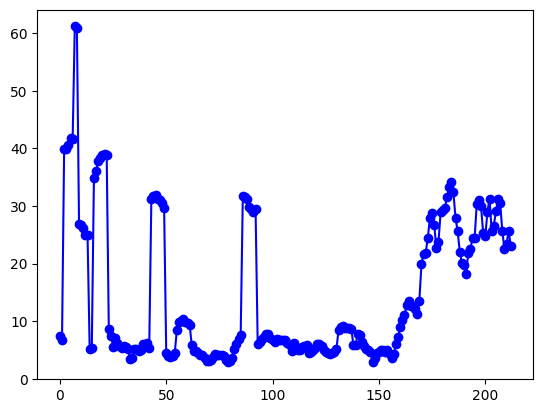

Score:  3100.0
<|im_start|>user
 on-chip and off-chip memory, increasing hardware demands and limiting model scalability.

There are many perspectives to mitigate these problems, including KV cache eviction during token generation~\cite{xiao2023efficient, zhang2024h2o, liu2024scissorhands, ge2023model}. However, most of these methods lack a detailed evaluation of the generated context in a long-context setting. Moreover, they mainly focus on optimizing the KV cache appended during generation steps, while overlooking the realistic problem of compressing KV cache for input sequences, which is typically the bottleneck in memory efficiency. In practical applications such as chatbots and agents, where inputs can be multi-turn conversations, extensive articles or codebases~\cite{achiam2023gpt, liu2021lifelong, bairi2023codeplan}, input sizes are often much larger than the sizes of generated responses, resulting in significant overhead. Additional challenge lies in compressing such vast input

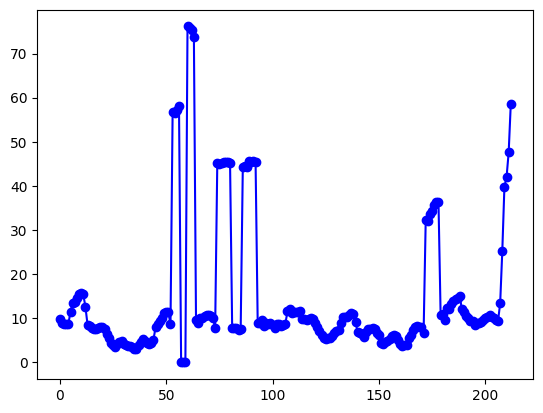

Score:  3090.0
<|im_start|>user
 longer sequences. For example, at a batch size of 2, the baseline model encounters an OOM issue beyond 16k input tokens, whereas the \kv-enhanced model extends this limit to 131k input tokens, indicating an approximately 8.2x improvement. This demonstrates \kv's effectiveness in minimizing memory consumption.
\subsection{Ablation Study of Effectiveness of Pooling}\label{sec:ablation}
\begin{figure}[ht]
    \centering
    \includegraphics[width=0.9\textwidth]{figures/Mistral-7B-Instruct-v0.2_nopool.pdf}
    \includegraphics[width=0.9\textwidth]{figures/Mistral-7B-Instruct-v0.2_maxpool.pdf}
    \caption{Ablation study of pooling on LongEval-Lines. The evaluation includes inputs, each comprised of lines formatted as "\texttt{line makeshift-penguin: REGISTER\_CONTENT is <10536>}", where the key is an adjective-noun pair and the value is a random 5-digit number. The model needs to retrieve the value based on a given key.scale language modeling.

What is the 

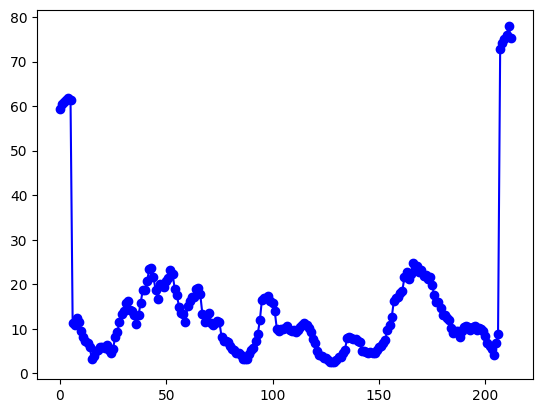

Score:  3048.0
<|im_start|>user
, as evidenced by high hit rates. 

\begin{figure}[ht]
    \centering
    \includegraphics[width=0.7\textwidth]{figures/different_answer_pairs.pdf}
    \caption{The layer-wise overlap of important positions utilized by different question-answer pairs in the same dataset.
    }
    \label{fig: qa_pairs}
\end{figure}
\subsection{Observations in Long Document QA}
To further validate this finding, we also observe on multiple long documents QA datasets including QMSum \cite{zhong2021qmsum}, a query-based multi-domain meeting summarization; Openreview \cite{an2023eval}, a collection of papers from \texttt{openreview.net}; SPACE \cite{angelidis2021extractive}, an extractive opinion summarization in quantized transformer spaces.


\subsubsection{Effectiveness of Instruction Positions}
\label{sec: Do Question Positions Matter?}
Our investigation also extends to the significance of instruction positioning on the interpretability of LLMs and their selection of impo

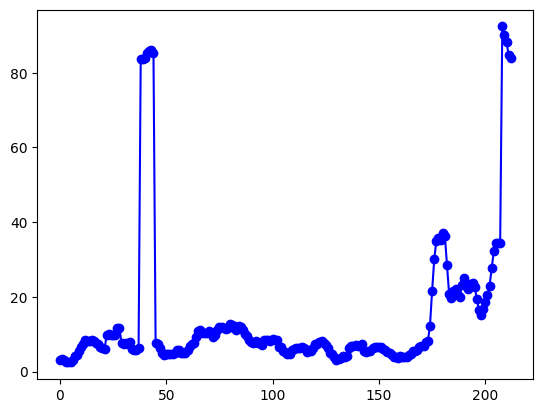

Score:  3046.0
<|im_start|>user
pt}



\end{tabular}

}
\begin{tablenotes}
    \scriptsize
    \item[] \hspace{-20pt}\textsuperscript{a} Credit to Jin et al.~\cite{jin2024llm} for the template used in the table.
\end{tablenotes}
\end{threeparttable}\vspace{-10pt}

\end{table*}

\subsection{Experiments on LongBench}
We evaluate \kv on these four models using LongBench~\cite{bai2023longbench}, a multi-task benchmark designed to rigorously evaluate long context understanding capabilities across various datasets, spanning single and multi-document QA, summarization, few-shot learning, synthetic tasks, and code completion. We choose \texttt{LWM-Text-Chat-1M} with 1 million context length, \texttt{LongChat-7b-v1.5-32k}, \texttt{Mistral-7B-Instruct-v0.2}, \texttt{Mixtral-8x7B-Instruct-v0.1} with 3scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



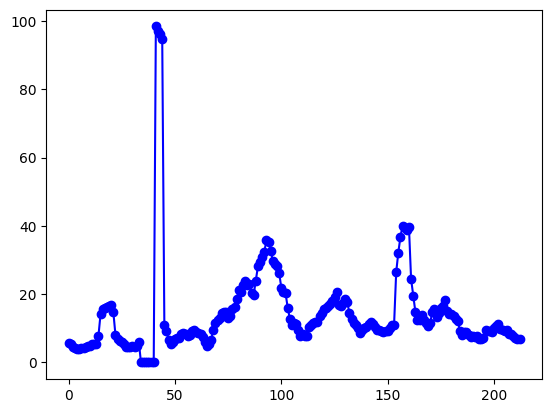

Score:  3036.0
<|im_start|>user
 the value based on a given key. 
    The x-axis denotes the length of the input; the y-axis indicates the position of the groundtruth, from 5K to 30K tokens. With the pooling, the model can retrieve correct values before 16k and performs significantly better than the one without pooling.
    }
    \label{fig: ablation}
\end{figure}
We perform an ablation study to assess the impact of our pooling technique, a straightforward but efficient method for consolidating information through clustering. Our evaluation utilizes the modified LongEval-Lines benchmark~\cite{longchat2023}, incorporating random generated pairs and averaged scores. LongEval-Lines presents a greater challenge compared to Needle-in-a-Haystack because it involves identifying key-value pairs in noisy contexts of the same format, while in Needle-in-a-Haystack, the relevant information is more distinctly separated from other contexts. We apply max pooling with a kernel size of 5 and use the o

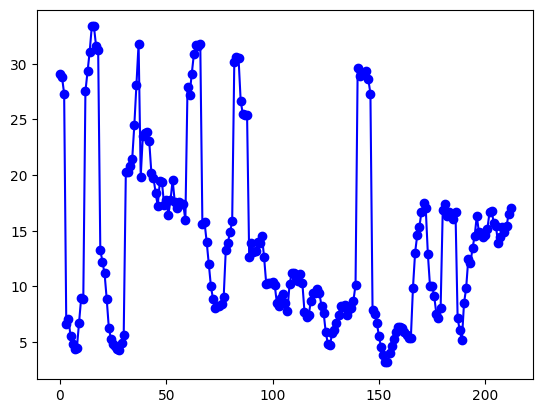

Score:  3030.0
<|im_start|>user
 construct attention scores more focused on the relevant information.

\paragraph{End-to-End RAG} 
To assess \kv's robustness in a comprehensive manner, we integrated it into a complete RAG pipeline. This evaluation starts by retrieving 200 documents using Cohere's embedding service \cite{cohereembed} in response to a given query. These documents were then re-ranked using Cohere's re-ranking model \cite{coherererank}, which filtered out half of the candidates, resulting in a list of 100 documents. We prompt \texttt{Command-R} using this list and calculate the accuracy metric as described in Section \ref{Generation_Section}. We employed a modified version of the HotpotQA dataset \cite{yang2018hotpotqa} and leveraged Wikipedia as the document source. This setup introduces a more challenging set of documents as all documents, relevant or not, are semantically similar.
Table \ref{table:commandr_cite} showcases \kv's robust performance in a production-like RA

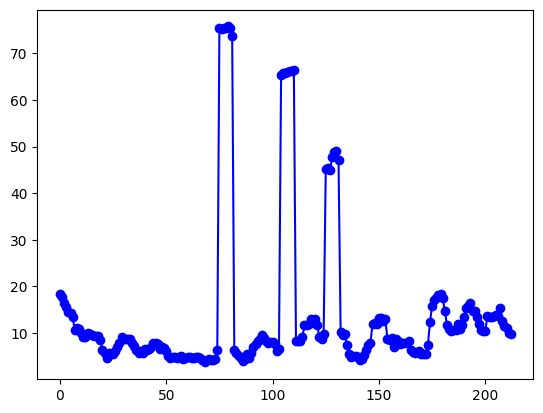

Score:  2926.0
<|im_start|>user
 = indices.unsqueeze(-1).expand(-1, -1, -1, head_dim)
        # Gather the compressed past key and value states based on the selected indices.
        k_past_compress = key_states[..., :-window_size, :].gather(dim=2, index=indices)
        v_past_compress = value_states[..., :-window_size, :].gather(dim=2, index=indices)
        k_obs = key_states[..., -window_size:, :]
        v_obs = value_states[..., -window_size:, :]
        key_states = torch.cat([k_past_compress, k_obs], dim=2)
        value_states = torch.cat([v_past_compress, v_obs], dim=2)
        return key_states, value_states
\end{lstlisting}


\subsection{Efficient Clustering via Pooling}
\label{sec: clustering}
In LLMs, information retrieval and generation rely on features with high attention weight and are supplemented by copying the rest in context using induction heads~\cite{olsson2022context}. Hence, naively selecting the top features results in retaining only portions of details and th

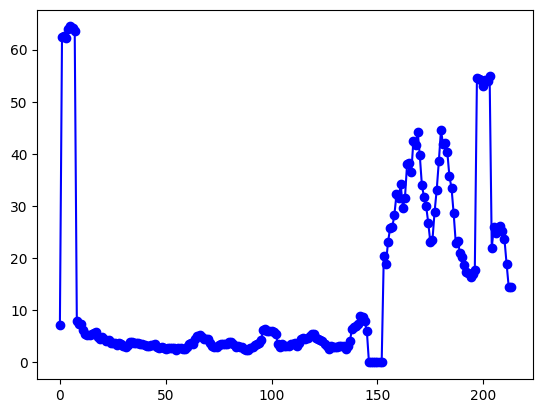

Score:  2856.0
<|im_start|>user
 this list and calculate the accuracy metric as described in Section \ref{Generation_Section}. We employed a modified version of the HotpotQA dataset \cite{yang2018hotpotqa} and leveraged Wikipedia as the document source. This setup introduces a more challenging set of documents as all documents, relevant or not, are semantically similar.
Table \ref{table:commandr_cite} showcases \kv's robust performance in a production-like RAG setting. With an average dataset length of around 16,000 tokens, the KV cache benefits from a compression ratio of approximately 4x.


\begin{figure}[ht]
    \centering
    \includegraphics[width=0.8\textwidth]{figures/speed_vs_prompt_length.pdf}
    \caption{Comparison of generation speed (ms/token). The baseline is the Huggingface implementation of naive decoding.}
    \label{fig: medusa}
\end{figure}
\subsection{Case Study: Compatibility with Parallel Decoding}

In this section, we provide a novel perspective on employing KV c

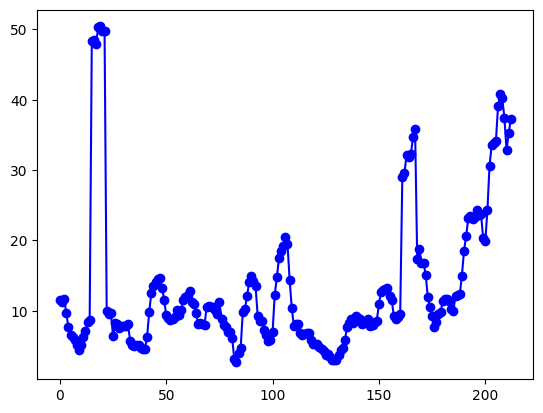

Score:  2842.0
<|im_start|>user
 the window features, which encompass all features containing prompt information. We store back the concatenated KV caches for later use in generation and save the memory usage.

\end{itemize}
\begin{lstlisting}[language=Python, escapechar=|, caption=Implementation of \kv in pseudo PyTorch style.]
def snap_kv(query_states, key_states, value_states, window_size, max_capacity_prompt, kernel_size):
    bsz, num_heads, q_len, head_dim = query_states.shape
    # Ensure it is the prompt phase.
    assert key_states.shape[-2] == query_states.shape[-2]
    if q_len < max_capacity_prompt:
        return key_states, value_states
    else:
        # Compute attention weights of observing window's queries and prefix context's Keys.
        attn_weights = compute_attn(query_states[..., -window_size:, :], key_states, attention_mask) 
        # (bsz, num_heads, window_size, k_len)
        # Sum the weight along the query dimension.
        attn_weights_sum = attn_weigh

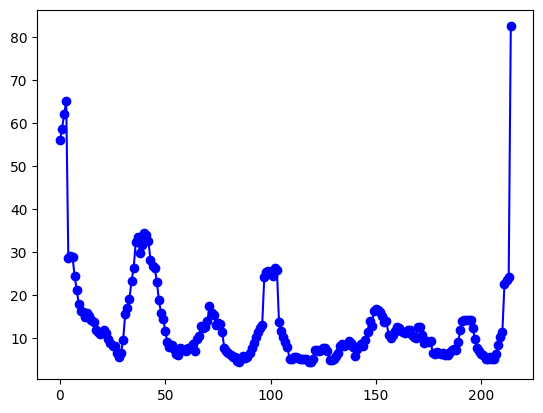

Score:  2830.0
<|im_start|>user
):} The length of the input preceding the observation window. It is part of the prompt and does not include the observation window.
\textbf{Observation Window (}\(L_{\text{obs}}\)\textbf{):} The last segment of the prompt. This window is crucial for analyzing the influence of different contexts on attention patterns.
These definitions are interconnected as follows:
\begin{equation}\label{eq: length}
L_{\text{prompt}} = L_{\text{prefix}} + L_{\text{obs}}
\end{equation}
\textbf{Voting:} The process of calculating attention weights for each query within the observation window across all heads, aggregating these weights to highlight the prefix positions that are considered most significant.

For a single batch of sequence, formally:
\begin{align}
\mathbf{C} &= \sum_{i=0}^{L_{\text{obs}}} \mathbf{W}_{\text{obs}}[:, i, :] \\
I &= \text{Top}_k(\mathbf{C}, k)
\end{align}

where \(\text{Top}_k(\mathbf{T}, k)\) selects the indices of the top \(k\scale language mod

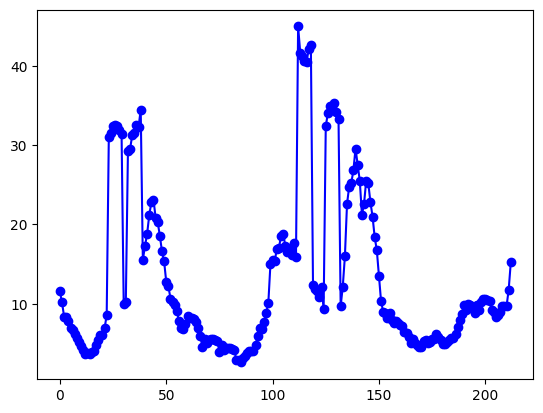

Score:  2784.0
<|im_start|>user
 ability of strong attention mechanisms to focus on the initial portion of tokens. Without information compression, large language models tend to replicate the subsequent tokens, leading to retrieved partially correct results when the KV cache is compressed as we observed. Note that throughout our experiments, the choice between max pooling and average pooling did not yield significant differences in performance.
\begin{table*}[t]

\fontsize{18}{24}\selectfont
\setlength{\tabcolsep}{5pt}
\centering
\caption{Performance comparison of \kv and H2O across various LLMs on LongBench.}\label{tab:longbench}
\begin{threeparttable}
\scalebox{0.3}{
\begin{tabular}{l|lcccccccccccccccc}
\specialrule{1pt}{0pt}{2pt}
&\multirow{4}{*}{~~~LLMs\tnote{a}} & \multicolumn{3}{c}{Single-Document QA} & \multicolumn{3}{c}{Multi-Document QA}& \multicolumn{3}{c}{Summarization}& \multicolumn{3}{c}{Few-shotscale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>


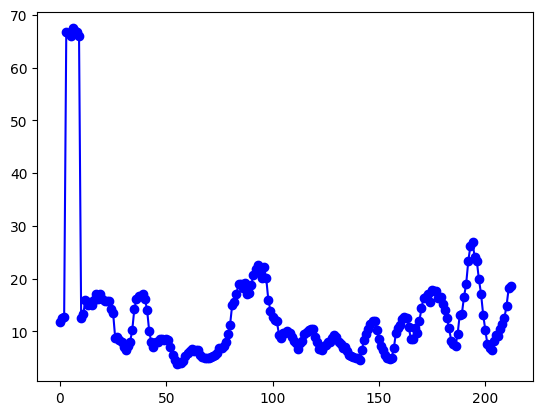

Score:  2774.0
<|im_start|>user
 same. Our experiment utilizes different instructions on the same document and selects the important features based on the observation window that consists of both the instructions and their corresponding responses. Then we calculate the hit rates between important features selected by different instruction-response pairs within the same document by using \(\mathcal{H}(\text{M}_{\text{vote\_A}}, \text{M}_{\text{vote\_B}})\). By varying the instructions, we observe that different instructions prioritize different prefix keys, as indicated by the descending trend in hit rates shown in Fig. \ref{fig: qa_pairs}. 
Our findings reveal an interesting aspect of KV cache management in LLMs: the important attention features change with different instructions. This variability challenges the effectiveness of static compression methods that depend on constant weighted importance or fixed policies~\cite{liu2024scissorhands,zhang2024h2o,ge2023model}. Thus, the complex

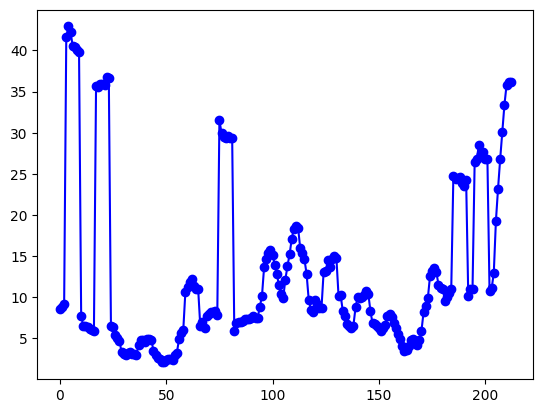

Score:  2750.0
<|im_start|>user
.
    assert key_states.shape[-2] == query_states.shape[-2]
    if q_len < max_capacity_prompt:
        return key_states, value_states
    else:
        # Compute attention weights of observing window's queries and prefix context's Keys.
        attn_weights = compute_attn(query_states[..., -window_size:, :], key_states, attention_mask) 
        # (bsz, num_heads, window_size, k_len)
        # Sum the weight along the query dimension.
        attn_weights_sum = attn_weights[..., -window_size:, :-window_size].sum(dim=-2)
        # Apply 1D pooling for clustering.
        attn_cache = pool1d(attn_weights_sum, kernel_size=kernel_size, padding=kernel_size//2, stride=1) |\label{line:pooling}|
        # Select top-k indices per head based on the pooled weights to identify important positions.
        indices = attn_cache.topk(max_capacity_prompt - window_size, dim=-1).indices
        # Expand the indices to match the head dimension for gathering.
        indi

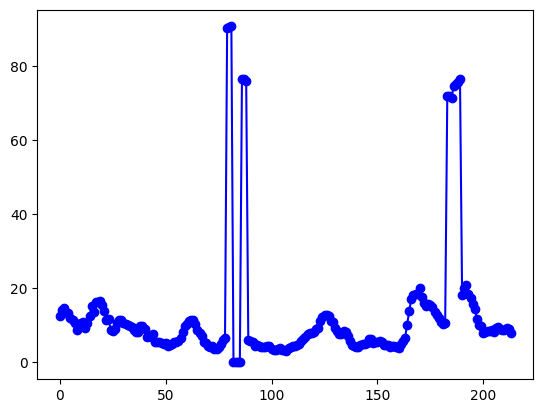

Score:  2678.0
<|im_start|>user
window_size:, :-window_size].sum(dim=-2)
        # Apply 1D pooling for clustering.
        attn_cache = pool1d(attn_weights_sum, kernel_size=kernel_size, padding=kernel_size//2, stride=1) |\label{line:pooling}|
        # Select top-k indices per head based on the pooled weights to identify important positions.
        indices = attn_cache.topk(max_capacity_prompt - window_size, dim=-1).indices
        # Expand the indices to match the head dimension for gathering.
        indices = indices.unsqueeze(-1).expand(-1, -1, -1, head_dim)
        # Gather the compressed past key and value states based on the selected indices.
        k_past_compress = key_states[..., :-window_size, :].gather(dim=2, index=indices)
        v_past_compress = value_states[..., :-window_size, :].gather(dim=2, index=indices)
        k_obs = key_states[..., -window_size:, :]
        v_obs = value_states[..., -window_size:, :]
        key_states = torch.cat([k_past_compress, k_scale l

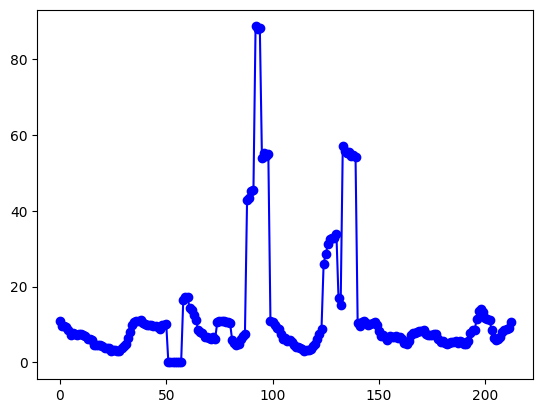

Score:  2616.0
<|im_start|>user
 is \texttt{Mistral-7B-Instruct-v0.2}.






\subsection{Observations in Multi-Turn Conversations}
\label{sec: Multi-Turn Conversations}

\begin{figure}[ht]
    \centering
    % \includegraphics[scale = 0.2]{figures/hit_rate_1k.png}
    % \includegraphics[scale = 0.2]{figures/hit_rate_1.5k.png}
    % \includegraphics[scale = 0.2]{figures/hit_rate_2k.png}
    % \includegraphics[scale = 0.2]{figures/hit_rate_2.5k.png}
    \includegraphics[width=0.7\textwidth]{figures/hit_rate_3k.pdf}
    \caption{
    The layer-wise average hit rate of important positions utilized along token generation with an average input length exceeding 3k.
    }
    \label{fig: hit_rate}
\end{figure}

\begin{figure}[ht]
    \centering
    \inscale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



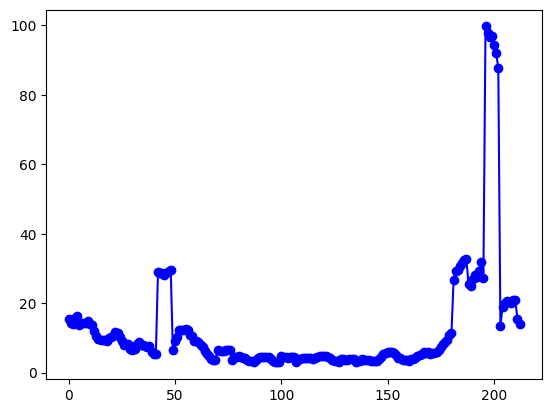

Score:  2582.0
<|im_start|>user
 pattern?
        \item Does the nature of the user's instructions play a role in shaping these attention patterns?
    \end{enumerate}
    Our finding suggests that most of the LLMs' attention allocation of input sequence remains unchanged during generation. Thus, \textit{LLMs knows what you are looking for before generation}.
    \item We develop an efficient algorithm, \kv, inspired and validated by extensive observations and testing. \kv intelligently identifies important KVs with minimal modification (See Fig.~\ref{fig: algo}). The algorithm can be easily integrated into popular deep-learning frameworks with just a few code adjustments.

    \item We evaluate \kv for accuracy and efficiency across diverse LLMs and long-sequence datasets, affirming its improvement over previous work and comparability to conventional KV caching. Furthermore, we conduct the Needle-in-a-Haystack test to demonstrate its memory efficiency and illustrate decoding speed enh

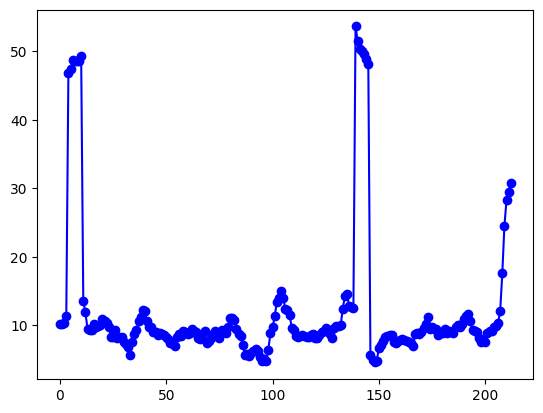

Score:  2516.0
<|im_start|>user
:} The process of calculating attention weights for each query within the observation window across all heads, aggregating these weights to highlight the prefix positions that are considered most significant.

For a single batch of sequence, formally:
\begin{align}
\mathbf{C} &= \sum_{i=0}^{L_{\text{obs}}} \mathbf{W}_{\text{obs}}[:, i, :] \\
I &= \text{Top}_k(\mathbf{C}, k)
\end{align}

where \(\text{Top}_k(\mathbf{T}, k)\) selects the indices of the top \(k\) values in tensor \(\mathbf{T}\) per head, \(k\) is defined as \(\left\lfloor\textit{p} \times L_{\text{prefix}}\right\rfloor\). The tensor \(\mathbf{W}_{\text{obs}}\in \mathbb{R}^{N \times L_{\text{obs}} \times L_{\text{prefix}}}\) represents the subset of the prompt softmax-normalized attention features over $N$ heads.


\textbf{Hit Rate:} The hit rate, \(H\), quantifies thescale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



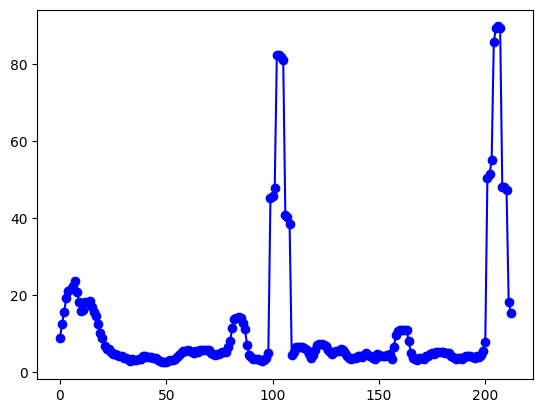

Score:  2408.0
<|im_start|>user
origin=c]{30}{TREC} & \rotatebox[origin=c]{30}{TriviaQA} & \rotatebox[origin=c]{30}{SAMSum} & \rotatebox[origin=c]{30}{PCount} & \rotatebox[origin=c]{30}{PRe} & \rotatebox[origin=c]{30}{Lcc} & \rotatebox[origin=c]{30}{RB-P} \\

\specialrule{1pt}{2pt}{2pt}

\multirow{5}{*}{\rotatebox[origin=c]{90}{\fontsize{18}{100}\selectfont LWMChat}}

&\cellcolor{green!10}~~~All KV & \cellcolor{green!10}\textbf{18.18}&\cellcolor{green!10}\textbf{25.56}&\cellcolor{green!10} 40.94 &\cellcolor{green!10} 24.57 &\cellcolor{green!10} 19.39&\cellcolor{green!10} 10.scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



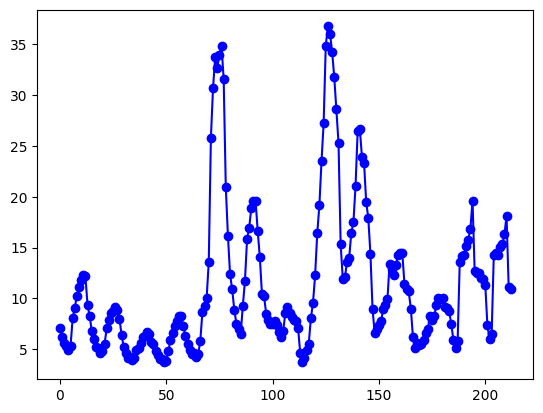

Score:  2354.0
<|im_start|>user
 a slight decrease in scores across all models tested under this setting compared to the original setup with no context shuffling. For simplicity, we aggregated the scores across all depths and lengths for the baseline model and the one with \kv. As seen in Table \ref{table:commandr_needles}, applying \kv to \texttt{Command-R} shows no degradation in performance, even with a 128k sequence length resulting in 32x compression of KV cache.

\begin{table}[h]
\centering
\caption{Needles-in-a-Haystack Test Results}
\begin{tabular}{lccc}
\toprule
\text{Model} & \texttt{Command-R} & \texttt{Command-R} + \kv & \text{\% Difference} \\
\midrule
Score & 9.866 & 9.819 & -0.5\% \\
\bottomrule
\end{tabular}
\label{table:commandr_needles}
\end{table}
\subsubsection{Retrieval Augmented Generation (RAG)}
We assess \kv's effectiveness in RAG tasks, which are more intricate than synthetic longscale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



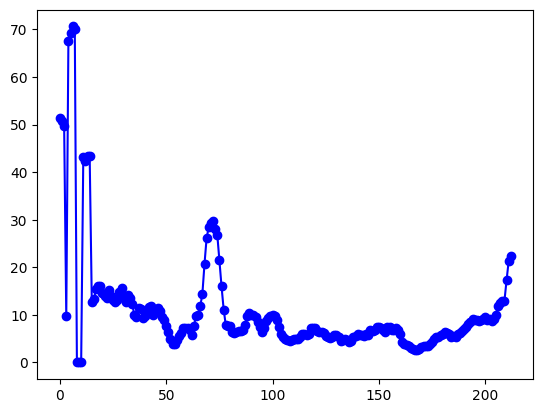

Score:  2284.0
<|im_start|>user
 0.2]{figures/hit_rate_2k.png}
    % \includegraphics[scale = 0.2]{figures/hit_rate_2.5k.png}
    \includegraphics[width=0.7\textwidth]{figures/hit_rate_3k.pdf}
    \caption{
    The layer-wise average hit rate of important positions utilized along token generation with an average input length exceeding 3k.
    }
    \label{fig: hit_rate}
\end{figure}

\begin{figure}[ht]
    \centering
    \includegraphics[width=0.7\textwidth]{figures/question_front.pdf}
    \includegraphics[width=0.7\textwidth]{figures/question_back.pdf}
    \caption{The layer-wise average hit rate of important positions utilized by prompts with questions at the beginning and the end.}
    \label{fig: question_pos}
\end{figure}

This study examines if the positions of features identified as crucial in the observation window maintain their significance in the subsequent token generation. The analysis utilizes samples from Ultrachat~\cite{ding2scale language modeling.

What is the GitHub 

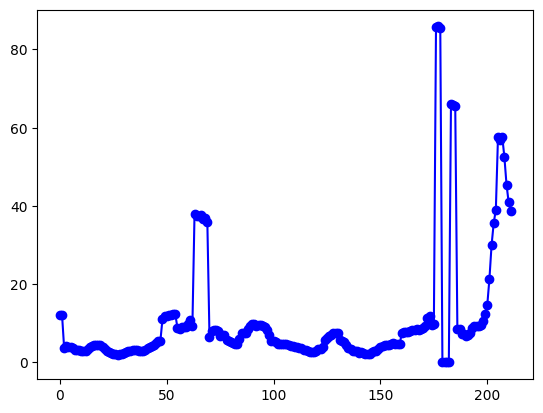

Score:  2258.0
<|im_start|>user
 in this phase is based on the bioasq dataset \cite{bioasq} with RAG-style formulation from Cohere \cite{cohererag}.

\begin{table}[ht]
\centering
\caption{RAG Generation Test Results on bioasq}
\label{table:commandr_generation}
\begin{tabular}{@{}cccc@{}}
\toprule
Number of Documents & Approximate Context Length & Ground Truth Position & \% Difference \\ \midrule
\multirow{4}{*}{30}  & \multirow{4}{*}{8k}  & 0  & -1.8\% \\
                     &                      & 14 & 0\%   \\
                     &                      & 30 & -3.4\% \\
                     &                      & Avg & -1.7\% \\ \midrule
\multirow{4}{*}{100} & \multirow{4}{*}{14k} & 0  & -1.2\% \\
                     &                      & 14 & +0.9\% \\
                     &                      & 30 & -0.9\% \\scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



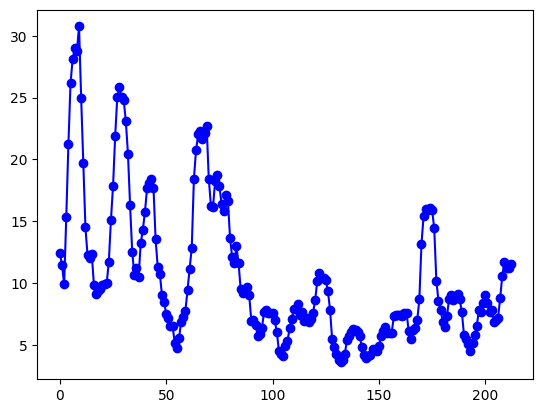

Score:  2146.0
<|im_start|>user
 to 40,000 tokens. Given our KV cache size of 4096, we achieve a compression of 5-10x. As observed in Table \ref{table:commandr_cite}, \kv demonstrates a remarkable ability to retain nearly 98.8\% of \texttt{Command-R}'s performance.
\begin{table}[h]
\centering
\caption{RAG Test Results}
\begin{tabular}{lcc}
\toprule
\text{Evaluation Task} & \text{Metric} & \text{\% Difference} \\
\midrule
RAG Citation & F1 score & -1.2\% \\
RAG End-to-end & F1 score & -2.1\% \\
\bottomrule
\end{tabular}
\label{table:commandr_cite}
\end{table}
\paragraph{Generation} \label{Generation_Section}
As the quality of generation is important to a model's RAG capability, we evaluate \texttt{Command-R} on lost-in-the-middle and generation quality. Lost-in-the-middle is aimed to analyze whether the performance ofscale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



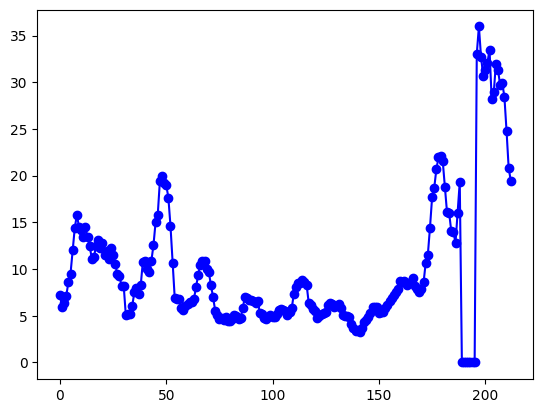

Score:  2136.0
<|im_start|>user
ch~\cite{bai2023longbench}, a multi-task benchmark designed to rigorously evaluate long context understanding capabilities across various datasets, spanning single and multi-document QA, summarization, few-shot learning, synthetic tasks, and code completion. We choose \texttt{LWM-Text-Chat-1M} with 1 million context length, \texttt{LongChat-7b-v1.5-32k}, \texttt{Mistral-7B-Instruct-v0.2}, \texttt{Mixtral-8x7B-Instruct-v0.1} with 32k context length as our baselines. For each model, we test \kv with various settings: compressing KV caches in the prompt to 1024, 2048, and 4096 tokens. We use max pooling with kernel size 7 and observation window size 32. Table \ref{tab:longbench} illustrates a negligible performance drop from models with \kv compared with original implementations for 16 different datasets, even with prompt-KV with 1024 tokens. Some models even outperform the baseline. Our results substantiate that \kv can grasp the key informationscale langu

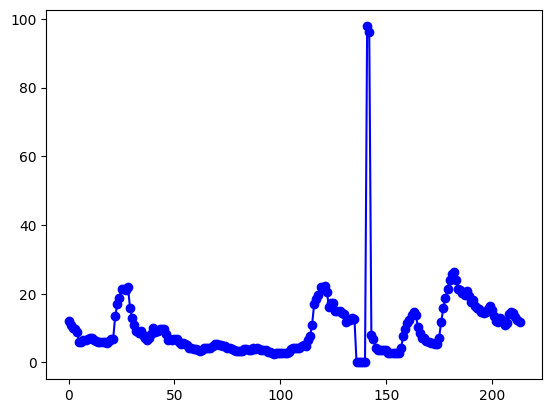

Score:  2120.0
<|im_start|>user
10} \textbf{71.0} &\cellcolor{green!10} 61.06 & \cellcolor{green!10} \textbf{40.33} &\cellcolor{green!10} 0.0 &\cellcolor{green!10}0.0 & \cellcolor{green!10}41.52 & \cellcolor{green!10}40.97\\


\specialrule{1pt}{2pt}{10pt}\specialrule{1pt}{2pt}{2pt}

\multirow{5}{*}{\rotatebox[origin=c]{90}{\fontsize{18}{100}\selectfont LongChat}}

& \cellcolor{blue!10}~~~All KV & \cellcolor{blue!10}\textbf{20.88} & \cellcolor{blue!10}\textbf{29.36} & \cellcolor{blue!10}\textbf{43.2} & \cellcolor{blue!10}33.05 & \cellcolor{blue!10}24.58scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



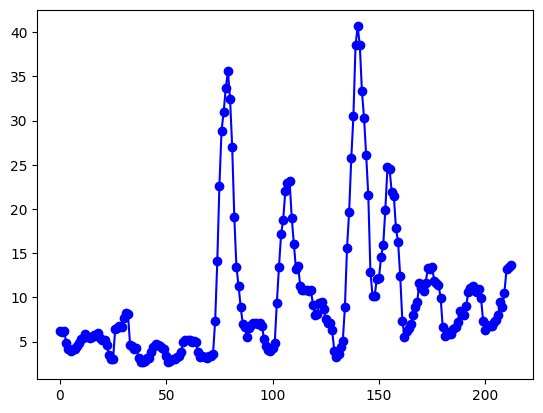

Score:  2064.0
<|im_start|>user
{3}{c}{Few-shot Learning}& \multicolumn{2}{c}{Synthetic} & \multicolumn{2}{c}{Code} \\
\cmidrule(lr){3-5}\cmidrule(lr){6-8}\cmidrule(lr){9-11}\cmidrule(lr){12-14}\cmidrule(lr){15-16}\cmidrule(lr){17-18}
&& \rotatebox[origin=c]{30}{NrtvQA} & \rotatebox[origin=c]{30}{Qasper} & \rotatebox[origin=c]{30}{MF-en} & \rotatebox[origin=c]{30}{HotpotQA} & \rotatebox[origin=c]{30}{2WikiMQA} & \rotatebox[origin=c]{30}{Musique} & \rotatebox[origin=c]{30}{GovReport} & \rotatebox[origin=c]{30}{QMSum} & \rotatebox[origin=c]{30}{MultiNews} & \rotatebox[origin=c]{30}{Tscale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



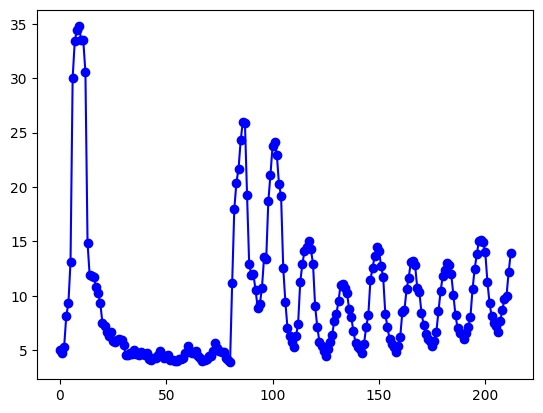

Score:  1996.0
<|im_start|>user
10}75.8 & \cellcolor{blue!10}39.92 & \cellcolor{blue!10}0.0 & \cellcolor{blue!10}25.5 & \cellcolor{blue!10}53.56 & \cellcolor{blue!10}55.53 \\

\specialrule{1pt}{2pt}{10pt}\specialrule{1pt}{2pt}{2pt}



\multirow{5}{*}{\rotatebox[origin=c]{90}{\fontsize{18}{100}\selectfont Mistral}}

& \cellcolor{red!10}~~~All KV & \cellcolor{red!10}\textbf{26.82} & \cellcolor{red!10}33.06 & \cellcolor{red!10}49.28 & \cellcolor{red!10}\textbf{42.77} & \cellcolor{red!10}27.33 & \cellcolor{red!10}19.27 & \cellcolor{red!10}\textbf{3scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



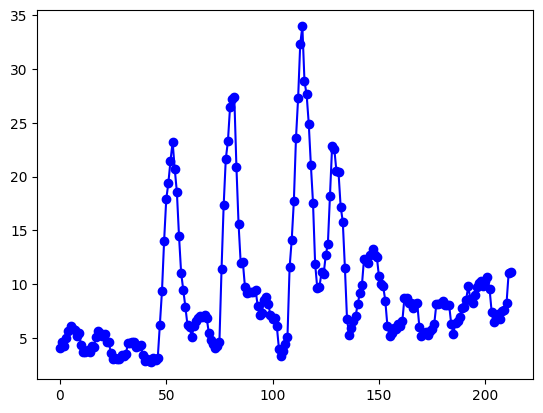

Score:  1955.0
<|im_start|>user
{green!10} 24.49 &\cellcolor{green!10} 19.38&\cellcolor{green!10} \textbf{11.34} &\cellcolor{green!10} 21.6 & \cellcolor{green!10}24.22 &\cellcolor{green!10} 24.36 &\cellcolor{green!10} 70.0 &\cellcolor{green!10} 61.11 & \cellcolor{green!10} 39.91 &\cellcolor{green!10} 2.17 &\cellcolor{green!10}4.0 & \cellcolor{green!10}44.46 & \cellcolor{green!10}\textbf{44.92}\\


&\cellcolor{green!10}~~~\kv: 4096 & \cellcolor{green!10}17.92&\cellcolor{green!10}25.47 &\cellcolor{green!10} 40.76scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



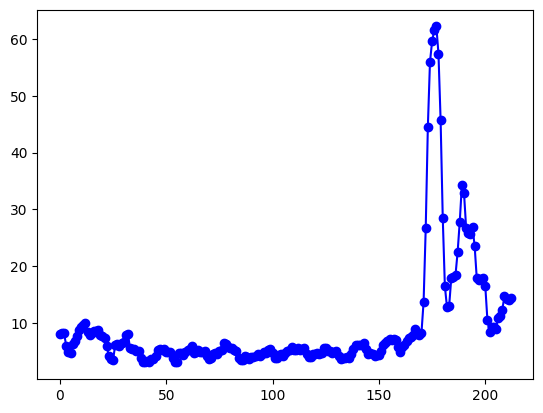

Score:  1899.0
<|im_start|>user
10}24.58 & \cellcolor{blue!10}\textbf{14.66} & \cellcolor{blue!10}\textbf{30.89} & \cellcolor{blue!10}22.76 & \cellcolor{blue!10}\textbf{26.61} & \cellcolor{blue!10}\textbf{66.5} & \cellcolor{blue!10}\textbf{83.99} & \cellcolor{blue!10}\textbf{40.83} & \cellcolor{blue!10}0.0 & \cellcolor{blue!10}30.5 & \cellcolor{blue!10}54.89 & \cellcolor{blue!10}\textbf{59.05} \\
\cline{2-18}

& \cellcolor{blue!10}~~~\kv: 1024 & \cellcolor{blue!10}19.32 & \cellcolor{blue!10}26.6 & \cellcolor{blue!10}37.9scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



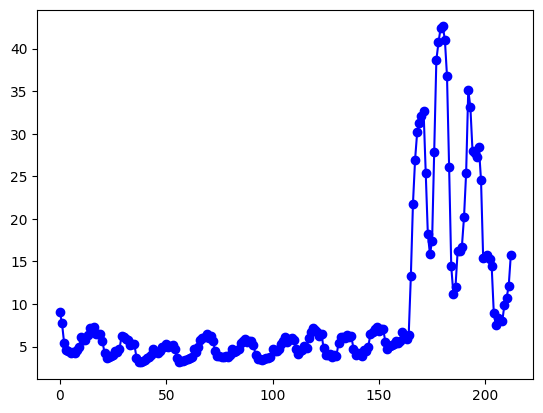

Score:  1885.0
<|im_start|>user
 \(H\), quantifies the effectiveness of the voting mechanism by measuring the ratio of attention features identified as significant by the voting process that are also essential in the generation outcome, calculated as:

\begin{align}
\mathbf{M}_{\text{vote\_obs}} &= \text{zeros\_like} (\mathbf{A}_{\text{cur}}) \\
\mathbf{M}_{\text{vote\_obs}}[I] &= 1 \\
\mathbf{M}_{\text{threshold\_cur}} &= \mathbf{1}(\mathbf{A}_{\text{cur}} > \theta) \\
\mathbf{O} &= \mathbf{M}_{\text{threshold\_cur}} \land \mathbf{M}_{\text{vote\_obs}} \label{eq:stepa}\\
H &= \frac{\sum \mathbf{O}}{\sum \mathbf{M}_{\text{threshold\_cur}}} \label{eq:stepb}
\end{align}


\(\mathbf{A}_{\text{cur}}\in \mathbb{R}^{N \times L_{\text{prefix}}}\) represents the attention features between the current generated query and prefix keys. The threshold operation filtersscale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



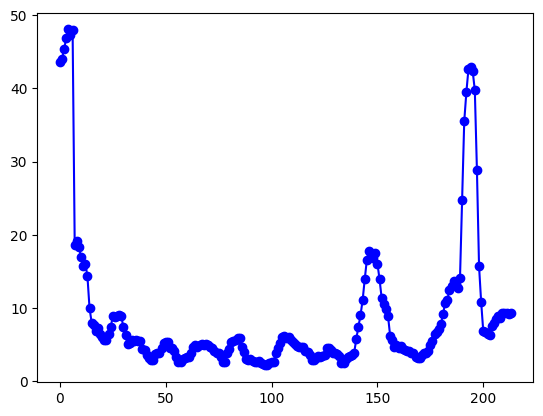

Score:  1884.0
<|im_start|>user
 & \cellcolor{cyan!10}33.23 & \cellcolor{cyan!10}26.27 & \cellcolor{cyan!10}30.19 & \cellcolor{cyan!10}25.84 & \cellcolor{cyan!10}27.8 & \cellcolor{cyan!10}\textbf{76.0} & \cellcolor{cyan!10}90.24 & \cellcolor{cyan!10}46.31 & \cellcolor{cyan!10}5.5 & \cellcolor{cyan!10}100.0 & \cellcolor{cyan!10}68.72 & \cellcolor{cyan!10}\textbf{70.01} \\

& \cellcolor{cyan!10}~~~\kv: 4096 & \cellcolor{cyan!10}26.46 & \cellcolor{cyan!10}37.03 & \cellcolor{cyan!10}\textbf{52.62}scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



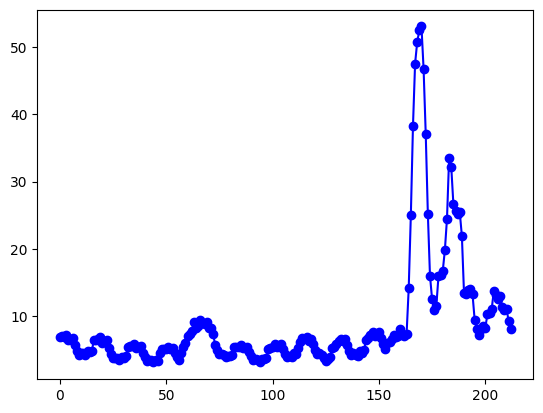

Score:  1872.0
<|im_start|>user
 & \cellcolor{red!10}18.69 & \cellcolor{red!10}28.81 & \cellcolor{red!10}\textbf{24.5} & \cellcolor{red!10}26.6 & \cellcolor{red!10}70.0 & \cellcolor{red!10}86.27 & \cellcolor{red!10}42.47 & \cellcolor{red!10}3.09 & \cellcolor{red!10}87.43 & \cellcolor{red!10}\textbf{55.93} & \cellcolor{red!10}52.01 \\


& \cellcolor{red!10}~~~\kv: 4096 & \cellcolor{red!10}26.41 & \cellcolor{red!10}\textbf{33.36} & \cellcolor{red!10}\textbf{49.81} & \cellcolor{red!10}42.32 & \cellcolor{red!10}\textbfscale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



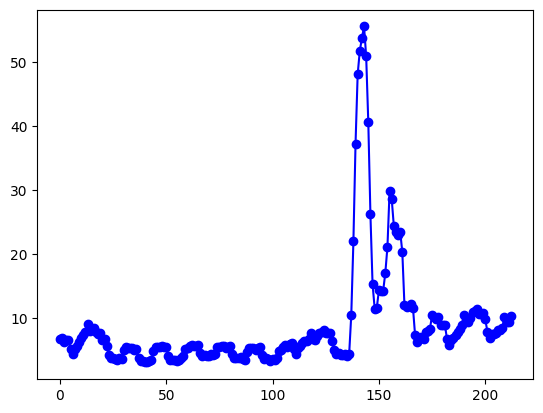

Score:  1858.0
<|im_start|>user
!10}\textbf{3.46} & \cellcolor{red!10}86.38 & \cellcolor{red!10}53.72 & \cellcolor{red!10}51.1 \\

\specialrule{1pt}{2pt}{10pt}\specialrule{1pt}{2pt}{2pt}


\multirow{5}{*}{\rotatebox[origin=c]{90}{\fontsize{18}{100}\selectfont Mixtral}}

& \cellcolor{cyan!10}~~~All KV & \cellcolor{cyan!10}{26.81} & \cellcolor{cyan!10}\textbf{37.06} & \cellcolor{cyan!10}51.55 & \cellcolor{cyan!10}47.77 & \cellcolor{cyan!10}32.46 & \cellcolor{cyan!10}\textbf{26.59} & \cellcolor{cyan!10}\textbf{34.25} & \cellcolor{cyan!scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



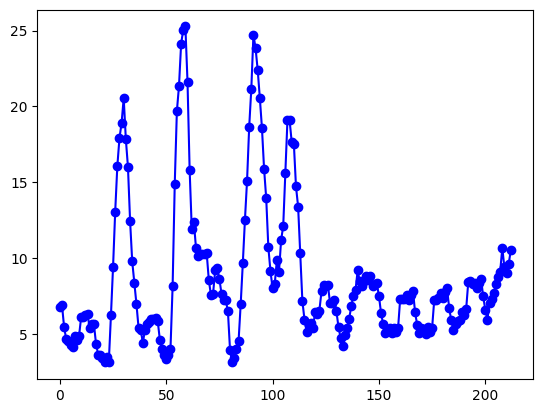

Score:  1841.0
<|im_start|>user
0.26 & \cellcolor{blue!10}\textbf{35.31} & \cellcolor{blue!10}23.75 & \cellcolor{blue!10}13.44 & \cellcolor{blue!10}26.3 & \cellcolor{blue!10}22.29 & \cellcolor{blue!10}25.73 & \cellcolor{blue!10}66.0 & \cellcolor{blue!10}79.93 & \cellcolor{blue!10}39.59 & \cellcolor{blue!10}0.0 & \cellcolor{blue!10}\textbf{31.0} & \cellcolor{blue!10}\textbf{56.05} & \cellcolor{blue!10}58.61 \\

& \cellcolor{blue!10}~~~\kv: 4096 & \cellcolor{blue!10}20.68 & \cellcolor{blue!10}29.34 & \cellcolor{blue!10}42.scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



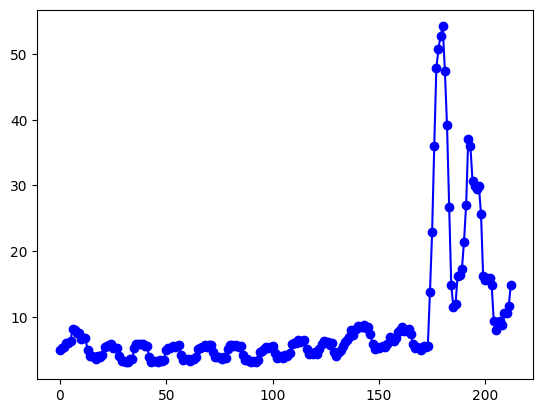

Score:  1838.0
<|im_start|>user
{green!10} \textbf{19.84}&\cellcolor{green!10} 10.77 &\cellcolor{green!10} 19.79 & \cellcolor{green!10}24.44 &\cellcolor{green!10} 23.53 &\cellcolor{green!10} 70.0 &\cellcolor{green!10} \textbf{61.42} & \cellcolor{green!10} 39.64 &\cellcolor{green!10} 1.67 &\cellcolor{green!10}3.0 & \cellcolor{green!10}43.34 & \cellcolor{green!10}44.0\\



&\cellcolor{green!10}~~~\kv: 2048 & \cellcolor{green!10}17.92&\cellcolor{green!10}25.03&\cellcolor{green!10} \textbf{41.38} &\cellcolor{green!10} 2scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



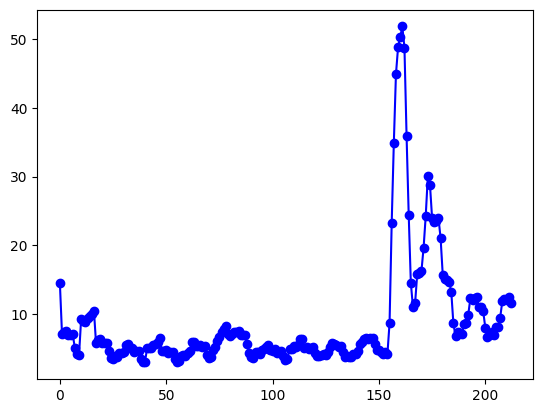

Score:  1820.0
<|im_start|>user
{red!10}\textbf{27.93} & \cellcolor{red!10}18.76 & \cellcolor{red!10}30.74 & \cellcolor{red!10}24.19 & \cellcolor{red!10}\textbf{27.08} & \cellcolor{red!10}\textbf{71.0} & \cellcolor{red!10}86.25 & \cellcolor{red!10}\textbf{43.01} & \cellcolor{red!10}2.73 & \cellcolor{red!10}86.18 & \cellcolor{red!10}55.62 & \cellcolor{red!10}52.65 \\

& \cellcolor{red!10}~~~H2O: 4096 & \cellcolor{red!10}22.61 & \cellcolor{red!10}29.06 & \cellcolor{red!10}47.22 & \cellcolor{red!10}36.scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



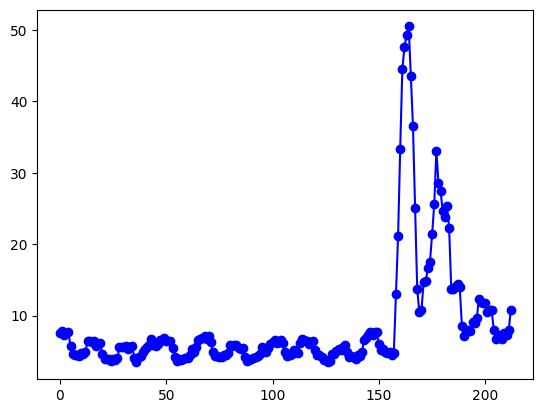

Score:  1816.0
<|im_start|>user
!10}37.93 & \cellcolor{blue!10}34.15 & \cellcolor{blue!10}23.34 & \cellcolor{blue!10}12.71 & \cellcolor{blue!10}23.45 & \cellcolor{blue!10}21.81 & \cellcolor{blue!10}24.93 & \cellcolor{blue!10}65.0 & \cellcolor{blue!10}80.88 & \cellcolor{blue!10}38.19 & \cellcolor{blue!10}0.0 & \cellcolor{blue!10}31.0 & \cellcolor{blue!10}53.63 & \cellcolor{blue!10}57.62 \\

& \cellcolor{blue!10}~~~\kv: 2048 & \cellcolor{blue!10}19.28 & \cellcolor{blue!10}28.81 & \cellcolor{blue!10}40.26 & \cellcolorscale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



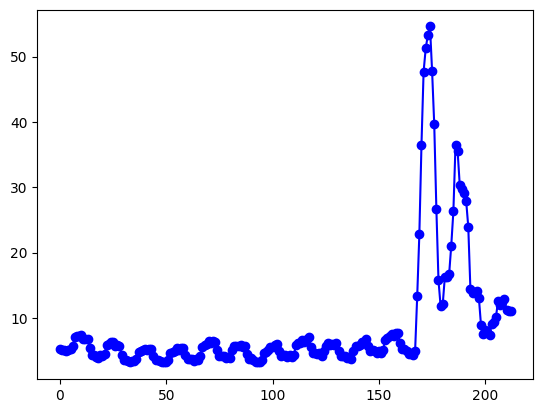

Score:  1809.0
<|im_start|>user
!10} 10.49 &\cellcolor{green!10} \textbf{27.97} & \cellcolor{green!10}24.9 &\cellcolor{green!10} \textbf{24.81} &\cellcolor{green!10}71.0&\cellcolor{green!10} 60.9 & \cellcolor{green!10} 39.73 &\cellcolor{green!10} 3.17 &\cellcolor{green!10}3.5 & \cellcolor{green!10}44.4 & \cellcolor{green!10}43.82\\
\cline{2-18}

&\cellcolor{green!10}~~~\kv: 1024 & \cellcolor{green!10}18.02&\cellcolor{green!10}23.73&\cellcolor{green!10} 40.25 &\cellcolor{green!10} 24.61 &\cellcolor{green!10} \textscale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



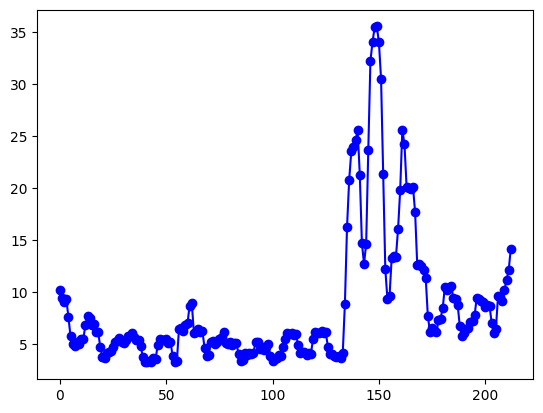

Score:  1793.0
<|im_start|>user
67 & \cellcolor{cyan!10}25.92 & \cellcolor{cyan!10}27.77 & \cellcolor{cyan!10}25.0 & \cellcolor{cyan!10}27.25 & \cellcolor{cyan!10}74.5 & \cellcolor{cyan!10}90.42 & \cellcolor{cyan!10}46.48 & \cellcolor{cyan!10}5.5 & \cellcolor{cyan!10}99.5 & \cellcolor{cyan!10}69.02 & \cellcolor{cyan!10}68.98 \\

& \cellcolor{cyan!10}~~~\kv: 2048 & \cellcolor{cyan!10}\textbf{27.12} & \cellcolor{cyan!10}36.9 & \cellcolor{cyan!10}51.91 & \cellcolor{cyan!10}47.46 & \cellcolor{cyan!scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



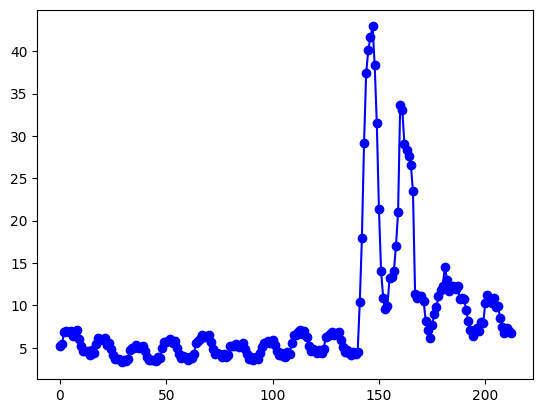

Score:  1782.0
<|im_start|>user
 & \cellcolor{cyan!10}\textbf{26.05} & \cellcolor{cyan!10}27.91 & \cellcolor{cyan!10}76.0 & \cellcolor{cyan!10}90.57 & \cellcolor{cyan!10}46.98 & \cellcolor{cyan!10}5.5 & \cellcolor{cyan!10}100.0 & \cellcolor{cyan!10}\textbf{69.07} & \cellcolor{cyan!10}69.65 \\
\cline{2-18}

& \cellcolor{cyan!10}~~~\kv: 1024 & \cellcolor{cyan!10}26.01 & \cellcolor{cyan!10}34.65 & \cellcolor{cyan!10}51.58 & \cellcolor{cyan!10}\textbf{48.23} & \cellcolor{cyan!10}32.67 & \cellcolor{cyscale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



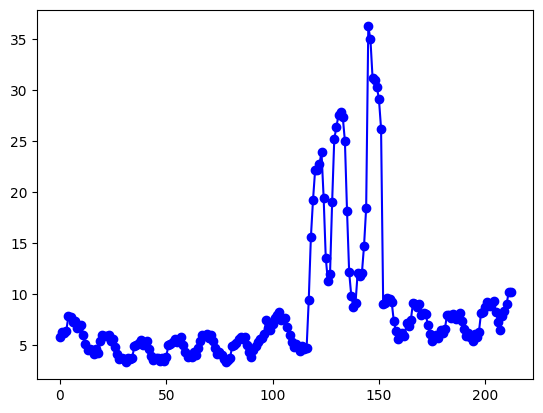

Score:  1773.0
<|im_start|>user
 & \rotatebox[origin=c]{30}{Qasper} & \rotatebox[origin=c]{30}{MF-en} & \rotatebox[origin=c]{30}{HotpotQA} & \rotatebox[origin=c]{30}{2WikiMQA} & \rotatebox[origin=c]{30}{Musique} & \rotatebox[origin=c]{30}{GovReport} & \rotatebox[origin=c]{30}{QMSum} & \rotatebox[origin=c]{30}{MultiNews} & \rotatebox[origin=c]{30}{TREC} & \rotatebox[origin=c]{30}{TriviaQA} & \rotatebox[origin=c]{30}{SAMSum} & \rotatebox[origin=c]{30}{PCount} & \rotatebox[origin=c]{30}{PRe} & \rotatebox[origin=c]{30}{Lcc} & \rotatebox[origin=c]{30}{RB-P} \\

\specialrule{1pt}{2pt}{2pt}

\multirow{5}{*}{\rotatebox[origin=c]{90}{\fontsizescale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



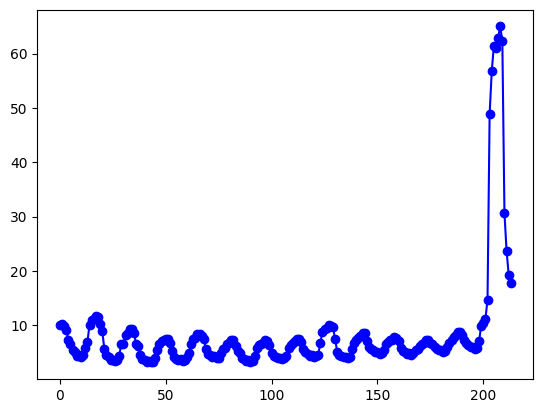

Score:  1772.0
<|im_start|>user
cellcolor{green!10} 1.67 &\cellcolor{green!10}3.0 & \cellcolor{green!10}43.34 & \cellcolor{green!10}44.0\\



&\cellcolor{green!10}~~~\kv: 2048 & \cellcolor{green!10}17.92&\cellcolor{green!10}25.03&\cellcolor{green!10} \textbf{41.38} &\cellcolor{green!10} 24.49 &\cellcolor{green!10} 19.38&\cellcolor{green!10} \textbf{11.34} &\cellcolor{green!10} 21.6 & \cellcolor{green!10}24.22 &\cellcolor{green!10} 24.36 &\cellcolor{green!10} 70.0 &\cellcolor{green!10} 61.11 & \cellcolor{green!10} 39.9scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



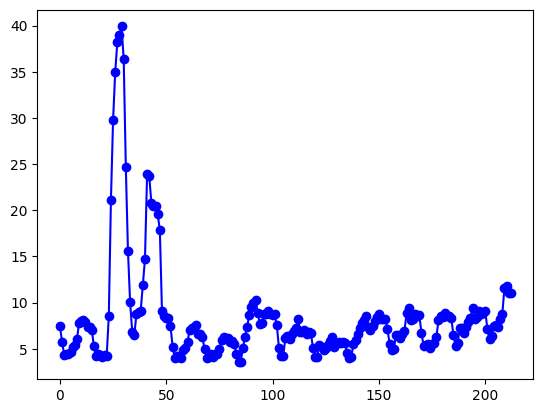

Score:  1772.0
<|im_start|>user
blue!10}42.21 & \cellcolor{blue!10}33.95 & \cellcolor{blue!10}\textbf{24.88} & \cellcolor{blue!10}14.15& \cellcolor{blue!10}28.55 & \cellcolor{blue!10}\textbf{23.11} & \cellcolor{blue!10}26.45 & \cellcolor{blue!10}66.0 & \cellcolor{blue!10}\textbf{81.25} & \cellcolor{blue!10}\textbf{40.52} & \cellcolor{blue!10}0.0 & \cellcolor{blue!10}29.5 & \cellcolor{blue!10}54.79 & \cellcolor{blue!10}58.81 \\

& \cellcolor{blue!10}~~~H2O: 4096 & \cellcolor{blue!10}19.31 & \cellcolor{blue!10}28.3 & \scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



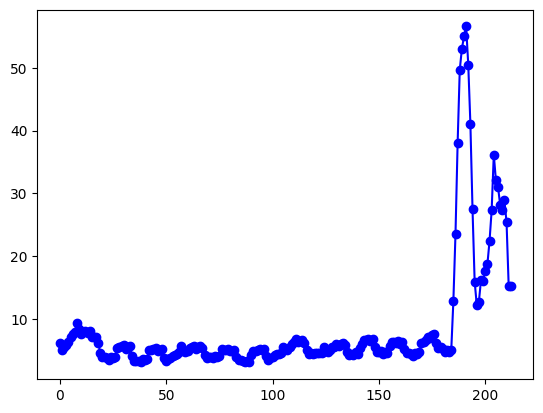

Score:  1739.0
<|im_start|>user
10} 39.91 &\cellcolor{green!10} 2.17 &\cellcolor{green!10}4.0 & \cellcolor{green!10}44.46 & \cellcolor{green!10}\textbf{44.92}\\


&\cellcolor{green!10}~~~\kv: 4096 & \cellcolor{green!10}17.92&\cellcolor{green!10}25.47 &\cellcolor{green!10} 40.76 &\cellcolor{green!10} \textbf{24.92} &\cellcolor{green!10} 19.53&\cellcolor{green!10} 11.27 &\cellcolor{green!10} 25.34 & \cellcolor{green!10}\textbf{25.42} &\cellcolor{green!10} 24.58 &\cellcolor{green!10} 70.5 &\cellcolor{green!10} 61.scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



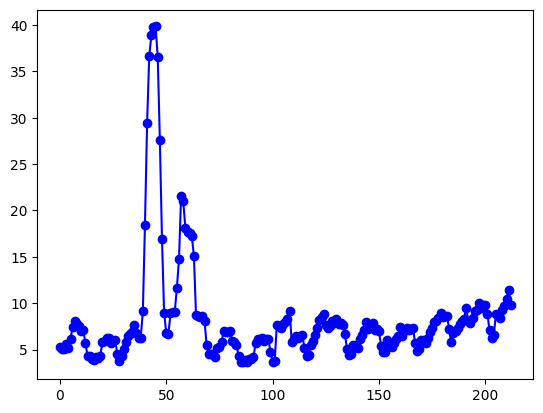

Score:  1732.0
<|im_start|>user
0}\textbf{19.42} & \cellcolor{red!10}25.89 & \cellcolor{red!10}23.82 & \cellcolor{red!10}26.11 & \cellcolor{red!10}69.5 & \cellcolor{red!10}\textbf{86.48} & \cellcolor{red!10}42.06 & \cellcolor{red!10}2.98 & \cellcolor{red!10}\textbf{88.56} & \cellcolor{red!10}55.65 & \cellcolor{red!10}51.87 \\


& \cellcolor{red!10}~~~\kv: 2048 & \cellcolor{red!10}25.89 & \cellcolor{red!10}32.47 & \cellcolor{red!10}48.6 & \cellcolor{red!10}41.71 & \cellcolor{red!10}27.31 & \cellcolor{red!1scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



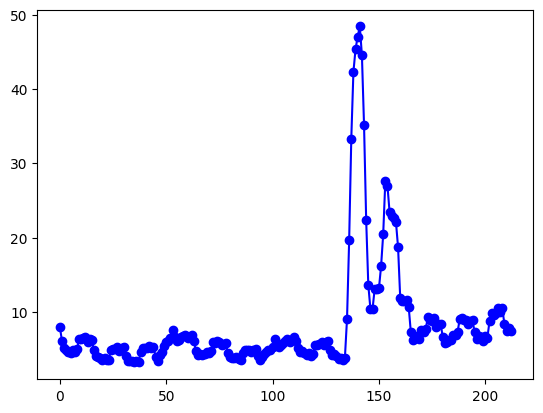

Score:  1723.0
<|im_start|>user
cyan!10}\textbf{90.71} & \cellcolor{cyan!10}\textbf{47.14} & \cellcolor{cyan!10}5.5 & \cellcolor{cyan!10}\textbf{100.0} & \cellcolor{cyan!10}68.81 & \cellcolor{cyan!10}69.56 \\

& \cellcolor{cyan!10}~~~H2O: 4096 & \cellcolor{cyan!10}20.45 & \cellcolor{cyan!10}32.09 & \cellcolor{cyan!10}48.02 & \cellcolor{cyan!10}34.76 & \cellcolor{cyan!10}25.69 & \cellcolor{cyan!10}16.5 & \cellcolor{cyan!10}29.76 & \cellcolor{cyan!10}23.53 & \cellcolor{cyan!10}26.84 & \cellscale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



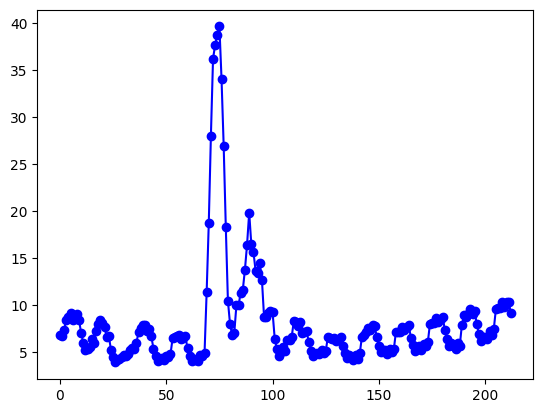

Score:  1704.0
<|im_start|>user
0}3.5 & \cellcolor{green!10}44.4 & \cellcolor{green!10}43.82\\
\cline{2-18}

&\cellcolor{green!10}~~~\kv: 1024 & \cellcolor{green!10}18.02&\cellcolor{green!10}23.73&\cellcolor{green!10} 40.25 &\cellcolor{green!10} 24.61 &\cellcolor{green!10} \textbf{19.84}&\cellcolor{green!10} 10.77 &\cellcolor{green!10} 19.79 & \cellcolor{green!10}24.44 &\cellcolor{green!10} 23.53 &\cellcolor{green!10} 70.0 &\cellcolor{green!10} \textbf{61.42} & \cellcolor{green!10} 39.64 &\cellcolor{green!10}scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



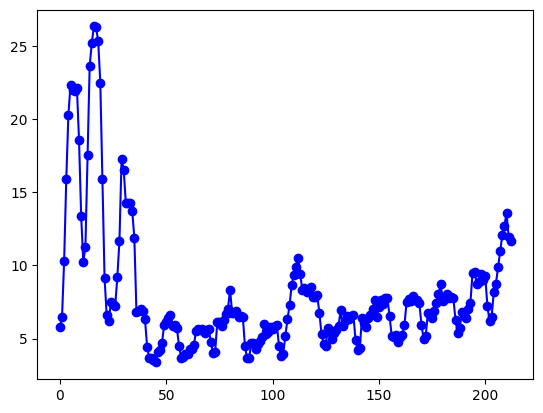

Score:  1696.0
<|im_start|>user
cellcolor{cyan!10}5.5 & \cellcolor{cyan!10}100.0 & \cellcolor{cyan!10}68.72 & \cellcolor{cyan!10}\textbf{70.01} \\

& \cellcolor{cyan!10}~~~\kv: 4096 & \cellcolor{cyan!10}26.46 & \cellcolor{cyan!10}37.03 & \cellcolor{cyan!10}\textbf{52.62} & \cellcolor{cyan!10}47.71 & \cellcolor{cyan!10}\textbf{33.35} & \cellcolor{cyan!10}26.45 & \cellcolor{cyan!10}32.64 & \cellcolor{cyan!10}25.87 & \cellcolor{cyan!10}\textbf{27.94} & \cellcolor{cyan!10}75.5 & \cellcolor{cyan!10}\textbfscale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



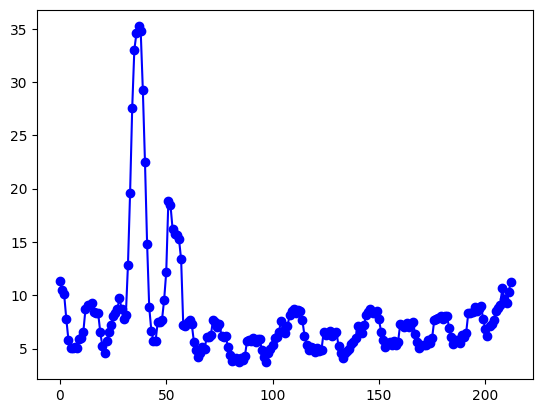

Score:  1688.0
<|im_start|>user
!10}\textbf{32.85} & \cellcolor{red!10}24.25 & \cellcolor{red!10}27.06 & \cellcolor{red!10}71.0 & \cellcolor{red!10}86.23 & \cellcolor{red!10}42.98 & \cellcolor{red!10}2.75 & \cellcolor{red!10}86.98 & \cellcolor{red!10}55.51 & \cellcolor{red!10}\textbf{52.88} \\
\cline{2-18}

& \cellcolor{red!10}~~~\kv: 1024 & \cellcolor{red!10}25.54 & \cellcolor{red!10}29.51 & \cellcolor{red!10}49.25 & \cellcolor{red!10}40.94 & \cellcolor{red!10}25.7 & \cellcolor{red!10}\textbf{19.scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



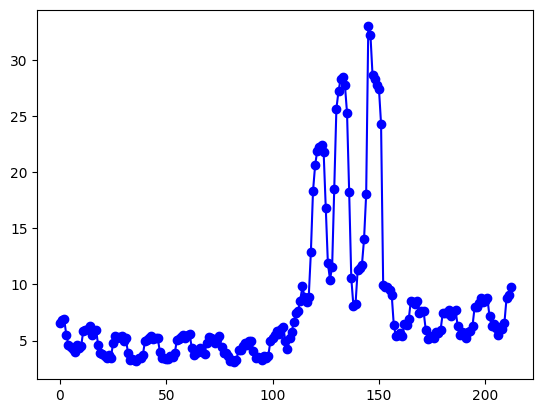

Score:  1683.0
<|im_start|>user
.83} & \cellcolor{blue!10}0.0 & \cellcolor{blue!10}30.5 & \cellcolor{blue!10}54.89 & \cellcolor{blue!10}\textbf{59.05} \\
\cline{2-18}

& \cellcolor{blue!10}~~~\kv: 1024 & \cellcolor{blue!10}19.32 & \cellcolor{blue!10}26.6 & \cellcolor{blue!10}37.93 & \cellcolor{blue!10}34.15 & \cellcolor{blue!10}23.34 & \cellcolor{blue!10}12.71 & \cellcolor{blue!10}23.45 & \cellcolor{blue!10}21.81 & \cellcolor{blue!10}24.93 & \cellcolor{blue!10}65.0 & \cellcolor{blue!10}80.88 & \cellcolor{blue!10}38scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



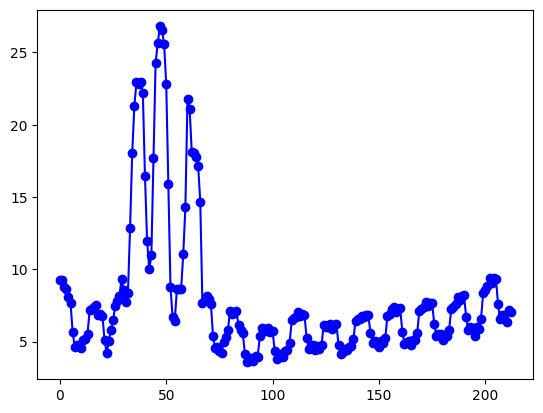

Score:  1682.0
<|im_start|>user
!10}39.59 & \cellcolor{blue!10}0.0 & \cellcolor{blue!10}\textbf{31.0} & \cellcolor{blue!10}\textbf{56.05} & \cellcolor{blue!10}58.61 \\

& \cellcolor{blue!10}~~~\kv: 4096 & \cellcolor{blue!10}20.68 & \cellcolor{blue!10}29.34 & \cellcolor{blue!10}42.21 & \cellcolor{blue!10}33.95 & \cellcolor{blue!10}\textbf{24.88} & \cellcolor{blue!10}14.15& \cellcolor{blue!10}28.55 & \cellcolor{blue!10}\textbf{23.11} & \cellcolor{blue!10}26.45 & \cellcolor{blue!10}66.0 & \cellcolor{blue!10}\textbf{81.25scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



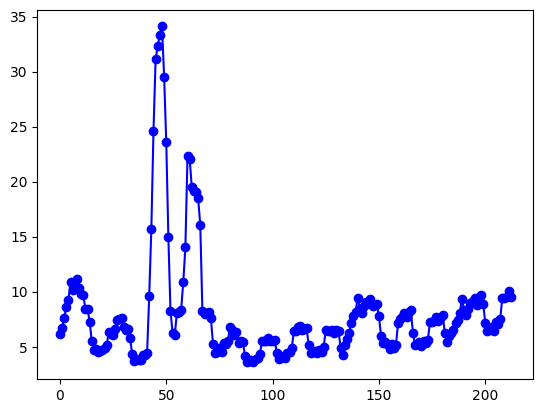

Score:  1681.0
<|im_start|>user
{blue!10}38.19 & \cellcolor{blue!10}0.0 & \cellcolor{blue!10}31.0 & \cellcolor{blue!10}53.63 & \cellcolor{blue!10}57.62 \\

& \cellcolor{blue!10}~~~\kv: 2048 & \cellcolor{blue!10}19.28 & \cellcolor{blue!10}28.81 & \cellcolor{blue!10}40.26 & \cellcolor{blue!10}\textbf{35.31} & \cellcolor{blue!10}23.75 & \cellcolor{blue!10}13.44 & \cellcolor{blue!10}26.3 & \cellcolor{blue!10}22.29 & \cellcolor{blue!10}25.73 & \cellcolor{blue!10}66.0 & \cellcolor{blue!10}79.93 & \cellcolor{blue!10}39.5scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



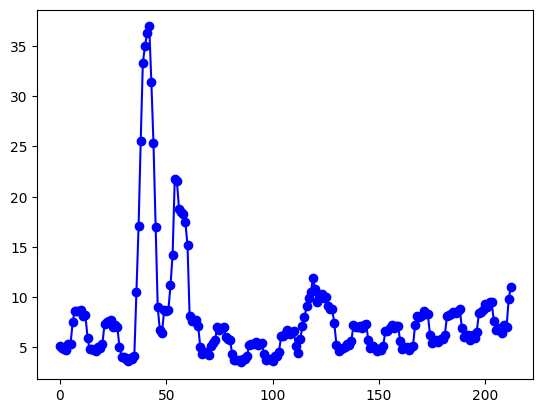

Score:  1662.0
<|im_start|>user
tab:longbench}
\begin{threeparttable}
\scalebox{0.3}{
\begin{tabular}{l|lcccccccccccccccc}
\specialrule{1pt}{0pt}{2pt}
&\multirow{4}{*}{~~~LLMs\tnote{a}} & \multicolumn{3}{c}{Single-Document QA} & \multicolumn{3}{c}{Multi-Document QA}& \multicolumn{3}{c}{Summarization}& \multicolumn{3}{c}{Few-shot Learning}& \multicolumn{2}{c}{Synthetic} & \multicolumn{2}{c}{Code} \\
\cmidrule(lr){3-5}\cmidrule(lr){6-8}\cmidrule(lr){9-11}\cmidrule(lr){12-14}\cmidrule(lr){15-16}\cmidrule(lr){17-18}
&& \rotatebox[origin=c]{30}{NrtvQA} & \rotatebox[origin=cscale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



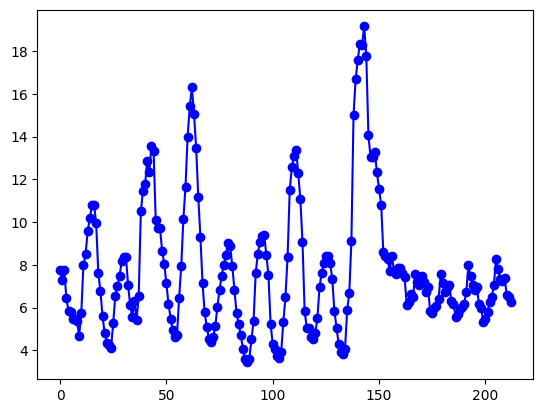

Score:  1655.0
<|im_start|>user
pt}

\multirow{5}{*}{\rotatebox[origin=c]{90}{\fontsize{18}{100}\selectfont LongChat}}

& \cellcolor{blue!10}~~~All KV & \cellcolor{blue!10}\textbf{20.88} & \cellcolor{blue!10}\textbf{29.36} & \cellcolor{blue!10}\textbf{43.2} & \cellcolor{blue!10}33.05 & \cellcolor{blue!10}24.58 & \cellcolor{blue!10}\textbf{14.66} & \cellcolor{blue!10}\textbf{30.89} & \cellcolor{blue!10}22.76 & \cellcolor{blue!10}\textbf{26.61} & \cellcolor{blue!10}\textbf{66.5} & \cellcolor{blue!10}\textbf{83.99} & \cellcolor{blue!10}\textbf{40.83} & \cellcolorscale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



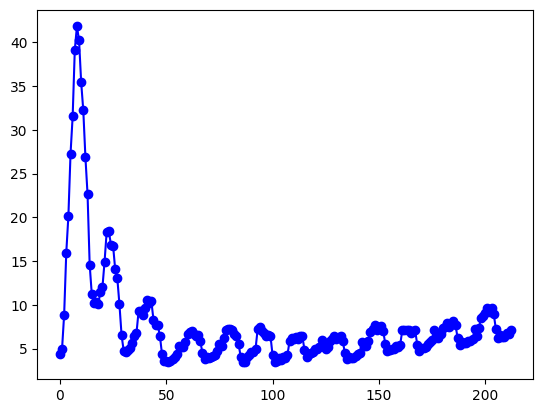

Score:  1632.0
<|im_start|>user
an!10}99.5 & \cellcolor{cyan!10}69.02 & \cellcolor{cyan!10}68.98 \\

& \cellcolor{cyan!10}~~~\kv: 2048 & \cellcolor{cyan!10}\textbf{27.12} & \cellcolor{cyan!10}36.9 & \cellcolor{cyan!10}51.91 & \cellcolor{cyan!10}47.46 & \cellcolor{cyan!10}33.23 & \cellcolor{cyan!10}26.27 & \cellcolor{cyan!10}30.19 & \cellcolor{cyan!10}25.84 & \cellcolor{cyan!10}27.8 & \cellcolor{cyan!10}\textbf{76.0} & \cellcolor{cyan!10}90.24 & \cellcolor{cyan!10}46.31 & \cellcolor{cyan!10scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



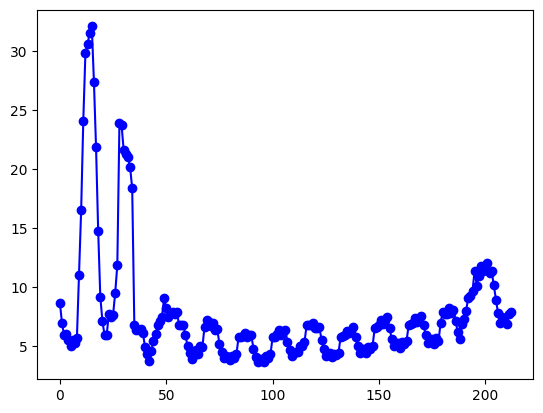

Score:  1629.0
<|im_start|>user
.43 & \cellcolor{red!10}\textbf{55.93} & \cellcolor{red!10}52.01 \\


& \cellcolor{red!10}~~~\kv: 4096 & \cellcolor{red!10}26.41 & \cellcolor{red!10}\textbf{33.36} & \cellcolor{red!10}\textbf{49.81} & \cellcolor{red!10}42.32 & \cellcolor{red!10}\textbf{27.93} & \cellcolor{red!10}18.76 & \cellcolor{red!10}30.74 & \cellcolor{red!10}24.19 & \cellcolor{red!10}\textbf{27.08} & \cellcolor{red!10}\textbf{71.0} & \cellcolor{red!10}86.25 & \cellcolor{red!10}\textbf{43.01} & \cellcolor{red!10scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



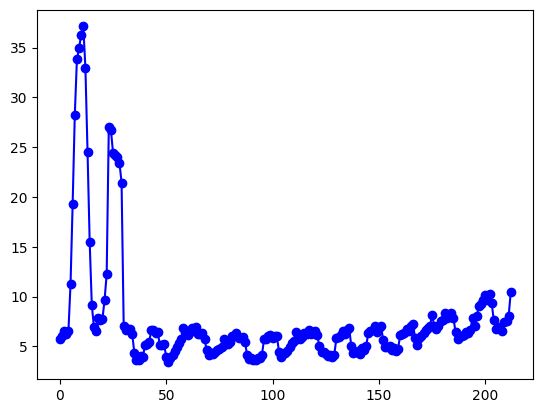

Score:  1591.0
<|im_start|>user
bf{52.62} & \cellcolor{cyan!10}47.71 & \cellcolor{cyan!10}\textbf{33.35} & \cellcolor{cyan!10}26.45 & \cellcolor{cyan!10}32.64 & \cellcolor{cyan!10}25.87 & \cellcolor{cyan!10}\textbf{27.94} & \cellcolor{cyan!10}75.5 & \cellcolor{cyan!10}\textbf{90.71} & \cellcolor{cyan!10}\textbf{47.14} & \cellcolor{cyan!10}5.5 & \cellcolor{cyan!10}\textbf{100.0} & \cellcolor{cyan!10}68.81 & \cellcolor{cyan!10}69.56 \\

& \cellcolor{cyan!10}~~~H2O: 4096 & \cellcolor{cyan!10}20.scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



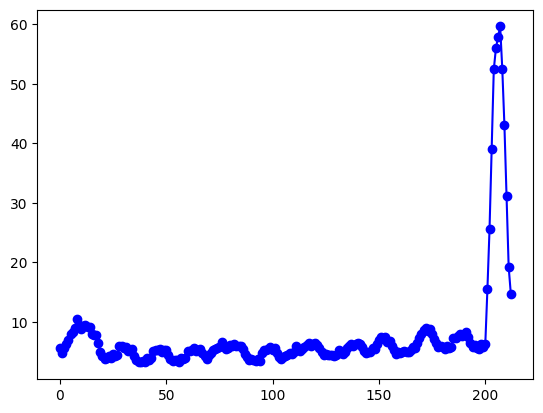

Score:  1583.0
<|im_start|>user
textbf{81.25} & \cellcolor{blue!10}\textbf{40.52} & \cellcolor{blue!10}0.0 & \cellcolor{blue!10}29.5 & \cellcolor{blue!10}54.79 & \cellcolor{blue!10}58.81 \\

& \cellcolor{blue!10}~~~H2O: 4096 & \cellcolor{blue!10}19.31 & \cellcolor{blue!10}28.3 & \cellcolor{blue!10}37.75 & \cellcolor{blue!10}30.51 & \cellcolor{blue!10}23.06 & \cellcolor{blue!10}11.76 & \cellcolor{blue!10}27.55 & \cellcolor{blue!10}21.37 & \cellcolor{blue!10}26.49 & \cellcolor{blue!10}66.0 & \cellcolor{blue!10}75.8 &scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



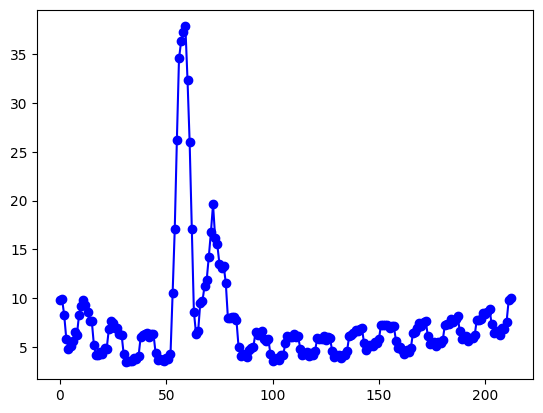

Score:  1546.0
<|im_start|>user
8.56} & \cellcolor{red!10}55.65 & \cellcolor{red!10}51.87 \\


& \cellcolor{red!10}~~~\kv: 2048 & \cellcolor{red!10}25.89 & \cellcolor{red!10}32.47 & \cellcolor{red!10}48.6 & \cellcolor{red!10}41.71 & \cellcolor{red!10}27.31 & \cellcolor{red!10}18.69 & \cellcolor{red!10}28.81 & \cellcolor{red!10}\textbf{24.5} & \cellcolor{red!10}26.6 & \cellcolor{red!10}70.0 & \cellcolor{red!10}86.27 & \cellcolor{red!10}42.47 & \cellcolor{red!10}3.09 & \cellcolor{red!10}87.43 & \cellcolor{scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



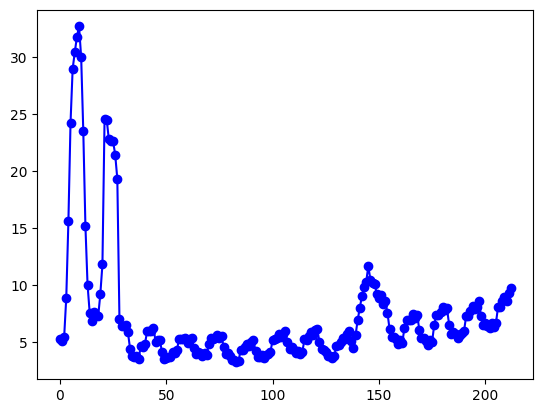

Score:  1538.0
<|im_start|>user
!10} 61.08 & \cellcolor{green!10} 39.62 &\cellcolor{green!10} \textbf{3.17} &\cellcolor{green!10}\textbf{4.0} & \cellcolor{green!10}\textbf{44.49} & \cellcolor{green!10}44.08\\

&\cellcolor{green!10}~~~H2O: 4096 & \cellcolor{green!10}13.17&\cellcolor{green!10}24.82&\cellcolor{green!10}20.01&\cellcolor{green!10} 16.86 &\cellcolor{green!10} 9.74&\cellcolor{green!10} 7.2 &\cellcolor{green!10} 25.77 & \cellcolor{green!10}23.26 &\cellcolor{green!10} 23.83 &\cellcolor{green!10} \textbf{7scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



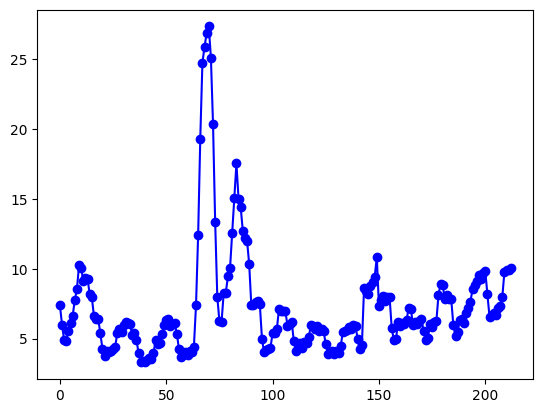

Score:  1526.0
<|im_start|>user
=c]{90}{\fontsize{18}{100}\selectfont LWMChat}}

&\cellcolor{green!10}~~~All KV & \cellcolor{green!10}\textbf{18.18}&\cellcolor{green!10}\textbf{25.56}&\cellcolor{green!10} 40.94 &\cellcolor{green!10} 24.57 &\cellcolor{green!10} 19.39&\cellcolor{green!10} 10.49 &\cellcolor{green!10} \textbf{27.97} & \cellcolor{green!10}24.9 &\cellcolor{green!10} \textbf{24.81} &\cellcolor{green!10}71.0&\cellcolor{green!10} 60.9 & \cellcolor{green!10} 39.73 &\cellcolor{green!10} 3.17 &\cellcolor{green!10}3.5 & \cellscale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



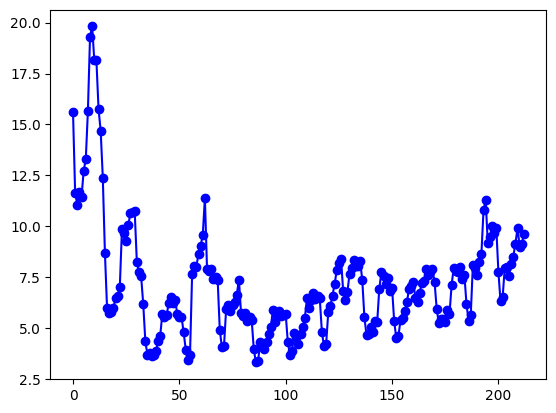

Score:  1523.0
<|im_start|>user
} & \cellcolor{cyan!10}69.65 \\
\cline{2-18}

& \cellcolor{cyan!10}~~~\kv: 1024 & \cellcolor{cyan!10}26.01 & \cellcolor{cyan!10}34.65 & \cellcolor{cyan!10}51.58 & \cellcolor{cyan!10}\textbf{48.23} & \cellcolor{cyan!10}32.67 & \cellcolor{cyan!10}25.92 & \cellcolor{cyan!10}27.77 & \cellcolor{cyan!10}25.0 & \cellcolor{cyan!10}27.25 & \cellcolor{cyan!10}74.5 & \cellcolor{cyan!10}90.42 & \cellcolor{cyan!10}46.48 & \cellcolor{cyan!10}5.5 & \cellcolor{cyan!10}99.scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



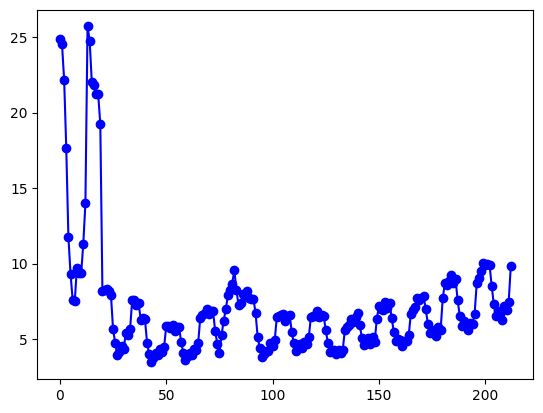

Score:  1473.0
<|im_start|>user
red!10}36.54 & \cellcolor{red!10}20.6 & \cellcolor{red!10}16.25 & \cellcolor{red!10}30.0 & \cellcolor{red!10}23.8 & \cellcolor{red!10}26.75 & \cellcolor{red!10}70.5 & \cellcolor{red!10}86.16 & \cellcolor{red!10}42.97 & \cellcolor{red!10}\textbf{3.46} & \cellcolor{red!10}86.38 & \cellcolor{red!10}53.72 & \cellcolor{red!10}51.1 \\

\specialrule{1pt}{2pt}{10pt}\specialrule{1pt}{2pt}{2pt}


\multirow{5}{*}{\rotatebox[origin=c]{90}{\fontsize{18}{100}\selectfont Mixtral}}

& \cellcolor{cyan!10}~~~All KV &scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



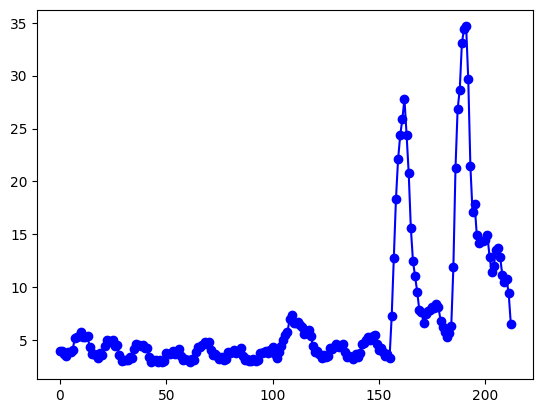

Score:  1463.0
<|im_start|>user
 \cellcolor{red!10}\textbf{52.88} \\
\cline{2-18}

& \cellcolor{red!10}~~~\kv: 1024 & \cellcolor{red!10}25.54 & \cellcolor{red!10}29.51 & \cellcolor{red!10}49.25 & \cellcolor{red!10}40.94 & \cellcolor{red!10}25.7 & \cellcolor{red!10}\textbf{19.42} & \cellcolor{red!10}25.89 & \cellcolor{red!10}23.82 & \cellcolor{red!10}26.11 & \cellcolor{red!10}69.5 & \cellcolor{red!10}\textbf{86.48} & \cellcolor{red!10}42.06 & \cellcolor{red!10}2.98 & \cellcolor{red!10}\textbf{88.56} & \cellscale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



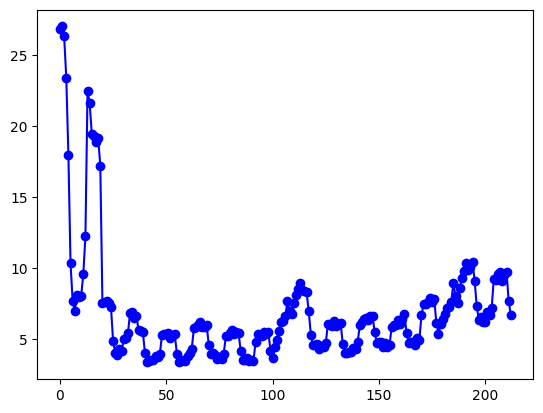

Score:  1462.0
<|im_start|>user
0} 40.76 &\cellcolor{green!10} \textbf{24.92} &\cellcolor{green!10} 19.53&\cellcolor{green!10} 11.27 &\cellcolor{green!10} 25.34 & \cellcolor{green!10}\textbf{25.42} &\cellcolor{green!10} 24.58 &\cellcolor{green!10} 70.5 &\cellcolor{green!10} 61.08 & \cellcolor{green!10} 39.62 &\cellcolor{green!10} \textbf{3.17} &\cellcolor{green!10}\textbf{4.0} & \cellcolor{green!10}\textbf{44.49} & \cellcolor{green!10}44.08\\

&\cellcolor{green!10}~~~H2O: 4096 & \cellcolor{green!10}13.17&\cellcolor{scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



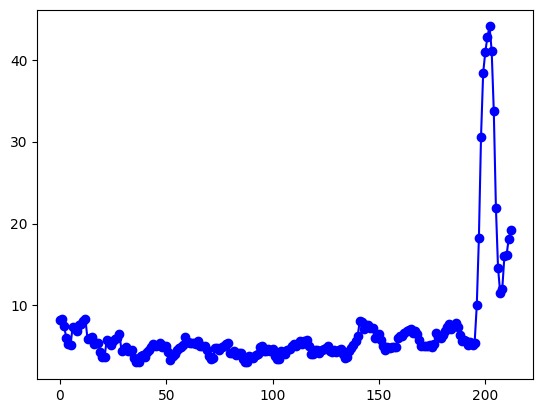

Score:  1447.0
<|im_start|>user
 \cellcolor{red!10}2.73 & \cellcolor{red!10}86.18 & \cellcolor{red!10}55.62 & \cellcolor{red!10}52.65 \\

& \cellcolor{red!10}~~~H2O: 4096 & \cellcolor{red!10}22.61 & \cellcolor{red!10}29.06 & \cellcolor{red!10}47.22 & \cellcolor{red!10}36.54 & \cellcolor{red!10}20.6 & \cellcolor{red!10}16.25 & \cellcolor{red!10}30.0 & \cellcolor{red!10}23.8 & \cellcolor{red!10}26.75 & \cellcolor{red!10}70.5 & \cellcolor{red!10}86.16 & \cellcolor{red!10}42.97 & \cellcolor{red!10}\textbf{3scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



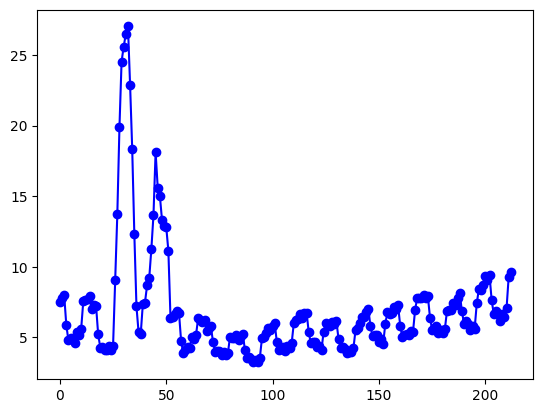

Score:  1358.0
<|im_start|>user
26.84 & \cellcolor{cyan!10}74.5 & \cellcolor{cyan!10}90.24 & \cellcolor{cyan!10}47.1 & \cellcolor{cyan!10}\textbf{7.06} & \cellcolor{cyan!10}99.42 & \cellcolor{cyan!10}64.91 & \cellcolor{cyan!10}63.52 \\



\specialrule{1pt}{2pt}{0pt}



\end{tabular}

}
\begin{tablenotes}
    \scriptsize
    \item[] \hspace{-20pt}\textsuperscript{a} Credit to Jin et al.~\cite{jin2024llm} for the template used in the table.
\end{tablenotes}
\end{threeparttable}\vspace{-10pt}

\end{table*}

\subsection{Experiments on LongBench}
We evaluate \kv on these four models using LongBench~\cite{bai2scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



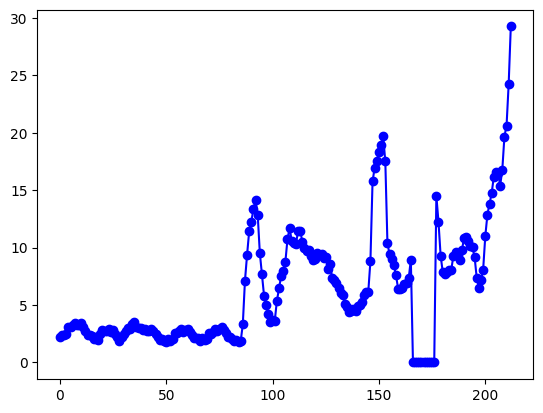

Score:  1348.0
<|im_start|>user
0}~~~All KV & \cellcolor{cyan!10}{26.81} & \cellcolor{cyan!10}\textbf{37.06} & \cellcolor{cyan!10}51.55 & \cellcolor{cyan!10}47.77 & \cellcolor{cyan!10}32.46 & \cellcolor{cyan!10}\textbf{26.59} & \cellcolor{cyan!10}\textbf{34.25} & \cellcolor{cyan!10}\textbf{26.05} & \cellcolor{cyan!10}27.91 & \cellcolor{cyan!10}76.0 & \cellcolor{cyan!10}90.57 & \cellcolor{cyan!10}46.98 & \cellcolor{cyan!10}5.5 & \cellcolor{cyan!10}100.0 & \cellcolor{cyan!10}\textbf{69.07} & \cellcolor{cyanscale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



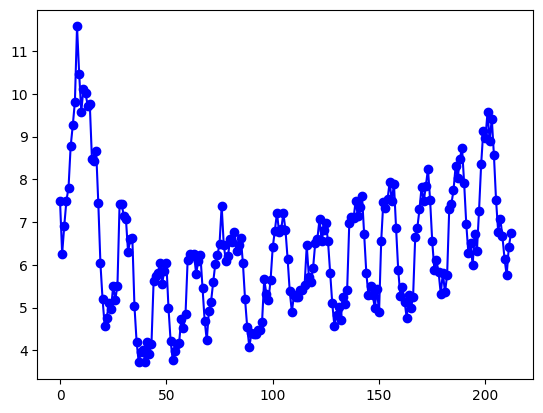

Score:  1320.0
<|im_start|>user
8}{100}\selectfont Mistral}}

& \cellcolor{red!10}~~~All KV & \cellcolor{red!10}\textbf{26.82} & \cellcolor{red!10}33.06 & \cellcolor{red!10}49.28 & \cellcolor{red!10}\textbf{42.77} & \cellcolor{red!10}27.33 & \cellcolor{red!10}19.27 & \cellcolor{red!10}\textbf{32.85} & \cellcolor{red!10}24.25 & \cellcolor{red!10}27.06 & \cellcolor{red!10}71.0 & \cellcolor{red!10}86.23 & \cellcolor{red!10}42.98 & \cellcolor{red!10}2.75 & \cellcolor{red!10}86.98 & \cellcolor{red!10}55.51 & \cellcolor{red!10scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



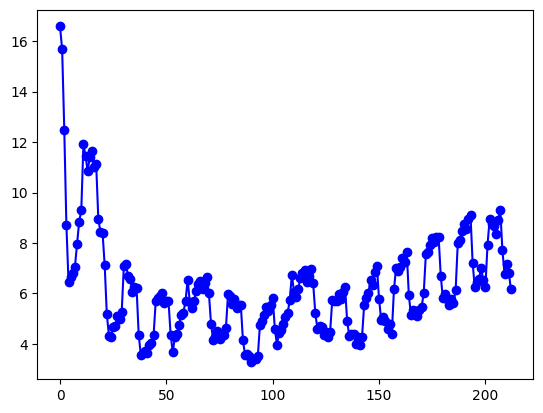

Score:  1283.0
<|im_start|>user
0}28.3 & \cellcolor{blue!10}37.75 & \cellcolor{blue!10}30.51 & \cellcolor{blue!10}23.06 & \cellcolor{blue!10}11.76 & \cellcolor{blue!10}27.55 & \cellcolor{blue!10}21.37 & \cellcolor{blue!10}26.49 & \cellcolor{blue!10}66.0 & \cellcolor{blue!10}75.8 & \cellcolor{blue!10}39.92 & \cellcolor{blue!10}0.0 & \cellcolor{blue!10}25.5 & \cellcolor{blue!10}53.56 & \cellcolor{blue!10}55.53 \\

\specialrule{1pt}{2pt}{10pt}\specialrule{1pt}{2pt}{2pt}



\multirow{5}{*}{\rotatebox[origin=c]{90}{\fontsize{18}{100}\selectfontscale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



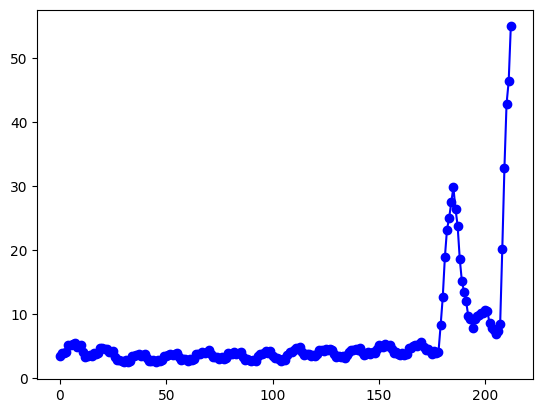

Score:  1258.0
<|im_start|>user
{4}{*}{8k}  & 0  & -1.8\% \\
                     &                      & 14 & 0\%   \\
                     &                      & 30 & -3.4\% \\
                     &                      & Avg & -1.7\% \\ \midrule
\multirow{4}{*}{100} & \multirow{4}{*}{14k} & 0  & -1.2\% \\
                     &                      & 14 & +0.9\% \\
                     &                      & 30 & -0.9\% \\
                     &                      & Avg & -0.6\% \\ \midrule
\multirow{4}{*}{200} & \multirow{4}{*}{24k} & 0  & +4.9\% \\
                     &                      & 14 & +4.9\% \\
                     &                      & 30 & +6.4\% \\
                     &                      & Avg & +5.4\% \\ \bottomrule
\end{tabular}
\smallskip
\small
\textit{Note:} For eachscale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



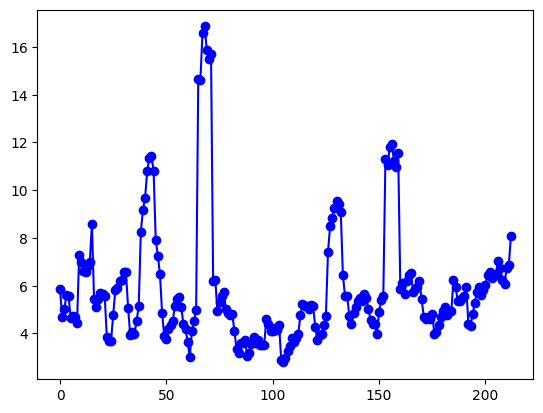

Score:  1198.0
<|im_start|>user
.17&\cellcolor{green!10}24.82&\cellcolor{green!10}20.01&\cellcolor{green!10} 16.86 &\cellcolor{green!10} 9.74&\cellcolor{green!10} 7.2 &\cellcolor{green!10} 25.77 & \cellcolor{green!10}23.26 &\cellcolor{green!10} 23.83 &\cellcolor{green!10} \textbf{71.0} &\cellcolor{green!10} 61.06 & \cellcolor{green!10} \textbf{40.33} &\cellcolor{green!10} 0.0 &\cellcolor{green!10}0.0 & \cellcolor{green!10}41.52 & \cellcolor{green!10}40.97\\


\specialrule{1pt}{2pt}{10pt}\specialrule{1pt}{2pt}{2pt}

\multirow{scale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



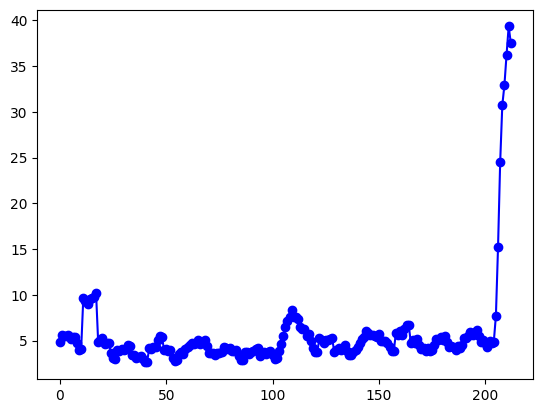

Score:  907.5
<|im_start|>user
an!10}20.45 & \cellcolor{cyan!10}32.09 & \cellcolor{cyan!10}48.02 & \cellcolor{cyan!10}34.76 & \cellcolor{cyan!10}25.69 & \cellcolor{cyan!10}16.5 & \cellcolor{cyan!10}29.76 & \cellcolor{cyan!10}23.53 & \cellcolor{cyan!10}26.84 & \cellcolor{cyan!10}74.5 & \cellcolor{cyan!10}90.24 & \cellcolor{cyan!10}47.1 & \cellcolor{cyan!10}\textbf{7.06} & \cellcolor{cyan!10}99.42 & \cellcolor{cyan!10}64.91 & \cellcolor{cyan!10}63.52 \\



\specialrule{1pt}{2pt}{0pt}



\end{tabscale language modeling.

What is the GitHub repository for SnapKV?<|im_end|>



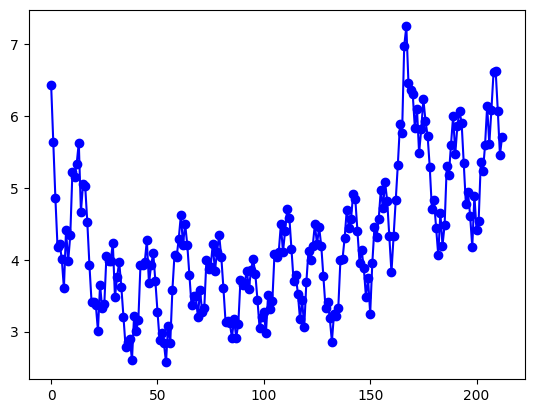

In [7]:
import matplotlib.pyplot as plt
import numpy as np

content_tokens = encoded_tokens[:-query_window]
query_tokens = encoded_tokens[-query_window:]
unpadded_chunks = []
unpadded_tokens = []
print("Query tokens: ", tokenizer.decode(query_tokens))
total_length = encoded_tokens.shape[-1] - query_window

x = padding_window
y = max_tokens - padding_window * 2 - query_window

for content_start in range(0, total_length - y, (3*y)//4):
    split_start = max(0, content_start - x)
    split_end = min(content_start + y, total_length)
    # Adjust post-chunk and pre-chunk if necessary
    post_chunk_end = min(split_end + x, total_length)
    pre_chunk_start = max(0, split_start - x)

    # Handle wrapping for pre-chunk
    if split_start - x < 0:
        pre_chunk_start = total_length + (split_start - x)
        pre_chunk = torch.cat((content_tokens[pre_chunk_start:], content_tokens[:split_start]), dim=-1)
    else:
        pre_chunk = content_tokens[pre_chunk_start:split_start]

    # Handle wrapping for post-chunk
    if split_end + x > total_length:
        post_chunk_end = (split_end + x) % total_length
        post_chunk = torch.cat((content_tokens[split_end:], content_tokens[:post_chunk_end]), dim=-1)
    else:
        post_chunk = content_tokens[split_end:post_chunk_end]

    # Combine pre-chunk, relevant content, and post-chunk
    chunk_tensor = torch.cat((pre_chunk, content_tokens[split_start:split_end], post_chunk, query_tokens), dim=-1)
    decoded_tokens = tokenizer.decode(chunk_tensor, skip_special_tokens=True)
    chunk_text = tokenizer.apply_chat_template([{
        "role": "user",
        "content": decoded_tokens
    }], tokenize=False)

    unpadded_chunks.append(chunk_text)
    unpadded_tokens.append(content_tokens[split_start:split_end])

tokenizer.pad_token = tokenizer.eos_token
chunks = tokenizer(unpadded_chunks, return_tensors="pt", padding=True)

unpadded_chunks_start = []
for chunk in chunks['input_ids']:
    index = 0
    while index < chunk.shape[-1] and chunk[index] == tokenizer.pad_token_id:
        index += 1
    unpadded_chunks_start.append(index)

print("Unpadded chunks start: ", unpadded_chunks_start)

for key in chunks:
    chunks[key] = chunks[key].to(model.device)

outputs = model.generate(**chunks, output_attentions=True, return_dict_in_generate=True, max_new_tokens=1)
attention_scores = outputs.attentions[0]

print("First length: ", len(attention_scores))
print("Second length: ", len(attention_scores[0]))
print("Third length: ", attention_scores[0][0].shape)
# print(attention_scores)

# since we have each of these in distinct layers, we should first stack them
attention_scores = torch.stack(attention_scores, dim=0)
print("Shape: ", attention_scores.shape)
attention_scores = attention_scores.sum(dim=0)
print("Shape: ", attention_scores.shape)
attention_scores = attention_scores.squeeze(0)
print("Shape: ", attention_scores.shape)

chunk_scores = []
attention_weights = []
def apply_max_attentions(tensor: np.ndarray, length=5):
    indices = np.argsort(tensor)
    values = tensor[indices]

    new_tensor = np.zeros(tensor.shape)
    
    for value, index in zip(values, indices): # going from low to high
        left_index = max(0, index - length)
        right_index = min(tensor.shape[-1] - 1, index + length)
        new_tensor[left_index:right_index + 1] = value

    return new_tensor

for chunk_text, chunk_start, scores in zip(unpadded_chunks, unpadded_chunks_start, attention_scores):
    intermediate_sum = torch.sum(scores[:, chunk_start + padding_window:-padding_window], dim=0)
    intermediate_sum = torch.where(intermediate_sum < 100, intermediate_sum, torch.tensor(0))
    interest_score = torch.sum(intermediate_sum)
    chunk_scores.append((interest_score.cpu().numpy(), chunk_text, intermediate_sum.cpu().numpy()))
    # chunk_scores.append((interest_score.cpu().numpy(), chunk_text, apply_max_attentions(intermediate_sum.cpu().numpy())))

chunk_scores = sorted(chunk_scores, reverse=True)


for score, text, attention_scores in chunk_scores:
    print("Score: ", score)
    print(text)
    plt.plot(range(attention_scores.shape[-1]), attention_scores, marker='o', linestyle='-', color='b')
    plt.show()
    # print("Attention scores: ", attention_scores)
    print("===================")

In [8]:
# Selected tokens

tokens_cat = torch.cat(unpadded_tokens, dim=0)
scores_cat = torch.cat([torch.tensor(chunk_tup[-1]) for chunk_tup in chunk_scores], dim=0)

# print(scores_cat.topk(max_tokens))
selected_tokens = []

top_tokens = scores_cat.topk(3000)

for score, index in zip(top_tokens.values, top_tokens.indices):
    token = tokens_cat[index]
    selected_tokens.append(token)

selected_tokens = torch.tensor(selected_tokens)
print(tokenizer.decode(selected_tokens))

IndexError: index 27041 is out of bounds for dimension 0 with size 27008

: 

: 

: 

: 

: 

: 

: 

: 